In [1]:
%matplotlib inline

<center><h1>WEB SURFING WITH DSL CONNECTION (SCENARIO 02)</h1></center>


Please enter the desired confidence interval: .95


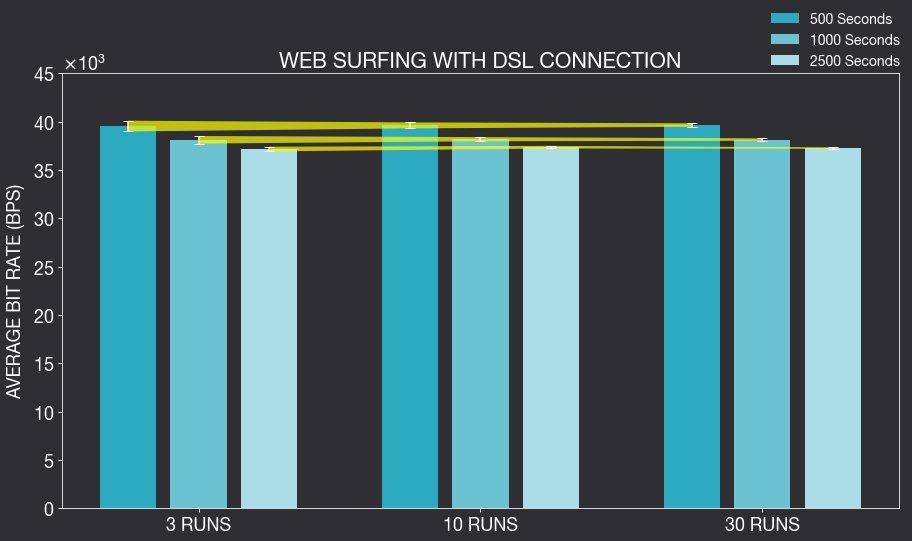

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from matplotlib import style
import math
import decimal
import statistics
from scipy import stats
import os

path = os.getcwd()

class Result_Analysis():
        
    def read_file(self, file_number):
        dict_ = {1: path+'/New_results/NO_VOIP_DSL_rpt03_scenario_02_throughput.csv',
                 2: path+'/New_results/NO_VOIP_DSL_rpt10_scenario_02_throughput.csv',
                 3: path+'/New_results/NO_VOIP_DSL_rpt30_scenario_02_throughput.csv'
                }
        cols = ['run', 'timelimit', 'repetition', 'Module', 'Name', 'throughput']
        data = pd.read_csv(dict_[file_number], delimiter=',', skiprows=[0], names=cols)
        
        df = pd.DataFrame(data)
        
        avgTP_500s_arr = []
        avgTP_1000s_arr = []
        avgTP_2500s_arr = []

        for i in range(len(data)):
            if (df['timelimit'][i] == 500):
                avgTP_500s_arr.append(df['throughput'][i])
            elif (df['timelimit'][i] == 1000):
                avgTP_1000s_arr.append(df['throughput'][i])
            elif (df['timelimit'][i] == 2500):
                avgTP_2500s_arr.append(df['throughput'][i])
        
        arrays = {'array_500': avgTP_500s_arr, 
                  'array_1000': avgTP_1000s_arr,
                  'array_2500': avgTP_2500s_arr
                 }
        return arrays
    
    # Sample variance = SUM((x_i - x_bar)^2) / (n - 1)
    # Sample standard deviation = sqrt(sample variance)
    
    # sampleVariance = 0
    # for i, val in enumerate(arr):
    #    sampleVariance += (val - sampleMean(arr))**2
    # sampleVariance = sampleVariance / (len(arr) - 1)
    # return math.sqrt(sampleVariance)
    
    def SampleStDev(self, arrays):
        sample_stdev = []
        for key, value in arrays.items():
            sample_stdev.append(statistics.stdev(value))
        return sample_stdev
    
    def sampleMean(self, arrays):
        sample_mean = []
        for key, value in arrays.items():
            sample_mean.append(statistics.mean(value))
        return sample_mean
    
    #  We assume we know the population standard deviation. For n <= 30, use T-Score. For n > 30, use Z-Score.
    #  we assume two sided t-value for normal distribution and degree freedom is one less than the length of the array.
    def tScore(self, conf, arrays):
        t_scores = []
        for inner_array in arrays.values():
            t_scores.append(stats.t.ppf((conf + 1) / 2, len(inner_array)-1)) 
        return t_scores


    def confInterval_t(self, conf, arrays, sample_mean, sample_stdev, t_scores):
        for inner_array in arrays.values():
            length = len(inner_array)
        
        upper_t = list((x+y for x,y in zip(sample_mean, 
                                           (a*b/math.sqrt(length) for a,b in zip(t_scores, sample_stdev)))))
        lower_t = list((x-y for x,y in zip(sample_mean, 
                                           (a*b/math.sqrt(length) for a,b in zip(t_scores, sample_stdev)))))
        
        return lower_t, upper_t
    
    def confInterval_z(self, con_coef, arrays, sample_mean, sample_stdev):
        z_interval_l, z_interval_r = stats.norm.interval(con_coef)
        for inner_array in arrays.values():
            length = len(inner_array)
            
        lower_z = list(x + y for x, y in zip(sample_mean, 
                                              (z_interval_l*element/ math.sqrt(length) for element in sample_stdev)))
        upper_z = list(x + y for x, y in zip(sample_mean, 
                                              (z_interval_r*element/ math.sqrt(length) for element in sample_stdev)))
        
        return lower_z, upper_z


run = True
while run:
    try:
        confidence_interval = float(input("\nPlease enter the desired confidence interval: "))
        if confidence_interval >= 1 or 0 >= confidence_interval:
            raise Exception 
                   
    except:
        print("Please enter a valid number from [0, 1)!")
        
    else:
        mean_dict = {}
        t_dict = {}
        z_dict = {}
        for number in range(1,4):
            file_number = number

            obj = Result_Analysis()
            mean = obj.sampleMean(obj.read_file(file_number))
            mean_dict[number] = mean
            
            stdev = obj.SampleStDev(obj.read_file(file_number))
            tscore = obj.tScore(confidence_interval, obj.read_file(file_number))

            t_score_l, t_score_r = obj.confInterval_t(confidence_interval, obj.read_file(file_number), mean, stdev, tscore)
            t_dict[number] = [(x,y) for x,y in zip(t_score_l, t_score_r)]
            
            z_score_l, z_score_r = obj.confInterval_z(confidence_interval, obj.read_file(file_number), mean, stdev)
            z_dict[number] = [(x,y) for x,y in zip(z_score_l, z_score_r)]
            

        #Plot the data
            
        # width of the bars
        barWidth = 0.2
 
        # Choose the height of the bars
        bars_500s = [mean_dict[i][0] for i in mean_dict]
        bars_1000s = [mean_dict[i][1] for i in mean_dict]
        bars_2500s = [mean_dict[i][2] for i in mean_dict]
        
        # Upper and lower limits for confidence interval (error bars) used for fill_between method
        yer_500s_l = [t_dict[1][0][0], t_dict[2][0][0], z_dict[3][0][0]]
        yer_500s_u = [t_dict[1][0][1], t_dict[2][0][1], z_dict[3][0][1]]
        
        yer_1000s_l = [t_dict[1][1][0], t_dict[2][1][0], z_dict[3][1][0]]
        yer_1000s_u = [t_dict[1][1][1], t_dict[2][1][1], z_dict[3][1][1]]
        
        yer_2500s_l = [t_dict[1][2][0], t_dict[2][2][0], z_dict[3][2][0]]
        yer_2500s_u = [t_dict[1][2][1], t_dict[2][2][1], z_dict[3][2][1]]
        
        # Choose the height of the confidence interval (error bars) for errorbar method
        yer_500s = [(u - l)/2 for u, l in zip(yer_500s_u, yer_500s_l)]
        yer_1000s = [(u - l)/2 for u, l in zip(yer_1000s_u, yer_1000s_l)]
        yer_2500s = [(u - l)/2 for u, l in zip(yer_2500s_u, yer_2500s_l)]
        
        # The x position of bars
        r_500s = np.arange(len(bars_500s))
        r_1000s = [x + barWidth + .05 for x in r_500s]
        r_2500s = [x + barWidth + .05 for x in r_1000s]
        
        # Parameter setting for plotting
        plt.rcParams['axes.edgecolor']='#333F4B'
        plt.rcParams['axes.linewidth']=0.8
        plt.rcParams['xtick.color']='#FFFFFF'
        plt.rcParams['ytick.color']='#333F4B'
        plt.rcParams.update({'font.size': 18})
        plt.rcParams["legend.edgecolor"] = 'inherit'
        plt.rcParams["axes.edgecolor"] = 'white'
        plt.rcParams["legend.facecolor"] = 'inherit'
        plt.rcParams["axes.facecolor"] = 'white'
        plt.rcParams["font.family"] = 'serif'
        plt.rcParams['font.serif'] = 'Helvetica Neue'
        
        fig, ax1 = plt.subplots(figsize=(15, 8), facecolor = (0.18, 0.18, 0.2))
        ax1.set_facecolor((0.18, 0.18, 0.2)) 
        
        # Create 1000s bars
        ax1.bar(r_500s, bars_500s, width = barWidth, color = '#2CAAC0', label='500 Seconds')
        ax1.errorbar(r_500s, bars_500s, yerr=yer_500s, color = 'white', capthick=1, capsize=5, fmt=' ')
        ax1.fill_between(r_500s, yer_500s_l, yer_500s_u, facecolor='yellow', alpha=0.7, zorder=2)
        
        # Create 3000s bars
        ax1.bar(r_1000s, bars_1000s, width = barWidth, color = '#6BC3D2', label='1000 Seconds')
        ax1.errorbar(r_1000s, bars_1000s, yerr=yer_1000s, color = 'white', capthick=1, capsize=5, fmt=' ')
        ax1.fill_between(r_1000s, yer_1000s_l, yer_1000s_u, facecolor='yellow', alpha=0.7, zorder=2)
        
        # Create 5000s bars
        ax1.bar(r_2500s, bars_2500s, width = barWidth, color = '#AADDE5', label='2500 Seconds')
        ax1.errorbar(r_2500s, bars_2500s, yerr=yer_2500s, color = 'white', capthick=1, capsize=5, fmt=' ')
        ax1.fill_between(r_2500s, yer_2500s_l, yer_2500s_u, facecolor='yellow', alpha=0.7, zorder=2)
        
        # General layout
        labels = ['3 RUNS','10 RUNS','30 RUNS']
        x = np.arange(len(labels))  # the label locations
        ax1.set_xticks(x+0.25)
        ax1.set_xticklabels(labels ,color = '#FFFFFF')
        ax1.tick_params(direction='out', length=4, width=1, colors='w')
        
        ax1.set_yticks(np.arange(0, 50000, 5000))
        ax1.ticklabel_format(axis='y', style='sci', scilimits=(3,3), useMathText=True)
        ax1.set_ylabel('AVERAGE BIT RATE (BPS)', labelpad=8, color = '#FFFFFF')
        
        ax1.set_title('WEB SURFING WITH DSL CONNECTION', color = '#FFFFFF')
        
        leg1 = ax1.legend(fontsize = 14, loc='lower left', bbox_to_anchor= (0.84, 1.0), ncol=1, borderaxespad=0, frameon=False)
        
        for text in leg1.get_texts():
            text.set_color("white")
            
        #leg2 = ax2.legend(fontsize = 14, loc='lower right', bbox_to_anchor= (1.0, 1.0), ncol=1, borderaxespad=0, frameon=False)
        #for text in leg2.get_texts():
        #    text.set_color("white")
        
        # Show graphic
        plt.show()
        
        #print(f'\n\n\nCI based on T-score: \n{t_dict}')
        #print(f'\n\n\nCI based on Z-score: \n{z_dict}')
        #print(f'\n\n\nMean:{mean_dict}')
        
        run = False 

<center><h1>WEB SURFING WITH ISDN CONNECTION (SCENARIO 01)</h1></center>


Please enter the desired confidence interval: .95


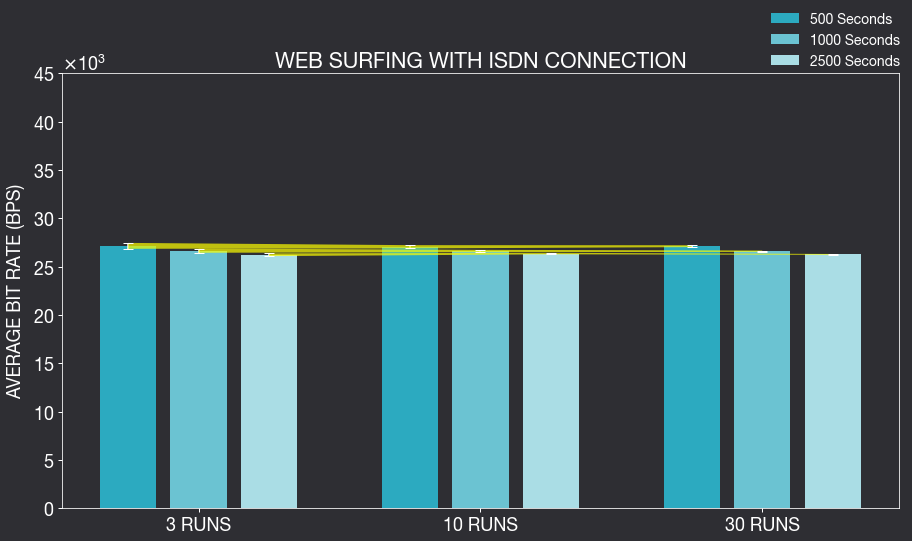

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from matplotlib import style
import math
import decimal
import statistics
from scipy import stats
import os

path = os.getcwd()

class Result_Analysis():
        
    def read_file(self, file_number):
        dict_ = {1: path+'/New_results/NO_VOIP_ISDN_rpt03_scenario_01_throughput.csv',
                 2: path+'/New_results/NO_VOIP_ISDN_rpt10_scenario_01_throughput.csv',
                 3: path+'/New_results/NO_VOIP_ISDN_rpt30_scenario_01_throughput.csv'
                }
        cols = ['run', 'timelimit', 'repetition', 'Module', 'Name', 'throughput']
        data = pd.read_csv(dict_[file_number], delimiter=',', skiprows=[0], names=cols)
        
        df = pd.DataFrame(data)
        
        avgTP_500s_arr = []
        avgTP_1000s_arr = []
        avgTP_2500s_arr = []

        for i in range(len(data)):
            if (df['timelimit'][i] == 500):
                avgTP_500s_arr.append(df['throughput'][i])
            elif (df['timelimit'][i] == 1000):
                avgTP_1000s_arr.append(df['throughput'][i])
            elif (df['timelimit'][i] == 2500):
                avgTP_2500s_arr.append(df['throughput'][i])
        
        arrays = {'array_500': avgTP_500s_arr, 
                  'array_1000': avgTP_1000s_arr,
                  'array_2500': avgTP_2500s_arr
                 }
        return arrays
    
    # Sample variance = SUM((x_i - x_bar)^2) / (n - 1)
    # Sample standard deviation = sqrt(sample variance)
    
    # sampleVariance = 0
    # for i, val in enumerate(arr):
    #    sampleVariance += (val - sampleMean(arr))**2
    # sampleVariance = sampleVariance / (len(arr) - 1)
    # return math.sqrt(sampleVariance)
    
    def SampleStDev(self, arrays):
        sample_stdev = []
        for key, value in arrays.items():
            sample_stdev.append(statistics.stdev(value))
        return sample_stdev
    
    def sampleMean(self, arrays):
        sample_mean = []
        for key, value in arrays.items():
            sample_mean.append(statistics.mean(value))
        return sample_mean
    
    #  We assume we know the population standard deviation. For n <= 30, use T-Score. For n > 30, use Z-Score.
    #  we assume two sided t-value for normal distribution and degree freedom is one less than the length of the array.
    def tScore(self, conf, arrays):
        t_scores = []
        for inner_array in arrays.values():
            t_scores.append(stats.t.ppf((conf + 1) / 2, len(inner_array)-1)) 
        return t_scores


    def confInterval_t(self, conf, arrays, sample_mean, sample_stdev, t_scores):
        for inner_array in arrays.values():
            length = len(inner_array)
        
        upper_t = list((x+y for x,y in zip(sample_mean, 
                                           (a*b/math.sqrt(length) for a,b in zip(t_scores, sample_stdev)))))
        lower_t = list((x-y for x,y in zip(sample_mean, 
                                           (a*b/math.sqrt(length) for a,b in zip(t_scores, sample_stdev)))))
        
        return lower_t, upper_t
    
    def confInterval_z(self, con_coef, arrays, sample_mean, sample_stdev):
        z_interval_l, z_interval_r = stats.norm.interval(con_coef)
        for inner_array in arrays.values():
            length = len(inner_array)
            
        lower_z = list(x + y for x, y in zip(sample_mean, 
                                              (z_interval_l*element/ math.sqrt(length) for element in sample_stdev)))
        upper_z = list(x + y for x, y in zip(sample_mean, 
                                              (z_interval_r*element/ math.sqrt(length) for element in sample_stdev)))
        
        return lower_z, upper_z


run = True
while run:
    try:
        confidence_interval = float(input("\nPlease enter the desired confidence interval: "))
        if confidence_interval >= 1 or 0 >= confidence_interval:
            raise Exception 
                   
    except:
        print("Please enter a valid number from [0, 1)!")
        
    else:
        mean_dict = {}
        t_dict = {}
        z_dict = {}
        for number in range(1,4):
            file_number = number

            obj = Result_Analysis()
            mean = obj.sampleMean(obj.read_file(file_number))
            mean_dict[number] = mean
            
            stdev = obj.SampleStDev(obj.read_file(file_number))
            tscore = obj.tScore(confidence_interval, obj.read_file(file_number))

            t_score_l, t_score_r = obj.confInterval_t(confidence_interval, obj.read_file(file_number), mean, stdev, tscore)
            t_dict[number] = [(x,y) for x,y in zip(t_score_l, t_score_r)]
            
            z_score_l, z_score_r = obj.confInterval_z(confidence_interval, obj.read_file(file_number), mean, stdev)
            z_dict[number] = [(x,y) for x,y in zip(z_score_l, z_score_r)]
            

        #Plot the data
            
        # width of the bars
        barWidth = 0.2
 
        # Choose the height of the bars
        bars_500s = [mean_dict[i][0] for i in mean_dict]
        bars_1000s = [mean_dict[i][1] for i in mean_dict]
        bars_2500s = [mean_dict[i][2] for i in mean_dict]
        
        # Upper and lower limits for confidence interval (error bars) used for fill_between method
        yer_500s_l = [t_dict[1][0][0], t_dict[2][0][0], z_dict[3][0][0]]
        yer_500s_u = [t_dict[1][0][1], t_dict[2][0][1], z_dict[3][0][1]]
        
        yer_1000s_l = [t_dict[1][1][0], t_dict[2][1][0], z_dict[3][1][0]]
        yer_1000s_u = [t_dict[1][1][1], t_dict[2][1][1], z_dict[3][1][1]]
        
        yer_2500s_l = [t_dict[1][2][0], t_dict[2][2][0], z_dict[3][2][0]]
        yer_2500s_u = [t_dict[1][2][1], t_dict[2][2][1], z_dict[3][2][1]]
        
        # Choose the height of the confidence interval (error bars) for errorbar method
        yer_500s = [(u - l)/2 for u, l in zip(yer_500s_u, yer_500s_l)]
        yer_1000s = [(u - l)/2 for u, l in zip(yer_1000s_u, yer_1000s_l)]
        yer_2500s = [(u - l)/2 for u, l in zip(yer_2500s_u, yer_2500s_l)]
        
        # The x position of bars
        r_500s = np.arange(len(bars_500s))
        r_1000s = [x + barWidth + .05 for x in r_500s]
        r_2500s = [x + barWidth + .05 for x in r_1000s]
        
        # Parameter setting for plotting
        plt.rcParams['axes.edgecolor']='#333F4B'
        plt.rcParams['axes.linewidth']=0.8
        plt.rcParams['xtick.color']='#FFFFFF'
        plt.rcParams['ytick.color']='#333F4B'
        plt.rcParams.update({'font.size': 18})
        plt.rcParams["legend.edgecolor"] = 'inherit'
        plt.rcParams["axes.edgecolor"] = 'white'
        plt.rcParams["legend.facecolor"] = 'inherit'
        plt.rcParams["axes.facecolor"] = 'white'
        plt.rcParams["font.family"] = 'serif'
        plt.rcParams['font.serif'] = 'Helvetica Neue'
        
        fig, ax1 = plt.subplots(figsize=(15, 8), facecolor = (0.18, 0.18, 0.2))
        ax1.set_facecolor((0.18, 0.18, 0.2)) 
        
        # Create 1000s bars
        ax1.bar(r_500s, bars_500s, width = barWidth, color = '#2CAAC0', label='500 Seconds')
        ax1.errorbar(r_500s, bars_500s, yerr=yer_500s, color = 'white', capthick=1, capsize=5, fmt=' ')
        ax1.fill_between(r_500s, yer_500s_l, yer_500s_u, facecolor='yellow', alpha=0.7, zorder=2)
        
        # Create 3000s bars
        ax1.bar(r_1000s, bars_1000s, width = barWidth, color = '#6BC3D2', label='1000 Seconds')
        ax1.errorbar(r_1000s, bars_1000s, yerr=yer_1000s, color = 'white', capthick=1, capsize=5, fmt=' ')
        ax1.fill_between(r_1000s, yer_1000s_l, yer_1000s_u, facecolor='yellow', alpha=0.7, zorder=2)
        
        # Create 5000s bars
        ax1.bar(r_2500s, bars_2500s, width = barWidth, color = '#AADDE5', label='2500 Seconds')
        ax1.errorbar(r_2500s, bars_2500s, yerr=yer_2500s, color = 'white', capthick=1, capsize=5, fmt=' ')
        ax1.fill_between(r_2500s, yer_2500s_l, yer_2500s_u, facecolor='yellow', alpha=0.7, zorder=2)
        
        # General layout
        labels = ['3 RUNS','10 RUNS','30 RUNS']
        x = np.arange(len(labels))  # the label locations
        ax1.set_xticks(x+0.25)
        ax1.set_xticklabels(labels ,color = '#FFFFFF')
        ax1.tick_params(direction='out', length=4, width=1, colors='w')
        
        ax1.set_yticks(np.arange(0, 50000, 5000))
        ax1.ticklabel_format(axis='y', style='sci', scilimits=(3,3), useMathText=True)
        ax1.set_ylabel('AVERAGE BIT RATE (BPS)', labelpad=8, color = '#FFFFFF')
        
        ax1.set_title('WEB SURFING WITH ISDN CONNECTION', color = '#FFFFFF')
        
        leg1 = ax1.legend(fontsize = 14, loc='lower left', bbox_to_anchor= (0.84, 1.0), ncol=1, borderaxespad=0, frameon=False)
        
        for text in leg1.get_texts():
            text.set_color("white")
            
        #leg2 = ax2.legend(fontsize = 14, loc='lower right', bbox_to_anchor= (1.0, 1.0), ncol=1, borderaxespad=0, frameon=False)
        #for text in leg2.get_texts():
        #    text.set_color("white")
        
        # Show graphic
        plt.show()
        
        #print(f'\n\n\nCI based on T-score: \n{t_dict}')
        #print(f'\n\n\nCI based on Z-score: \n{z_dict}')
        #print(f'\n\n\nMean:{mean_dict}')
        
        run = False 

<center><h1>VOIP WITH DSL CONNECTION (SCENARIO 04)</h1></center>


Please enter the desired confidence interval: .95


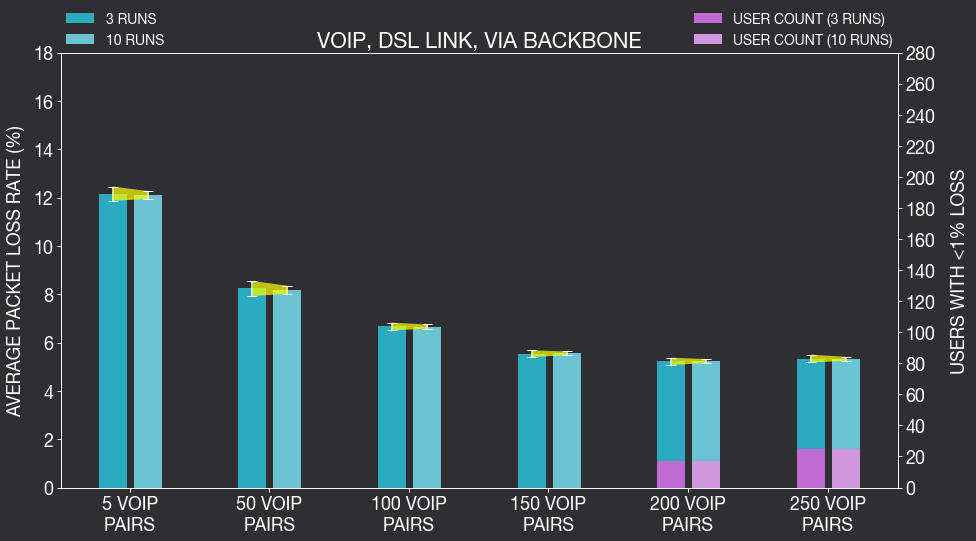

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from matplotlib import style
import math
import decimal
import statistics
from scipy import stats
import os

path = os.getcwd()

class Result_Analysis():
        
    def read_file(self, file_number):
        dict_ = {1: path+'/New_results/VOIP_DSL_rpt03_scenario_04_PAIRS_5_PK_Loss_Rate.csv',
                 2: path+'/New_results/VOIP_DSL_rpt03_scenario_04_PAIRS_50_PK_Loss_Rate.csv',
                 3: path+'/New_results/VOIP_DSL_rpt03_scenario_04_PAIRS_100_PK_Loss_Rate.csv',
                 4: path+'/New_results/VOIP_DSL_rpt03_scenario_04_PAIRS_150_PK_Loss_Rate.csv',
                 5: path+'/New_results/VOIP_DSL_rpt03_scenario_04_PAIRS_200_PK_Loss_Rate.csv',
                 6: path+'/New_results/VOIP_DSL_rpt03_scenario_04_PAIRS_250_PK_Loss_Rate.csv',
                 7: path+'/New_results/VOIP_DSL_rpt10_scenario_04_PAIRS_5_PK_Loss_Rate.csv',
                 8: path+'/New_results/VOIP_DSL_rpt10_scenario_04_PAIRS_50_PK_Loss_Rate.csv',
                 9: path+'/New_results/VOIP_DSL_rpt10_scenario_04_PAIRS_100_PK_Loss_Rate.csv',
                 10: path+'/New_results/VOIP_DSL_rpt10_scenario_04_PAIRS_150_PK_Loss_Rate.csv',
                 11: path+'/New_results/VOIP_DSL_rpt10_scenario_04_PAIRS_200_PK_Loss_Rate.csv',
                 12: path+'/New_results/VOIP_DSL_rpt10_scenario_04_PAIRS_250_PK_Loss_Rate.csv'
                }
        cols = ['run', 'timelimit', 'repetition', 'Module', 'Name', 'Avg_Loss_Rate']
        data = pd.read_csv(dict_[file_number], delimiter=',', skiprows=[0], names=cols)

        data = data.dropna()
        data = data.reset_index(drop=True)
        df = pd.DataFrame(data)
        
        avgPKL_1000s_arr = []
        avgPKL_user_count = 0

        for i in range(len(data)):
            if (df['timelimit'][i] == 1000):
                avgPKL_1000s_arr.append(df['Avg_Loss_Rate'][i]*100)
                
        for i in range(len(data)):
            if (df['Avg_Loss_Rate'][i] < 0.01):
                avgPKL_user_count += 1
           
        array = {'array_1000': avgPKL_1000s_arr}
        count = avgPKL_user_count
        return array, count
    
    def SampleStDev(self, arr):
        sample_stdev = []
        for key, value in arr.items():
            sample_stdev.append(statistics.stdev(value))
        return sample_stdev
    
    def sampleMean(self, arr):
        sample_mean = []
        for key, value in arr.items():
            sample_mean.append(statistics.mean(value))
        return sample_mean
    
    #  We assume we know the population standard deviation. For n <= 30, use T-Score. For n > 30, use Z-Score.
    #  we assume two sided t-value for normal distribution and degree freedom is one less than the length of the array.
    def tScore(self, conf, arr):
        t_scores = []
        for inner_array in arr.values():
            t_scores.append(stats.t.ppf((conf + 1) / 2, len(inner_array)-1)) 
        return t_scores


    def confInterval_t(self, arr, sample_mean, sample_stdev, t_scores):
        for inner_array in arr.values():
            length = len(inner_array)
        
        upper_t = list((x+y for x,y in zip(sample_mean, 
                                           (a*b/math.sqrt(length) for a,b in zip(t_scores, sample_stdev)))))
        lower_t = list((x-y for x,y in zip(sample_mean, 
                                           (a*b/math.sqrt(length) for a,b in zip(t_scores, sample_stdev)))))
        
        return lower_t, upper_t
    
    def confInterval_z(self, con_coef, arr, sample_mean, sample_stdev):
        z_interval_l, z_interval_r = stats.norm.interval(con_coef)
        for inner_array in arr.values():
            length = len(inner_array)
            
        lower_z = list(x + y for x, y in zip(sample_mean, 
                                              (z_interval_l*element/ math.sqrt(length) for element in sample_stdev)))
        upper_z = list(x + y for x, y in zip(sample_mean, 
                                              (z_interval_r*element/ math.sqrt(length) for element in sample_stdev)))
        
        return lower_z, upper_z


run = True
while run:
    try:
        confidence_interval = float(input("\nPlease enter the desired confidence interval: "))
        if confidence_interval >= 1 or 0 >= confidence_interval:
            raise Exception 
                   
    except:
        print("Please enter a valid number from [0, 1)!")
        
    else:
        mean_dict = {}
        t_dict = {}
        z_dict = {}
        user_count_arr = []
        for number in range(1,13):
            file_number = number
            
            obj = Result_Analysis()
            array, count = obj.read_file(file_number)
            user_count_arr.append(count)
            mean = obj.sampleMean(array)
            mean_dict[number] = mean
            
            stdev = obj.SampleStDev(array)
            tscore = obj.tScore(confidence_interval, array)

            t_score_l, t_score_r = obj.confInterval_t(array, mean, stdev, tscore)
            t_dict[number] = [(x,y) for x,y in zip(t_score_l, t_score_r)]
            
            z_score_l, z_score_r = obj.confInterval_z(confidence_interval, array, mean, stdev)
            z_dict[number] = [(x,y) for x,y in zip(z_score_l, z_score_r)]
        
        #Plot the data
            
        # width of the bars
        barWidth = 0.2
        
        # Choose the height of the bars
        bars_count_rpt03 = [math.ceil(user_count_arr[index]/3) for index, value in enumerate(user_count_arr) if index <= 5]
        bars_count_rpt10 = [math.ceil(user_count_arr[index]/10) for index, value in enumerate(user_count_arr) if index > 5]
        
        bars_1000s_rpt03 = [mean_dict[i][0] for i in mean_dict if i <= 6]
        bars_1000s_rpt10 = [mean_dict[i][0] for i in mean_dict if i > 6]
        
        # Upper and lower limits for confidence interval (error bars) used for fill_between method
        yer_1000s_l_rpt03 = [t_dict[1][0][0], t_dict[2][0][0], t_dict[3][0][0], t_dict[4][0][0],
                            t_dict[5][0][0], t_dict[6][0][0]]
                       
        yer_1000s_u_rpt03 = [t_dict[1][0][1], t_dict[2][0][1], t_dict[3][0][1], t_dict[4][0][1], 
                             t_dict[5][0][1], t_dict[6][0][1]]
        
        yer_1000s_l_rpt10 = [t_dict[7][0][0], t_dict[8][0][0], t_dict[9][0][0], t_dict[10][0][0], 
                             t_dict[11][0][0], t_dict[12][0][0]]
        
        yer_1000s_u_rpt10 = [t_dict[7][0][1], t_dict[8][0][1], t_dict[9][0][1], t_dict[10][0][1], 
                             t_dict[11][0][1], t_dict[12][0][1]]
                
        # Choose the height of the confidence interval (error bars) for errorbar method
        yer_1000s_rpt03 = [(u - l)/2 for u, l in zip(yer_1000s_u_rpt03, yer_1000s_l_rpt03)]
        yer_1000s_rpt10 = [(u - l)/2 for u, l in zip(yer_1000s_u_rpt10, yer_1000s_l_rpt10)]
        
        # The x position of bars
        r_1000s_rpt03 = np.arange(len(bars_1000s_rpt03))
        r_1000s_rpt10 = [x + barWidth + .05 for x in r_1000s_rpt03]

        #Parameter setting for plotting
        plt.rcParams['axes.edgecolor']='#333F4B'
        plt.rcParams['axes.linewidth']=0.8
        plt.rcParams['xtick.color']='#FFFFFF'
        plt.rcParams['ytick.color']='#333F4B'
        plt.rcParams.update({'font.size': 18})
        plt.rcParams["legend.edgecolor"] = 'inherit'
        plt.rcParams["axes.edgecolor"] = 'white'
        plt.rcParams["legend.facecolor"] = 'inherit'
        plt.rcParams["axes.facecolor"] = 'white'
        plt.rcParams["font.family"] = 'serif'
        plt.rcParams['font.serif'] = 'Helvetica Neue'
        
        fig, ax1 = plt.subplots(figsize=(15, 8), facecolor = (0.18, 0.18, 0.2))
        ax1.set_facecolor((0.18, 0.18, 0.2))
        ax2 = ax1.twinx()
        
        # Create 1000s_rpt03 bars
        ax1.bar(r_1000s_rpt03, bars_1000s_rpt03, width = barWidth, color = '#2CAAC0', label='3 RUNS')
        ax1.errorbar(r_1000s_rpt03, bars_1000s_rpt03, yerr=yer_1000s_rpt03, color = 'white', capthick=1, capsize=5, fmt=' ')
        
        # Create 1000s_rpt10 bars
        ax1.bar(r_1000s_rpt10, bars_1000s_rpt10, width = barWidth, color = '#6BC3D2', label='10 RUNS')
        ax1.errorbar(r_1000s_rpt10, bars_1000s_rpt10, yerr=yer_1000s_rpt10, color = 'white', capthick=1, capsize=5, fmt=' ')
        
        r_pairs = [[x, y] for x,y in zip(r_1000s_rpt03, r_1000s_rpt10)]
        yer_l = [[x,y] for x,y in zip(yer_1000s_l_rpt03, yer_1000s_l_rpt10)]
        yer_u = [[x,y] for x,y in zip(yer_1000s_u_rpt03, yer_1000s_u_rpt10)]
        
        for i in range(len(r_pairs)):
            ax1.fill_between(r_pairs[i], yer_l[i], yer_u[i], facecolor='yellow', alpha=0.7, zorder=2)
        
        ax2.bar(r_1000s_rpt03, bars_count_rpt03, width = barWidth, color = '#BD6BD2', label='USER COUNT (3 RUNS)')
        ax2.bar(r_1000s_rpt10, bars_count_rpt10, width = barWidth, color = '#D097DF', label='USER COUNT (10 RUNS)')
        
        
        labels = ['5 VOIP\nPAIRS','50 VOIP\nPAIRS','100 VOIP\nPAIRS','150 VOIP\nPAIRS','200 VOIP\nPAIRS',
                  '250 VOIP\nPAIRS']
        x = np.arange(len(labels))  # the label locations
        ax1.set_xticks(x+0.12)
        ax1.set_xticklabels(labels ,color = '#FFFFFF')
        ax1.tick_params(direction='out', length=4, width=1, colors='w')
        
        ax1.set_yticks(np.arange(0.0, 20.0, 2.0))
        ax1.set_ylabel('AVERAGE PACKET LOSS RATE (%)', labelpad=8, color = '#FFFFFF')
        
        ax2.set_yticks(np.arange(0, 300, 20))
        ax2.tick_params(direction='out', length=4, width=1, colors='w')
        ax2.set_ylabel('USERS WITH <1% LOSS', labelpad=16, color = '#FFFFFF')
        ax1.set_title('VOIP, DSL LINK, VIA BACKBONE', color = '#FFFFFF')
        
        leg1 = ax1.legend(fontsize = 14, loc='lower left', bbox_to_anchor= (0.0, 1.0), ncol=1, borderaxespad=0, frameon=False)
        leg2 = ax2.legend(fontsize = 14, loc='lower right', bbox_to_anchor= (1.0, 1.0), ncol=1, borderaxespad=0, frameon=False)
        for text in leg1.get_texts():
            text.set_color("white")
        for text in leg2.get_texts():
            text.set_color("white")
        
        plt.show()
        
        #print(f'\n\n\nCI based on T-score: \n{t_dict}')
        #print(f'\n\n\nCI based on Z-score: \n{z_dict}')
        #print(f'\n\n\nMean:{mean_dict}')
        
        run = False 

<center><h1>VOIP WITH DSL CONNECTION (SCENARIO 05)</h1></center>


Please enter the desired confidence interval: .95


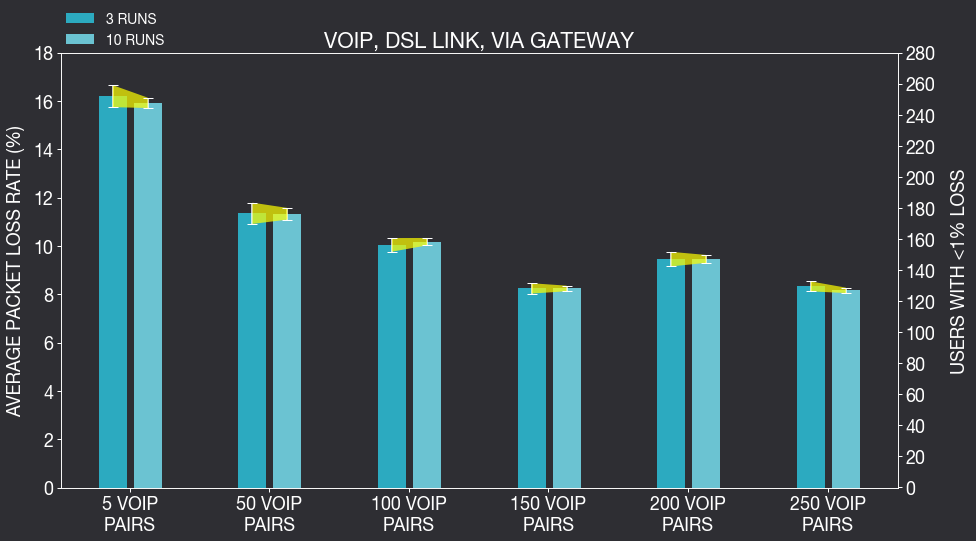

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from matplotlib import style
import math
import decimal
import statistics
from scipy import stats
import os

path = os.getcwd()

class Result_Analysis():
        
    def read_file(self, file_number):
        dict_ = {1: path+'/New_results/VOIP_DSL_rpt03_scenario_05_PAIRS_5_PK_Loss_Rate.csv',
                 2: path+'/New_results/VOIP_DSL_rpt03_scenario_05_PAIRS_50_PK_Loss_Rate.csv',
                 3: path+'/New_results/VOIP_DSL_rpt03_scenario_05_PAIRS_100_PK_Loss_Rate.csv',
                 4: path+'/New_results/VOIP_DSL_rpt03_scenario_05_PAIRS_150_PK_Loss_Rate.csv',
                 5: path+'/New_results/VOIP_DSL_rpt03_scenario_05_PAIRS_200_PK_Loss_Rate.csv',
                 6: path+'/New_results/VOIP_DSL_rpt03_scenario_05_PAIRS_250_PK_Loss_Rate.csv',
                 7: path+'/New_results/VOIP_DSL_rpt10_scenario_05_PAIRS_5_PK_Loss_Rate.csv',
                 8: path+'/New_results/VOIP_DSL_rpt10_scenario_05_PAIRS_50_PK_Loss_Rate.csv',
                 9: path+'/New_results/VOIP_DSL_rpt10_scenario_05_PAIRS_100_PK_Loss_Rate.csv',
                 10: path+'/New_results/VOIP_DSL_rpt10_scenario_05_PAIRS_150_PK_Loss_Rate.csv',
                 11: path+'/New_results/VOIP_DSL_rpt10_scenario_05_PAIRS_200_PK_Loss_Rate.csv',
                 12: path+'/New_results/VOIP_DSL_rpt10_scenario_05_PAIRS_250_PK_Loss_Rate.csv'
                }
        cols = ['run', 'timelimit', 'repetition', 'Module', 'Name', 'Avg_Loss_Rate']
        data = pd.read_csv(dict_[file_number], delimiter=',', skiprows=[0], names=cols)

        data = data.dropna()
        data = data.reset_index(drop=True)
        df = pd.DataFrame(data)
        
        avgPKL_1000s_arr = []
        avgPKL_user_count = 0

        for i in range(len(data)):
            if (df['timelimit'][i] == 1000):
                avgPKL_1000s_arr.append(df['Avg_Loss_Rate'][i]*100)
                
        for i in range(len(data)):
            if (df['Avg_Loss_Rate'][i] < 0.01):
                avgPKL_user_count += 1
           
        array = {'array_1000': avgPKL_1000s_arr}
        count = avgPKL_user_count
        return array, count
    
    def SampleStDev(self, arr):
        sample_stdev = []
        for key, value in arr.items():
            sample_stdev.append(statistics.stdev(value))
        return sample_stdev
    
    def sampleMean(self, arr):
        sample_mean = []
        for key, value in arr.items():
            sample_mean.append(statistics.mean(value))
        return sample_mean
    
    #  We assume we know the population standard deviation. For n <= 30, use T-Score. For n > 30, use Z-Score.
    #  we assume two sided t-value for normal distribution and degree freedom is one less than the length of the array.
    def tScore(self, conf, arr):
        t_scores = []
        for inner_array in arr.values():
            t_scores.append(stats.t.ppf((conf + 1) / 2, len(inner_array)-1)) 
        return t_scores


    def confInterval_t(self, arr, sample_mean, sample_stdev, t_scores):
        for inner_array in arr.values():
            length = len(inner_array)
        
        upper_t = list((x+y for x,y in zip(sample_mean, 
                                           (a*b/math.sqrt(length) for a,b in zip(t_scores, sample_stdev)))))
        lower_t = list((x-y for x,y in zip(sample_mean, 
                                           (a*b/math.sqrt(length) for a,b in zip(t_scores, sample_stdev)))))
        
        return lower_t, upper_t
    
    def confInterval_z(self, con_coef, arr, sample_mean, sample_stdev):
        z_interval_l, z_interval_r = stats.norm.interval(con_coef)
        for inner_array in arr.values():
            length = len(inner_array)
            
        lower_z = list(x + y for x, y in zip(sample_mean, 
                                              (z_interval_l*element/ math.sqrt(length) for element in sample_stdev)))
        upper_z = list(x + y for x, y in zip(sample_mean, 
                                              (z_interval_r*element/ math.sqrt(length) for element in sample_stdev)))
        
        return lower_z, upper_z


run = True
while run:
    try:
        confidence_interval = float(input("\nPlease enter the desired confidence interval: "))
        if confidence_interval >= 1 or 0 >= confidence_interval:
            raise Exception 
                   
    except:
        print("Please enter a valid number from [0, 1)!")
        
    else:
        mean_dict = {}
        t_dict = {}
        z_dict = {}
        user_count_arr = []
        for number in range(1,13):
            file_number = number
            
            obj = Result_Analysis()
            array, count = obj.read_file(file_number)
            user_count_arr.append(count)
            mean = obj.sampleMean(array)
            mean_dict[number] = mean
            
            stdev = obj.SampleStDev(array)
            tscore = obj.tScore(confidence_interval, array)

            t_score_l, t_score_r = obj.confInterval_t(array, mean, stdev, tscore)
            t_dict[number] = [(x,y) for x,y in zip(t_score_l, t_score_r)]
            
            z_score_l, z_score_r = obj.confInterval_z(confidence_interval, array, mean, stdev)
            z_dict[number] = [(x,y) for x,y in zip(z_score_l, z_score_r)]
        
        #Plot the data
            
        # width of the bars
        barWidth = 0.2
        
        # Choose the height of the bars
        bars_count_rpt03 = [math.ceil(user_count_arr[index]/3) for index, value in enumerate(user_count_arr) if index <= 5]
        bars_count_rpt10 = [math.ceil(user_count_arr[index]/10) for index, value in enumerate(user_count_arr) if index > 5]
        
        bars_1000s_rpt03 = [mean_dict[i][0] for i in mean_dict if i <= 6]
        bars_1000s_rpt10 = [mean_dict[i][0] for i in mean_dict if i > 6]
        
        # Upper and lower limits for confidence interval (error bars) used for fill_between method
        yer_1000s_l_rpt03 = [t_dict[1][0][0], t_dict[2][0][0], t_dict[3][0][0], t_dict[4][0][0],
                            t_dict[5][0][0], t_dict[6][0][0]]
                       
        yer_1000s_u_rpt03 = [t_dict[1][0][1], t_dict[2][0][1], t_dict[3][0][1], t_dict[4][0][1], 
                             t_dict[5][0][1], t_dict[6][0][1]]
        
        yer_1000s_l_rpt10 = [t_dict[7][0][0], t_dict[8][0][0], t_dict[9][0][0], t_dict[10][0][0], 
                             t_dict[11][0][0], t_dict[12][0][0]]
        
        yer_1000s_u_rpt10 = [t_dict[7][0][1], t_dict[8][0][1], t_dict[9][0][1], t_dict[10][0][1], 
                             t_dict[11][0][1], t_dict[12][0][1]]
        
        # Choose the height of the confidence interval (error bars) for errorbar method
        yer_1000s_rpt03 = [(u - l)/2 for u, l in zip(yer_1000s_u_rpt03, yer_1000s_l_rpt03)]
        yer_1000s_rpt10 = [(u - l)/2 for u, l in zip(yer_1000s_u_rpt10, yer_1000s_l_rpt10)]
        
        # The x position of bars
        r_1000s_rpt03 = np.arange(len(bars_1000s_rpt03))
        r_1000s_rpt10 = [x + barWidth + .05 for x in r_1000s_rpt03]

        #Parameter setting for plotting
        plt.rcParams['axes.edgecolor']='#333F4B'
        plt.rcParams['axes.linewidth']=0.8
        plt.rcParams['xtick.color']='#FFFFFF'
        plt.rcParams['ytick.color']='#333F4B'
        plt.rcParams.update({'font.size': 18})
        plt.rcParams["legend.edgecolor"] = 'inherit'
        plt.rcParams["axes.edgecolor"] = 'white'
        plt.rcParams["legend.facecolor"] = 'inherit'
        plt.rcParams["axes.facecolor"] = 'white'
        plt.rcParams["font.family"] = 'serif'
        plt.rcParams['font.serif'] = 'Helvetica Neue'
        
        fig, ax1 = plt.subplots(figsize=(15, 8), facecolor = (0.18, 0.18, 0.2))
        ax1.set_facecolor((0.18, 0.18, 0.2))
        ax2 = ax1.twinx()
        
        # Create 1000s_rpt03 bars
        ax1.bar(r_1000s_rpt03, bars_1000s_rpt03, width = barWidth, color = '#2CAAC0', label='3 RUNS')
        ax1.errorbar(r_1000s_rpt03, bars_1000s_rpt03, yerr=yer_1000s_rpt03, color = 'white', capthick=1, capsize=5, fmt=' ')
        
        # Create 1000s_rpt10 bars
        ax1.bar(r_1000s_rpt10, bars_1000s_rpt10, width = barWidth, color = '#6BC3D2', label='10 RUNS')
        ax1.errorbar(r_1000s_rpt10, bars_1000s_rpt10, yerr=yer_1000s_rpt10, color = 'white', capthick=1, capsize=5, fmt=' ')
        
        r_pairs = [[x, y] for x,y in zip(r_1000s_rpt03, r_1000s_rpt10)]
        yer_l = [[x,y] for x,y in zip(yer_1000s_l_rpt03, yer_1000s_l_rpt10)]
        yer_u = [[x,y] for x,y in zip(yer_1000s_u_rpt03, yer_1000s_u_rpt10)]
        
        for i in range(len(r_pairs)):
            ax1.fill_between(r_pairs[i], yer_l[i], yer_u[i], facecolor='yellow', alpha=0.7, zorder=2)
        
        ax2.bar(r_1000s_rpt03, bars_count_rpt03, width = barWidth, color = '#BD6BD2', label='USER COUNT (3 RUNS)')
        ax2.bar(r_1000s_rpt10, bars_count_rpt10, width = barWidth, color = '#D097DF', label='USER COUNT (10 RUNS)')
        
        
        labels = ['5 VOIP\nPAIRS','50 VOIP\nPAIRS','100 VOIP\nPAIRS','150 VOIP\nPAIRS','200 VOIP\nPAIRS',
                  '250 VOIP\nPAIRS']
        x = np.arange(len(labels))  # the label locations
        ax1.set_xticks(x+0.12)
        ax1.set_xticklabels(labels ,color = '#FFFFFF')
        ax1.tick_params(direction='out', length=4, width=1, colors='w')
        
        ax1.set_yticks(np.arange(0.0, 20.0, 2.0))
        ax1.set_ylabel('AVERAGE PACKET LOSS RATE (%)', labelpad=8, color = '#FFFFFF')
        
        ax2.set_yticks(np.arange(0, 300, 20))
        ax2.tick_params(direction='out', length=4, width=1, colors='w')
        ax2.set_ylabel('USERS WITH <1% LOSS', labelpad=16, color = '#FFFFFF')
        ax1.set_title('VOIP, DSL LINK, VIA GATEWAY', color = '#FFFFFF')
        
        leg1 = ax1.legend(fontsize = 14, loc='lower left', bbox_to_anchor= (0.0, 1.0), ncol=1, borderaxespad=0, frameon=False)
        #leg2 = ax2.legend(fontsize = 14, loc='lower right', bbox_to_anchor= (1.0, 1.0), ncol=1, borderaxespad=0, frameon=False)
        for text in leg1.get_texts():
            text.set_color("white")
        #for text in leg2.get_texts():
        #    text.set_color("white")
        
        plt.show()
        
        #print(f'\n\n\nCI based on T-score: \n{t_dict}')
        #print(f'\n\n\nCI based on Z-score: \n{z_dict}')
        #print(f'\n\n\nMean:{mean_dict}')
        
        run = False 

<center><h1>VOIP WITH DSL CONNECTION (SCENARIO 04 & 10)</h1></center>


Please enter the desired confidence interval: .95


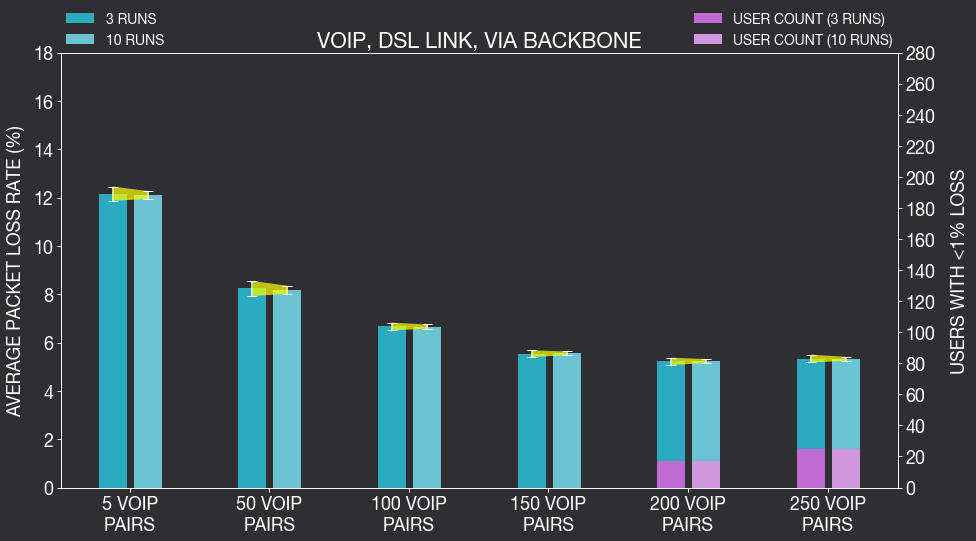

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from matplotlib import style
import math
import decimal
import statistics
from scipy import stats
import os

path = os.getcwd()

class Result_Analysis():
        
    def read_file(self, file_number):
        dict_ = {1: path+'/New_results/VOIP_DSL_rpt03_scenario_04_PAIRS_5_PK_Loss_Rate.csv',
                 2: path+'/New_results/VOIP_DSL_rpt03_scenario_04_PAIRS_50_PK_Loss_Rate.csv',
                 3: path+'/New_results/VOIP_DSL_rpt03_scenario_04_PAIRS_100_PK_Loss_Rate.csv',
                 4: path+'/New_results/VOIP_DSL_rpt03_scenario_04_PAIRS_150_PK_Loss_Rate.csv',
                 5: path+'/New_results/VOIP_DSL_rpt03_scenario_04_PAIRS_200_PK_Loss_Rate.csv',
                 6: path+'/New_results/VOIP_DSL_rpt03_scenario_04_PAIRS_250_PK_Loss_Rate.csv',
                 7: path+'/New_results/VOIP_DSL_rpt10_scenario_04_PAIRS_5_PK_Loss_Rate.csv',
                 8: path+'/New_results/VOIP_DSL_rpt10_scenario_04_PAIRS_50_PK_Loss_Rate.csv',
                 9: path+'/New_results/VOIP_DSL_rpt10_scenario_04_PAIRS_100_PK_Loss_Rate.csv',
                 10: path+'/New_results/VOIP_DSL_rpt10_scenario_04_PAIRS_150_PK_Loss_Rate.csv',
                 11: path+'/New_results/VOIP_DSL_rpt10_scenario_04_PAIRS_200_PK_Loss_Rate.csv',
                 12: path+'/New_results/VOIP_DSL_rpt10_scenario_04_PAIRS_250_PK_Loss_Rate.csv'
                }
        cols = ['run', 'timelimit', 'repetition', 'Module', 'Name', 'Avg_Loss_Rate']
        data = pd.read_csv(dict_[file_number], delimiter=',', skiprows=[0], names=cols)

        data = data.dropna()
        data = data.reset_index(drop=True)
        df = pd.DataFrame(data)
        
        avgPKL_1000s_arr = []
        avgPKL_user_count = 0

        for i in range(len(data)):
            if (df['timelimit'][i] == 1000):
                avgPKL_1000s_arr.append(df['Avg_Loss_Rate'][i]*100)
                
        for i in range(len(data)):
            if (df['Avg_Loss_Rate'][i] < 0.01):
                avgPKL_user_count += 1
           
        array = {'array_1000': avgPKL_1000s_arr}
        count = avgPKL_user_count
        return array, count
    
    def SampleStDev(self, arr):
        sample_stdev = []
        for key, value in arr.items():
            sample_stdev.append(statistics.stdev(value))
        return sample_stdev
    
    def sampleMean(self, arr):
        sample_mean = []
        for key, value in arr.items():
            sample_mean.append(statistics.mean(value))
        return sample_mean
    
    #  We assume we know the population standard deviation. For n <= 30, use T-Score. For n > 30, use Z-Score.
    #  we assume two sided t-value for normal distribution and degree freedom is one less than the length of the array.
    def tScore(self, conf, arr):
        t_scores = []
        for inner_array in arr.values():
            t_scores.append(stats.t.ppf((conf + 1) / 2, len(inner_array)-1)) 
        return t_scores


    def confInterval_t(self, arr, sample_mean, sample_stdev, t_scores):
        for inner_array in arr.values():
            length = len(inner_array)
        
        upper_t = list((x+y for x,y in zip(sample_mean, 
                                           (a*b/math.sqrt(length) for a,b in zip(t_scores, sample_stdev)))))
        lower_t = list((x-y for x,y in zip(sample_mean, 
                                           (a*b/math.sqrt(length) for a,b in zip(t_scores, sample_stdev)))))
        
        return lower_t, upper_t
    
    def confInterval_z(self, con_coef, arr, sample_mean, sample_stdev):
        z_interval_l, z_interval_r = stats.norm.interval(con_coef)
        for inner_array in arr.values():
            length = len(inner_array)
            
        lower_z = list(x + y for x, y in zip(sample_mean, 
                                              (z_interval_l*element/ math.sqrt(length) for element in sample_stdev)))
        upper_z = list(x + y for x, y in zip(sample_mean, 
                                              (z_interval_r*element/ math.sqrt(length) for element in sample_stdev)))
        
        return lower_z, upper_z


run = True
while run:
    try:
        confidence_interval = float(input("\nPlease enter the desired confidence interval: "))
        if confidence_interval >= 1 or 0 >= confidence_interval:
            raise Exception 
                   
    except:
        print("Please enter a valid number from [0, 1)!")
        
    else:
        mean_dict = {}
        t_dict = {}
        z_dict = {}
        user_count_arr = []
        for number in range(1,13):
            file_number = number
            
            obj = Result_Analysis()
            array, count = obj.read_file(file_number)
            user_count_arr.append(count)
            mean = obj.sampleMean(array)
            mean_dict[number] = mean
            
            stdev = obj.SampleStDev(array)
            tscore = obj.tScore(confidence_interval, array)

            t_score_l, t_score_r = obj.confInterval_t(array, mean, stdev, tscore)
            t_dict[number] = [(x,y) for x,y in zip(t_score_l, t_score_r)]
            
            z_score_l, z_score_r = obj.confInterval_z(confidence_interval, array, mean, stdev)
            z_dict[number] = [(x,y) for x,y in zip(z_score_l, z_score_r)]
        
        #Plot the data
            
        # width of the bars
        barWidth = 0.2
        
        # Choose the height of the bars
        bars_count_rpt03 = [math.ceil(user_count_arr[index]/3) for index, value in enumerate(user_count_arr) if index <= 5]
        bars_count_rpt10 = [math.ceil(user_count_arr[index]/10) for index, value in enumerate(user_count_arr) if index > 5]
        
        bars_1000s_rpt03 = [mean_dict[i][0] for i in mean_dict if i <= 6]
        bars_1000s_rpt10 = [mean_dict[i][0] for i in mean_dict if i > 6]
        
        # Upper and lower limits for confidence interval (error bars) used for fill_between method
        yer_1000s_l_rpt03 = [t_dict[1][0][0], t_dict[2][0][0], t_dict[3][0][0], t_dict[4][0][0],
                            t_dict[5][0][0], t_dict[6][0][0]]
                       
        yer_1000s_u_rpt03 = [t_dict[1][0][1], t_dict[2][0][1], t_dict[3][0][1], t_dict[4][0][1], 
                             t_dict[5][0][1], t_dict[6][0][1]]
        
        yer_1000s_l_rpt10 = [t_dict[7][0][0], t_dict[8][0][0], t_dict[9][0][0], t_dict[10][0][0], 
                             t_dict[11][0][0], t_dict[12][0][0]]
        
        yer_1000s_u_rpt10 = [t_dict[7][0][1], t_dict[8][0][1], t_dict[9][0][1], t_dict[10][0][1], 
                             t_dict[11][0][1], t_dict[12][0][1]]
                
        # Choose the height of the confidence interval (error bars) for errorbar method
        yer_1000s_rpt03 = [(u - l)/2 for u, l in zip(yer_1000s_u_rpt03, yer_1000s_l_rpt03)]
        yer_1000s_rpt10 = [(u - l)/2 for u, l in zip(yer_1000s_u_rpt10, yer_1000s_l_rpt10)]
        
        # The x position of bars
        r_1000s_rpt03 = np.arange(len(bars_1000s_rpt03))
        r_1000s_rpt10 = [x + barWidth + .05 for x in r_1000s_rpt03]

        #Parameter setting for plotting
        plt.rcParams['axes.edgecolor']='#333F4B'
        plt.rcParams['axes.linewidth']=0.8
        plt.rcParams['xtick.color']='#FFFFFF'
        plt.rcParams['ytick.color']='#333F4B'
        plt.rcParams.update({'font.size': 18})
        plt.rcParams["legend.edgecolor"] = 'inherit'
        plt.rcParams["axes.edgecolor"] = 'white'
        plt.rcParams["legend.facecolor"] = 'inherit'
        plt.rcParams["axes.facecolor"] = 'white'
        plt.rcParams["font.family"] = 'serif'
        plt.rcParams['font.serif'] = 'Helvetica Neue'
        
        fig, ax1 = plt.subplots(figsize=(15, 8), facecolor = (0.18, 0.18, 0.2))
        ax1.set_facecolor((0.18, 0.18, 0.2))
        ax2 = ax1.twinx()
        
        # Create 1000s_rpt03 bars
        ax1.bar(r_1000s_rpt03, bars_1000s_rpt03, width = barWidth, color = '#2CAAC0', label='3 RUNS')
        ax1.errorbar(r_1000s_rpt03, bars_1000s_rpt03, yerr=yer_1000s_rpt03, color = 'white', capthick=1, capsize=5, fmt=' ')
        
        # Create 1000s_rpt10 bars
        ax1.bar(r_1000s_rpt10, bars_1000s_rpt10, width = barWidth, color = '#6BC3D2', label='10 RUNS')
        ax1.errorbar(r_1000s_rpt10, bars_1000s_rpt10, yerr=yer_1000s_rpt10, color = 'white', capthick=1, capsize=5, fmt=' ')
        
        r_pairs = [[x, y] for x,y in zip(r_1000s_rpt03, r_1000s_rpt10)]
        yer_l = [[x,y] for x,y in zip(yer_1000s_l_rpt03, yer_1000s_l_rpt10)]
        yer_u = [[x,y] for x,y in zip(yer_1000s_u_rpt03, yer_1000s_u_rpt10)]
        
        for i in range(len(r_pairs)):
            ax1.fill_between(r_pairs[i], yer_l[i], yer_u[i], facecolor='yellow', alpha=0.7, zorder=2)
        
        ax2.bar(r_1000s_rpt03, bars_count_rpt03, width = barWidth, color = '#BD6BD2', label='USER COUNT (3 RUNS)')
        ax2.bar(r_1000s_rpt10, bars_count_rpt10, width = barWidth, color = '#D097DF', label='USER COUNT (10 RUNS)')
        
        
        labels = ['5 VOIP\nPAIRS','50 VOIP\nPAIRS','100 VOIP\nPAIRS','150 VOIP\nPAIRS','200 VOIP\nPAIRS',
                  '250 VOIP\nPAIRS']
        x = np.arange(len(labels))  # the label locations
        ax1.set_xticks(x+0.12)
        ax1.set_xticklabels(labels ,color = '#FFFFFF')
        ax1.tick_params(direction='out', length=4, width=1, colors='w')
        
        ax1.set_yticks(np.arange(0.0, 20.0, 2.0))
        ax1.set_ylabel('AVERAGE PACKET LOSS RATE (%)', labelpad=8, color = '#FFFFFF')
        
        ax2.set_yticks(np.arange(0, 300, 20))
        ax2.tick_params(direction='out', length=4, width=1, colors='w')
        ax2.set_ylabel('USERS WITH <1% LOSS', labelpad=16, color = '#FFFFFF')
        ax1.set_title('VOIP, DSL LINK, VIA BACKBONE', color = '#FFFFFF')
        
        leg1 = ax1.legend(fontsize = 14, loc='lower left', bbox_to_anchor= (0.0, 1.0), ncol=1, borderaxespad=0, frameon=False)
        leg2 = ax2.legend(fontsize = 14, loc='lower right', bbox_to_anchor= (1.0, 1.0), ncol=1, borderaxespad=0, frameon=False)
        for text in leg1.get_texts():
            text.set_color("white")
        for text in leg2.get_texts():
            text.set_color("white")
        
        plt.show()
        
        #print(f'\n\n\nCI based on T-score: \n{t_dict}')
        #print(f'\n\n\nCI based on Z-score: \n{z_dict}')
        #print(f'\n\n\nMean:{mean_dict}')
        
        run = False 

<center><h1>VOIP WITH DSL CONNECTION (SCENARIO 03 & 10)</h1></center>


Please enter the desired confidence interval: .95


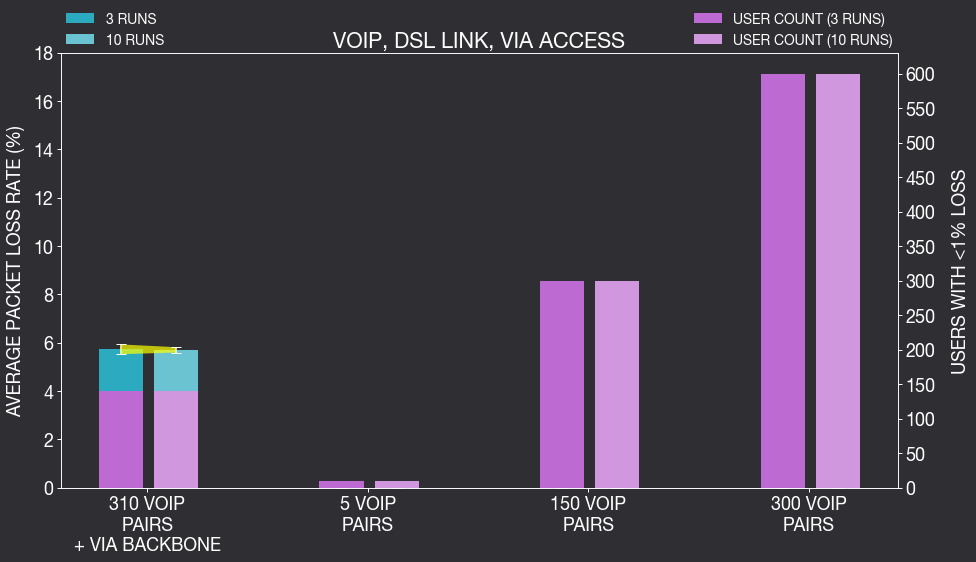

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from matplotlib import style
import math
import decimal
import statistics
from scipy import stats
import os

path = os.getcwd()

#1: path+'/New_results/VOIP_DSL_rpt03_scenario_10_MIXED_PK_Loss_Rate.csv',
#                 2: path+'/New_results/VOIP_DSL_rpt03_scenario_03_PAIRS_300_PK_Loss_Rate.csv',
#                 3: path+'/New_results/VOIP_DSL_rpt03_scenario_03_PAIRS_150_PK_Loss_Rate.csv',
#                 4: path+'/New_results/VOIP_DSL_rpt03_scenario_03_PAIRS_5_PK_Loss_Rate.csv',
#                 5: path+'/New_results/VOIP_DSL_rpt10_scenario_10_MIXED_PK_Loss_Rate.csv',
#                 6: path+'/New_results/VOIP_DSL_rpt10_scenario_03_PAIRS_300_PK_Loss_Rate.csv',
#                 7: path+'/New_results/VOIP_DSL_rpt10_scenario_03_PAIRS_150_PK_Loss_Rate.csv',
#                 8: path+'/New_results/VOIP_DSL_rpt10_scenario_03_PAIRS_5_PK_Loss_Rate.csv'

class Result_Analysis():
        
    def read_file(self, file_number):
        dict_ = {1: path+'/New_results/VOIP_DSL_rpt03_scenario_10_MIXED_PK_Loss_Rate.csv',
                 2: path+'/New_results/VOIP_DSL_rpt03_scenario_03_PAIRS_5_PK_Loss_Rate.csv',
                 3: path+'/New_results/VOIP_DSL_rpt03_scenario_03_PAIRS_150_PK_Loss_Rate.csv',
                 4: path+'/New_results/VOIP_DSL_rpt03_scenario_03_PAIRS_300_PK_Loss_Rate.csv',
                 5: path+'/New_results/VOIP_DSL_rpt10_scenario_10_MIXED_PK_Loss_Rate.csv',
                 6: path+'/New_results/VOIP_DSL_rpt10_scenario_03_PAIRS_5_PK_Loss_Rate.csv',
                 7: path+'/New_results/VOIP_DSL_rpt10_scenario_03_PAIRS_150_PK_Loss_Rate.csv',
                 8: path+'/New_results/VOIP_DSL_rpt10_scenario_03_PAIRS_300_PK_Loss_Rate.csv'
                }
        cols = ['run', 'timelimit', 'repetition', 'Module', 'Name', 'Avg_Loss_Rate']
        data = pd.read_csv(dict_[file_number], delimiter=',', skiprows=[0], names=cols)

        data = data.dropna()
        data = data.reset_index(drop=True)
        df = pd.DataFrame(data)
        
        avgPKL_1000s_arr = []
        avgPKL_user_count = 0

        for i in range(len(data)):
            if (df['timelimit'][i] == 1000):
                avgPKL_1000s_arr.append(df['Avg_Loss_Rate'][i]*100)
                
        for i in range(len(data)):
            if (df['Avg_Loss_Rate'][i] < 0.01):
                avgPKL_user_count += 1
           
        array = {'array_1000': avgPKL_1000s_arr}
        count = avgPKL_user_count
        return array, count
    
    def SampleStDev(self, arr):
        sample_stdev = []
        for key, value in arr.items():
            sample_stdev.append(statistics.stdev(value))
        return sample_stdev
    
    def sampleMean(self, arr):
        sample_mean = []
        for key, value in arr.items():
            sample_mean.append(statistics.mean(value))
        return sample_mean
    
    #  We assume we know the population standard deviation. For n <= 30, use T-Score. For n > 30, use Z-Score.
    #  we assume two sided t-value for normal distribution and degree freedom is one less than the length of the array.
    def tScore(self, conf, arr):
        t_scores = []
        for inner_array in arr.values():
            t_scores.append(stats.t.ppf((conf + 1) / 2, len(inner_array)-1)) 
        return t_scores


    def confInterval_t(self, arr, sample_mean, sample_stdev, t_scores):
        for inner_array in arr.values():
            length = len(inner_array)
        
        upper_t = list((x+y for x,y in zip(sample_mean, 
                                           (a*b/math.sqrt(length) for a,b in zip(t_scores, sample_stdev)))))
        lower_t = list((x-y for x,y in zip(sample_mean, 
                                           (a*b/math.sqrt(length) for a,b in zip(t_scores, sample_stdev)))))
        
        return lower_t, upper_t
    
    def confInterval_z(self, con_coef, arr, sample_mean, sample_stdev):
        z_interval_l, z_interval_r = stats.norm.interval(con_coef)
        for inner_array in arr.values():
            length = len(inner_array)
            
        lower_z = list(x + y for x, y in zip(sample_mean, 
                                              (z_interval_l*element/ math.sqrt(length) for element in sample_stdev)))
        upper_z = list(x + y for x, y in zip(sample_mean, 
                                              (z_interval_r*element/ math.sqrt(length) for element in sample_stdev)))
        
        return lower_z, upper_z


run = True
while run:
    try:
        confidence_interval = float(input("\nPlease enter the desired confidence interval: "))
        if confidence_interval >= 1 or 0 >= confidence_interval:
            raise Exception 
                   
    except:
        print("Please enter a valid number from [0, 1)!")
        
    else:
        mean_dict = {}
        t_dict = {}
        z_dict = {}
        user_count_arr = []
        for number in range(1,9):
            file_number = number
            
            obj = Result_Analysis()
            array, count = obj.read_file(file_number)
            user_count_arr.append(count)
            mean = obj.sampleMean(array)
            mean_dict[number] = mean
            
            stdev = obj.SampleStDev(array)
            tscore = obj.tScore(confidence_interval, array)

            t_score_l, t_score_r = obj.confInterval_t(array, mean, stdev, tscore)
            t_dict[number] = [(x,y) for x,y in zip(t_score_l, t_score_r)]
            
            z_score_l, z_score_r = obj.confInterval_z(confidence_interval, array, mean, stdev)
            z_dict[number] = [(x,y) for x,y in zip(z_score_l, z_score_r)]
        
        #Plot the data
            
        # width of the bars
        barWidth = 0.2
        
        # Choose the height of the bars
        bars_count_rpt03 = [math.ceil(user_count_arr[index]/3) for index, value in enumerate(user_count_arr) if index <= 3]
        bars_count_rpt10 = [math.ceil(user_count_arr[index]/10) for index, value in enumerate(user_count_arr) if index > 3]
        
        bars_1000s_rpt03 = [mean_dict[i][0] for i in mean_dict if i <= 4]
        bars_1000s_rpt10 = [mean_dict[i][0] for i in mean_dict if i > 4]
        
        # Upper and lower limits for confidence interval (error bars) used for fill_between method
        yer_1000s_l_rpt03 = [t_dict[1][0][0], t_dict[2][0][0], t_dict[3][0][0], t_dict[4][0][0]]
                       
        yer_1000s_u_rpt03 = [t_dict[1][0][1], t_dict[2][0][1], t_dict[3][0][1], t_dict[4][0][1]]
        
        yer_1000s_l_rpt10 = [t_dict[5][0][0], t_dict[6][0][0], t_dict[7][0][0], t_dict[8][0][0]]
        
        yer_1000s_u_rpt10 = [t_dict[5][0][1], t_dict[6][0][1], t_dict[7][0][1], t_dict[8][0][1]]
                
        # Choose the height of the confidence interval (error bars) for errorbar method
        yer_1000s_rpt03 = [(u - l)/2 for u, l in zip(yer_1000s_u_rpt03, yer_1000s_l_rpt03)]
        yer_1000s_rpt10 = [(u - l)/2 for u, l in zip(yer_1000s_u_rpt10, yer_1000s_l_rpt10)]
        
        # The x position of bars
        r_1000s_rpt03 = np.arange(len(bars_1000s_rpt03))
        r_1000s_rpt10 = [x + barWidth + .05 for x in r_1000s_rpt03]

        #Parameter setting for plotting
        #plt.rcParams['axes.edgecolor']='#333F4B'
        plt.rcParams['axes.linewidth']=0.8
        plt.rcParams['xtick.color']='#FFFFFF'
        #plt.rcParams['ytick.color']='#333F4B'
        plt.rcParams.update({'font.size': 18})
        plt.rcParams["legend.edgecolor"] = 'inherit'
        plt.rcParams["axes.edgecolor"] = 'white'
        plt.rcParams["legend.facecolor"] = 'inherit'
        plt.rcParams["axes.facecolor"] = 'white'
        plt.rcParams["font.family"] = 'serif'
        plt.rcParams['font.serif'] = 'Helvetica Neue'
        
        fig, ax1 = plt.subplots(figsize=(15, 8), facecolor = (0.18, 0.18, 0.2))
        ax1.set_facecolor((0.18, 0.18, 0.2))
        ax2 = ax1.twinx()
        
        # Create 1000s_rpt03 bars
        ax1.bar(r_1000s_rpt03, bars_1000s_rpt03, width = barWidth, color = '#2CAAC0', label='3 RUNS')
        ax1.errorbar(r_1000s_rpt03, bars_1000s_rpt03, yerr=yer_1000s_rpt03, color = 'white', capthick=1, capsize=5, fmt=' ')
        
        # Create 1000s_rpt10 bars
        ax1.bar(r_1000s_rpt10, bars_1000s_rpt10, width = barWidth, color = '#6BC3D2', label='10 RUNS')
        ax1.errorbar(r_1000s_rpt10, bars_1000s_rpt10, yerr=yer_1000s_rpt10, color = 'white', capthick=1, capsize=5, fmt=' ')
        
        r_pairs = [[x, y] for x,y in zip(r_1000s_rpt03, r_1000s_rpt10)]
        yer_l = [[x,y] for x,y in zip(yer_1000s_l_rpt03, yer_1000s_l_rpt10)]
        yer_u = [[x,y] for x,y in zip(yer_1000s_u_rpt03, yer_1000s_u_rpt10)]
        
        for i in range(len(r_pairs)):
            ax1.fill_between(r_pairs[i], yer_l[i], yer_u[i], facecolor='yellow', alpha=0.7, zorder=2)
        
        ax2.bar(r_1000s_rpt03, bars_count_rpt03, width = barWidth, color = '#BD6BD2', label='USER COUNT (3 RUNS)')
        ax2.bar(r_1000s_rpt10, bars_count_rpt10, width = barWidth, color = '#D097DF', label='USER COUNT (10 RUNS)')
        
        
        labels = ['310 VOIP\nPAIRS\n+ VIA BACKBONE','5 VOIP\nPAIRS','150 VOIP\nPAIRS','300 VOIP\nPAIRS']
        x = np.arange(len(labels))  # the label locations
        ax1.set_xticks(x+0.12)
        ax1.set_xticklabels(labels ,color = '#FFFFFF')
        ax1.tick_params(direction='out', length=4, width=1, colors='w')
        
        ax1.set_yticks(np.arange(0.0, 20.0, 2.0))
        ax1.set_ylabel('AVERAGE PACKET LOSS RATE (%)', labelpad=8, color = '#FFFFFF')
        
        ax2.set_yticks(np.arange(0, 650, 50))
        ax2.tick_params(direction='out', length=4, width=1, colors='w')
        ax2.set_ylabel('USERS WITH <1% LOSS', labelpad=16, color = '#FFFFFF')
        ax1.set_title('VOIP, DSL LINK, VIA ACCESS', color = '#FFFFFF')
        
        leg1 = ax1.legend(fontsize = 14, loc='lower left', bbox_to_anchor= (0.0, 1.0), ncol=1, borderaxespad=0, frameon=False)
        leg2 = ax2.legend(fontsize = 14, loc='lower right', bbox_to_anchor= (1.0, 1.0), ncol=1, borderaxespad=0, frameon=False)
        for text in leg1.get_texts():
            text.set_color("white")
        for text in leg2.get_texts():
            text.set_color("white")
        
        plt.show()
        
        #print(f'\n\n\nCI based on T-score: \n{t_dict}')
        #print(f'\n\n\nCI based on Z-score: \n{z_dict}')
        #print(f'\n\n\nMean:{mean_dict}')
        
        run = False 

<center><h1>VOIP WITH DSL CONNECTION (SCENARIO 03)</h1></center>


Please enter the desired confidence interval: .95


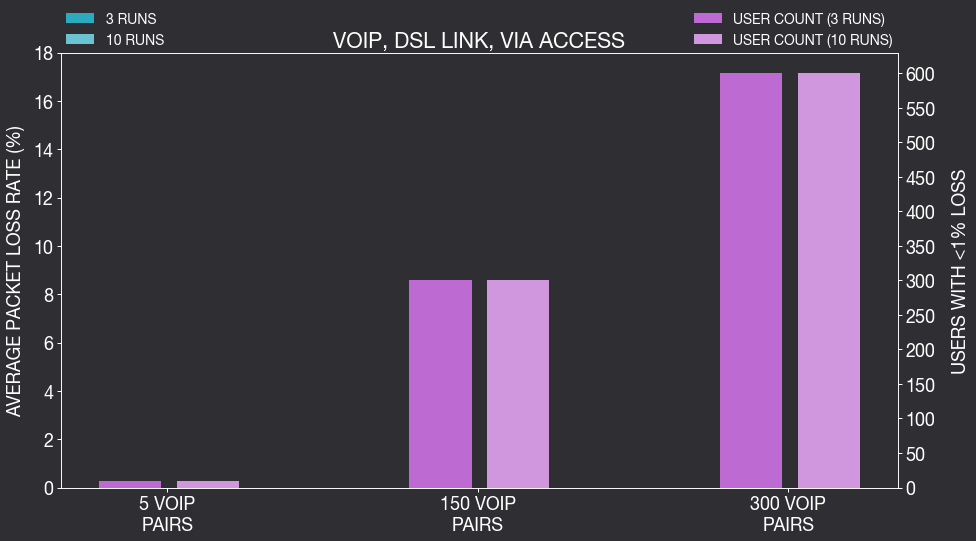

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from matplotlib import style
import math
import decimal
import statistics
from scipy import stats
import os

path = os.getcwd()

#1: path+'/New_results/VOIP_DSL_rpt03_scenario_10_MIXED_PK_Loss_Rate.csv',
#                 2: path+'/New_results/VOIP_DSL_rpt03_scenario_03_PAIRS_300_PK_Loss_Rate.csv',
#                 3: path+'/New_results/VOIP_DSL_rpt03_scenario_03_PAIRS_150_PK_Loss_Rate.csv',
#                 4: path+'/New_results/VOIP_DSL_rpt03_scenario_03_PAIRS_5_PK_Loss_Rate.csv',
#                 5: path+'/New_results/VOIP_DSL_rpt10_scenario_10_MIXED_PK_Loss_Rate.csv',
#                 6: path+'/New_results/VOIP_DSL_rpt10_scenario_03_PAIRS_300_PK_Loss_Rate.csv',
#                 7: path+'/New_results/VOIP_DSL_rpt10_scenario_03_PAIRS_150_PK_Loss_Rate.csv',
#                 8: path+'/New_results/VOIP_DSL_rpt10_scenario_03_PAIRS_5_PK_Loss_Rate.csv'

class Result_Analysis():
        
    def read_file(self, file_number):
        dict_ = {1: path+'/New_results/VOIP_DSL_rpt03_scenario_03_PAIRS_5_PK_Loss_Rate.csv',
                 2: path+'/New_results/VOIP_DSL_rpt03_scenario_03_PAIRS_150_PK_Loss_Rate.csv',
                 3: path+'/New_results/VOIP_DSL_rpt03_scenario_03_PAIRS_300_PK_Loss_Rate.csv',
                 4: path+'/New_results/VOIP_DSL_rpt10_scenario_03_PAIRS_5_PK_Loss_Rate.csv',
                 5: path+'/New_results/VOIP_DSL_rpt10_scenario_03_PAIRS_150_PK_Loss_Rate.csv',
                 6: path+'/New_results/VOIP_DSL_rpt10_scenario_03_PAIRS_300_PK_Loss_Rate.csv'
                }
        cols = ['run', 'timelimit', 'repetition', 'Module', 'Name', 'Avg_Loss_Rate']
        data = pd.read_csv(dict_[file_number], delimiter=',', skiprows=[0], names=cols)

        data = data.dropna()
        data = data.reset_index(drop=True)
        df = pd.DataFrame(data)
        
        avgPKL_1000s_arr = []
        avgPKL_user_count = 0

        for i in range(len(data)):
            if (df['timelimit'][i] == 1000):
                avgPKL_1000s_arr.append(df['Avg_Loss_Rate'][i]*100)
                
        for i in range(len(data)):
            if (df['Avg_Loss_Rate'][i] < 0.01):
                avgPKL_user_count += 1
           
        array = {'array_1000': avgPKL_1000s_arr}
        count = avgPKL_user_count
        return array, count
    
    def SampleStDev(self, arr):
        sample_stdev = []
        for key, value in arr.items():
            sample_stdev.append(statistics.stdev(value))
        return sample_stdev
    
    def sampleMean(self, arr):
        sample_mean = []
        for key, value in arr.items():
            sample_mean.append(statistics.mean(value))
        return sample_mean
    
    #  We assume we know the population standard deviation. For n <= 30, use T-Score. For n > 30, use Z-Score.
    #  we assume two sided t-value for normal distribution and degree freedom is one less than the length of the array.
    def tScore(self, conf, arr):
        t_scores = []
        for inner_array in arr.values():
            t_scores.append(stats.t.ppf((conf + 1) / 2, len(inner_array)-1)) 
        return t_scores


    def confInterval_t(self, arr, sample_mean, sample_stdev, t_scores):
        for inner_array in arr.values():
            length = len(inner_array)
        
        upper_t = list((x+y for x,y in zip(sample_mean, 
                                           (a*b/math.sqrt(length) for a,b in zip(t_scores, sample_stdev)))))
        lower_t = list((x-y for x,y in zip(sample_mean, 
                                           (a*b/math.sqrt(length) for a,b in zip(t_scores, sample_stdev)))))
        
        return lower_t, upper_t
    
    def confInterval_z(self, con_coef, arr, sample_mean, sample_stdev):
        z_interval_l, z_interval_r = stats.norm.interval(con_coef)
        for inner_array in arr.values():
            length = len(inner_array)
            
        lower_z = list(x + y for x, y in zip(sample_mean, 
                                              (z_interval_l*element/ math.sqrt(length) for element in sample_stdev)))
        upper_z = list(x + y for x, y in zip(sample_mean, 
                                              (z_interval_r*element/ math.sqrt(length) for element in sample_stdev)))
        
        return lower_z, upper_z


run = True
while run:
    try:
        confidence_interval = float(input("\nPlease enter the desired confidence interval: "))
        if confidence_interval >= 1 or 0 >= confidence_interval:
            raise Exception 
                   
    except:
        print("Please enter a valid number from [0, 1)!")
        
    else:
        mean_dict = {}
        t_dict = {}
        z_dict = {}
        user_count_arr = []
        for number in range(1,7):
            file_number = number
            
            obj = Result_Analysis()
            array, count = obj.read_file(file_number)
            user_count_arr.append(count)
            mean = obj.sampleMean(array)
            mean_dict[number] = mean
            
            stdev = obj.SampleStDev(array)
            tscore = obj.tScore(confidence_interval, array)

            t_score_l, t_score_r = obj.confInterval_t(array, mean, stdev, tscore)
            t_dict[number] = [(x,y) for x,y in zip(t_score_l, t_score_r)]
            
            z_score_l, z_score_r = obj.confInterval_z(confidence_interval, array, mean, stdev)
            z_dict[number] = [(x,y) for x,y in zip(z_score_l, z_score_r)]
        
        #Plot the data
            
        # width of the bars
        barWidth = 0.2
        
        # Choose the height of the bars
        bars_count_rpt03 = [math.ceil(user_count_arr[index]/3) for index, value in enumerate(user_count_arr) if index <= 2]
        bars_count_rpt10 = [math.ceil(user_count_arr[index]/10) for index, value in enumerate(user_count_arr) if index > 2]
        
        bars_1000s_rpt03 = [mean_dict[i][0] for i in mean_dict if i <= 3]
        bars_1000s_rpt10 = [mean_dict[i][0] for i in mean_dict if i > 3]
        
        # Upper and lower limits for confidence interval (error bars) used for fill_between method
        yer_1000s_l_rpt03 = [t_dict[1][0][0], t_dict[2][0][0], t_dict[3][0][0]]
                       
        yer_1000s_u_rpt03 = [t_dict[1][0][1], t_dict[2][0][1], t_dict[3][0][1]]
        
        yer_1000s_l_rpt10 = [t_dict[4][0][0], t_dict[5][0][0], t_dict[6][0][0]]
        
        yer_1000s_u_rpt10 = [t_dict[4][0][1], t_dict[5][0][1], t_dict[6][0][1]]
                
        # Choose the height of the confidence interval (error bars) for errorbar method
        yer_1000s_rpt03 = [(u - l)/2 for u, l in zip(yer_1000s_u_rpt03, yer_1000s_l_rpt03)]
        yer_1000s_rpt10 = [(u - l)/2 for u, l in zip(yer_1000s_u_rpt10, yer_1000s_l_rpt10)]
        
        # The x position of bars
        r_1000s_rpt03 = np.arange(len(bars_1000s_rpt03))
        r_1000s_rpt10 = [x + barWidth + .05 for x in r_1000s_rpt03]

        #Parameter setting for plotting
        #plt.rcParams['axes.edgecolor']='#333F4B'
        plt.rcParams['axes.linewidth']=0.8
        plt.rcParams['xtick.color']='#FFFFFF'
        #plt.rcParams['ytick.color']='#333F4B'
        plt.rcParams.update({'font.size': 18})
        plt.rcParams["legend.edgecolor"] = 'inherit'
        plt.rcParams["axes.edgecolor"] = 'white'
        plt.rcParams["legend.facecolor"] = 'inherit'
        plt.rcParams["axes.facecolor"] = 'white'
        plt.rcParams["font.family"] = 'serif'
        plt.rcParams['font.serif'] = 'Helvetica Neue'
        
        fig, ax1 = plt.subplots(figsize=(15, 8), facecolor = (0.18, 0.18, 0.2))
        ax1.set_facecolor((0.18, 0.18, 0.2))
        ax2 = ax1.twinx()
        
        # Create 1000s_rpt03 bars
        ax1.bar(r_1000s_rpt03, bars_1000s_rpt03, width = barWidth, color = '#2CAAC0', label='3 RUNS')
        ax1.errorbar(r_1000s_rpt03, bars_1000s_rpt03, yerr=yer_1000s_rpt03, color = 'white', capthick=1, capsize=5, fmt=' ')
        
        # Create 1000s_rpt10 bars
        ax1.bar(r_1000s_rpt10, bars_1000s_rpt10, width = barWidth, color = '#6BC3D2', label='10 RUNS')
        ax1.errorbar(r_1000s_rpt10, bars_1000s_rpt10, yerr=yer_1000s_rpt10, color = 'white', capthick=1, capsize=5, fmt=' ')
        
        r_pairs = [[x, y] for x,y in zip(r_1000s_rpt03, r_1000s_rpt10)]
        yer_l = [[x,y] for x,y in zip(yer_1000s_l_rpt03, yer_1000s_l_rpt10)]
        yer_u = [[x,y] for x,y in zip(yer_1000s_u_rpt03, yer_1000s_u_rpt10)]
        
        for i in range(len(r_pairs)):
            ax1.fill_between(r_pairs[i], yer_l[i], yer_u[i], facecolor='yellow', alpha=0.7, zorder=2)
        
        ax2.bar(r_1000s_rpt03, bars_count_rpt03, width = barWidth, color = '#BD6BD2', label='USER COUNT (3 RUNS)')
        ax2.bar(r_1000s_rpt10, bars_count_rpt10, width = barWidth, color = '#D097DF', label='USER COUNT (10 RUNS)')
        
        
        labels = ['5 VOIP\nPAIRS','150 VOIP\nPAIRS','300 VOIP\nPAIRS']
        x = np.arange(len(labels))  # the label locations
        ax1.set_xticks(x+0.12)
        ax1.set_xticklabels(labels ,color = '#FFFFFF')
        ax1.tick_params(direction='out', length=4, width=1, colors='w')
        
        ax1.set_yticks(np.arange(0.0, 20.0, 2.0))
        ax1.set_ylabel('AVERAGE PACKET LOSS RATE (%)', labelpad=8, color = '#FFFFFF')
        
        ax2.set_yticks(np.arange(0, 650, 50))
        ax2.tick_params(direction='out', length=4, width=1, colors='w')
        ax2.set_ylabel('USERS WITH <1% LOSS', labelpad=16, color = '#FFFFFF')
        ax1.set_title('VOIP, DSL LINK, VIA ACCESS', color = '#FFFFFF')
        
        leg1 = ax1.legend(fontsize = 14, loc='lower left', bbox_to_anchor= (0.0, 1.0), ncol=1, borderaxespad=0, frameon=False)
        leg2 = ax2.legend(fontsize = 14, loc='lower right', bbox_to_anchor= (1.0, 1.0), ncol=1, borderaxespad=0, frameon=False)
        for text in leg1.get_texts():
            text.set_color("white")
        for text in leg2.get_texts():
            text.set_color("white")
        
        plt.show()
        
        #print(f'\n\n\nCI based on T-score: \n{t_dict}')
        #print(f'\n\n\nCI based on Z-score: \n{z_dict}')
        #print(f'\n\n\nMean:{mean_dict}')
        
        run = False 

<center><h1>VC Packet Loss Rate Analysis</h1></center>


Please enter the desired confidence interval: .95
[(4.432330908281386, 4.585269091718613), (0.11462777520554872, 0.12137222479445127), (1.902716370839154, 2.0308836291608463)]
[[ 9.128 12.08   0.116]
 [ 9.052 11.852  0.124]
 [ 9.972 11.68   0.124]
 [ 9.508 12.004  0.12 ]
 [ 9.016 12.152  0.124]
 [ 9.512 11.968  0.12 ]
 [ 9.192 11.912  0.124]
 [ 9.588 11.812  0.112]
 [ 9.08  11.84   0.124]
 [ 9.376 11.8    0.124]]
[[4.58  0.12  2.056]
 [4.552 0.12  2.016]
 [4.396 0.112 1.856]
 [4.452 0.116 1.896]
 [4.36  0.128 1.892]
 [4.676 0.116 1.876]
 [4.54  0.116 1.996]
 [4.584 0.12  2.112]
 [4.576 0.112 1.92 ]
 [4.372 0.12  2.048]]


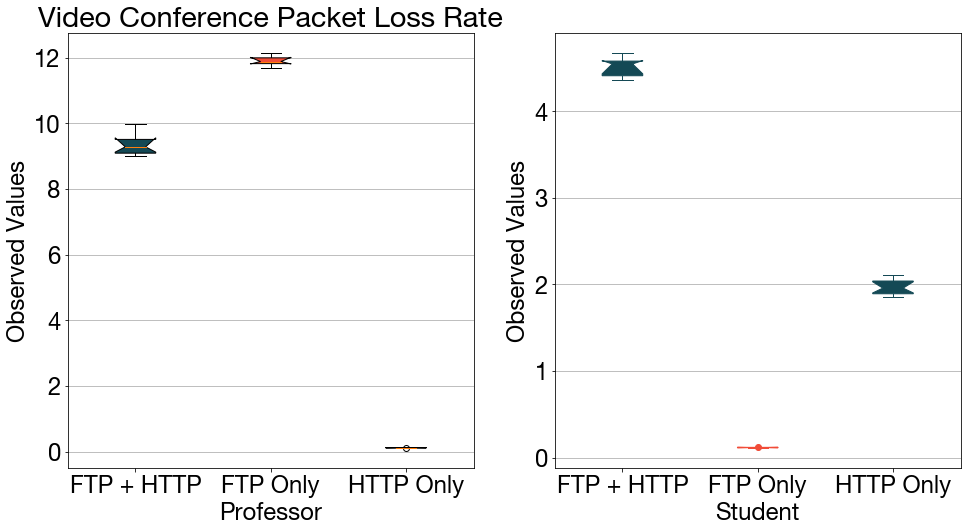

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from matplotlib import style
import math
import decimal
import statistics
from scipy import stats
import os

path = os.getcwd()

class Result_Analysis():
        
    def read_file(self, file_number):# UPDATE file names to plot
        dict_ = {1: path+'/Sim_Results/VC_with_FTP_and_HTTP_AVG_PK_LOSS_Rate.csv',
                 2: path+'/Sim_Results/VC_with_FTP_Only_AVG_PK_LOSS_Rate.csv',
                 3: path+'/Sim_Results/VC_with_HTTP_Only_AVG_PK_LOSS_Rate.csv'
                }
        cols = ['run', 'timelimit', 'repetition', 'Module', 'Name', 'Avg_Loss_Rate']
        data = pd.read_csv(dict_[file_number], delimiter=',', skiprows=[0], names=cols)

        data = data.dropna()
        data = data.reset_index(drop=True)
        df = pd.DataFrame(data)
        
        Professor_avgPKL_1000s_arr = []
        Student_avgPKL_1000s_arr = []
        
        for i in range(len(data)): # UPDATE number of seconds
            if (df['timelimit'][i] == 1000 and 'Professor' in df['Module'][i]):
                Professor_avgPKL_1000s_arr.append(df['Avg_Loss_Rate'][i]*100) # Convert to percent
            elif (df['timelimit'][i] == 1000 and 'Student' in df['Module'][i]):
                Student_avgPKL_1000s_arr.append(df['Avg_Loss_Rate'][i]*100) # Convert to percent
           
        dict_array = {'Professor': Professor_avgPKL_1000s_arr, 'Student': Student_avgPKL_1000s_arr}
        return dict_array
    
    def SampleStDev(self, arr):
        sample_stdev = [] # [P_stdev, S_stdev]
        for key, value in arr.items():
            sample_stdev.append(statistics.stdev(value))
        return sample_stdev
    
    def sampleMean(self, arr):
        sample_mean = [] # [P_mean, S_mean]
        for key, value in arr.items():
            sample_mean.append(statistics.mean(value))
        return sample_mean
    
    #  We assume we know the population standard deviation. For n <= 30, use T-Score. For n > 30, use Z-Score.
    #  we assume two sided t-value for normal distribution and degree freedom is one less than the length of the array.
    def tScore(self, conf, arr):
        t_scores = [] # [P_t-score, S_t-score]
        for inner_array in arr.values(): # {[P1, P2, ...],[S1, S2, ...]}
            t_scores.append(stats.t.ppf((conf + 1) / 2, len(inner_array)-1)) 
        return t_scores


    def confInterval_t(self, arr, sample_mean, sample_stdev, t_scores):
        for inner_array in arr.values():
            length = len(inner_array)
        
        upper_t = list((x+y for x,y in zip(sample_mean, 
                                           (a*b/math.sqrt(length) for a,b in zip(t_scores, sample_stdev)))))
        lower_t = list((x-y for x,y in zip(sample_mean, 
                                           (a*b/math.sqrt(length) for a,b in zip(t_scores, sample_stdev)))))
        
        return lower_t, upper_t
    
    def confInterval_z(self, con_coef, arr, sample_mean, sample_stdev):
        z_interval_l, z_interval_r = stats.norm.interval(con_coef)
        for inner_array in arr.values():
            length = len(inner_array)
            
        lower_z = list(x + y for x, y in zip(sample_mean, 
                                              (z_interval_l*element/ math.sqrt(length) for element in sample_stdev)))
        upper_z = list(x + y for x, y in zip(sample_mean, 
                                              (z_interval_r*element/ math.sqrt(length) for element in sample_stdev)))
        
        return lower_z, upper_z

run = True
while run:
    try:
        confidence_interval = float(input("\nPlease enter the desired confidence interval: "))
        if confidence_interval >= 1 or 0 >= confidence_interval:
            raise Exception 
                   
    except:
        print("Please enter a valid number from [0, 1)!")
        
    else:
        data_dict = {}
        mean_dict = {}
        t_dict = {}
        z_dict = {}
        
        for number in range(1,4): # UPDATE number based on number of files + 1
            file_number = number
            
            obj = Result_Analysis()
            dict_array = obj.read_file(file_number) # Returns array with 1st and 2nd value of Prof and Stud, respectively
            #print(dict_array)
            data_dict[number] = dict_array
            
            mean = obj.sampleMean(dict_array) # Returns array with 1st and 2nd value of Prof and Stud, respectively
            mean_dict[number] = mean #{1: [P_mean_1, S_mean_1], 2: [P2, S2], 3: [P3,S3]}
            
            stdev = obj.SampleStDev(dict_array) # Returns array with 1st and 2nd value of Prof and Stud, respectively
            tscore = obj.tScore(confidence_interval, dict_array)

            t_score_l, t_score_u = obj.confInterval_t(dict_array, mean, stdev, tscore)
            t_dict[number] = [(x,y) for x,y in zip(t_score_l, t_score_u)]
            
            z_score_l, z_score_u = obj.confInterval_z(confidence_interval, dict_array, mean, stdev)
            z_dict[number] = [(x,y) for x,y in zip(z_score_l, z_score_u)]
        
        #Plot the data
        #print(mean_dict)
        # width of the bars
        #barWidth = 0.2
        
        ## Choose the height of the bars
        ##bars_count_rpt03 = [math.ceil(user_count_arr[index]/3) for index, value in enumerate(user_count_arr) if index <= 3]
        ##bars_count_rpt10 = [math.ceil(user_count_arr[index]/10) for index, value in enumerate(user_count_arr) if index > 3]
        
        # UPDATE condition for i
        professor_data = [mean_dict[i][0] for i in mean_dict if i <= 3]
        student_data = [mean_dict[i][1] for i in mean_dict if i <= 3]
        
        # UPDATE condition for i
        professor_CI_l = [t_dict[i][0][0] for i in t_dict if i <= 3]
        professor_CI_u = [t_dict[i][0][1] for i in t_dict if i <= 3]

        professor_CI = [i for i in zip(professor_CI_l, professor_CI_u)]
        
        # UPDATE condition for i
        student_CI_l = [t_dict[i][1][0] for i in t_dict if i <= 3]
        student_CI_u = [t_dict[i][1][1] for i in t_dict if i <= 3]
        
        student_CI = [i for i in zip(student_CI_l, student_CI_u)]
        
        print(student_CI)
        
        # Parameter setting for plotting
        plt.rcParams['axes.edgecolor']='#000000'
        plt.rcParams['axes.linewidth']=0.8
        plt.rcParams['xtick.color']='#000000'
        plt.rcParams['ytick.color']='#000000'
        plt.rcParams.update({'font.size': 24})
        plt.rcParams["legend.edgecolor"] = 'inherit'
        plt.rcParams["axes.edgecolor"] = 'black'
        plt.rcParams["legend.facecolor"] = 'inherit'
        plt.rcParams["axes.facecolor"] = 'black'
        plt.rcParams["font.family"] = 'serif'
        plt.rcParams['font.serif'] = 'Helvetica Neue'
        
        # And finally plot the cdf
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8), facecolor = (1, 1, 1))
        
        # Create Notch Box Plots
        # Professor File Number 1
        #print(data_dict)
        #print(t_dict[1][0][0],t_dict[1][0][1])
        
        professor_arr = []
        student_arr = []
        for number, dict_ in data_dict.items():
            for key, arr in dict_.items():
                if(key is 'Professor'):
                    professor_arr.append(arr)
                if(key is 'Student'):
                    student_arr.append(arr)
        all_professor_data = np.array(professor_arr,order='C').T
        all_student_data = np.array(student_arr,order='C').T
        
        print(all_professor_data)
        print(all_student_data)
        
        labels = ['FTP + HTTP','FTP Only', 'HTTP Only']
        
        # notch shape box plot
        bplot1 = axes[0].boxplot(all_professor_data,
                                 notch=True,  # notch shape
                                 vert=True,  # vertical box alignment
                                 patch_artist=True,  # fill with color
                                 conf_intervals=professor_CI, # calculated CIs
                                 labels=labels)  # will be used to label x-ticks
        axes[0].set_title('Video Conference Packet Loss Rate', color = '#000000')
        axes[0].set_xlabel('Professor')
        
        # notch shape box plot
        bplot2 = axes[1].boxplot(all_student_data,
                                 notch=True,  # notch shape
                                 vert=True,  # vertical box alignment
                                 patch_artist=True,  # fill with color
                                 conf_intervals=student_CI, # calculated CIs
                                 labels=labels)  # will be used to label x-ticks
        axes[1].set_title('Video Conference Packet Loss Rate', color = '#000000')
        axes[1].set_xlabel('Student')

        # fill with colors
        # Professor color: #2a8ba7FF
        # Student color: #144955FF
        # FTP Upload Student color: #F14c38FF
        # HTTP client color: #50c878FF
        
        colors = ['#144955', '#F14C38', '#144955']
        for bplot in (bplot1, bplot2):
            for patch, color in zip(bplot['boxes'], colors):
                patch.set_facecolor(color)

        # adding horizontal grid lines
        for ax in axes:
            ax.yaxis.grid(True)
            ax.set_facecolor((1, 1, 1))
            ax.set_ylabel('Observed Values')
        
        for i, artist in enumerate(ax.artists):
            if i % 2 == 0:
                col = '#144955'
            else:
                col = '#F14C38'

            # This sets the color for the main box
            artist.set_edgecolor(col)
            # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
            # Loop over them here, and use the same colour as above
            for j in range(i*6,i*6+6):
                line = ax.lines[j]
                line.set_color(col)
                line.set_mfc(col)
                line.set_mec(col)
        
        # Add a horizontal grid to the plot, but make it very light in color
        # so we can use it for reading data values but not be distracting
        
        #ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
        #       alpha=0.5)

        # Hide these grid behind plot objects
        #ax1.set_axisbelow(True)
        
        #ax1.set_title('Video Conference Packet Loss Rate', color = '#000000')
        #ax1.set_xlabel('Professor', labelpad=8, color = '#000000')
        #ax1.set_ylabel('Average Packet Loss Rate', labelpad=8, color = '#000000')

        #
        #leg1 = plt.legend(fontsize = 20, loc='lower left', bbox_to_anchor= (0.84, 1.0), ncol=1, borderaxespad=0, frameon=False)
                
        #for text in leg1.get_texts():
        #    text.set_color("black")

            
        #ax1.boxplot(data_dict[1]['Professor'], notch=True)
        #ax1.bar(r_1000s_rpt03, bars_1000s_rpt03, width = barWidth, color = '#2CAAC0', label='3 RUNS')
        #ax1.errorbar(r_1000s_rpt03, bars_1000s_rpt03, yerr=yer_1000s_rpt03, color = 'white', capthick=1, capsize=5, fmt=' ')
        #
        ## Create 1000s_rpt10 bars
        #ax1.bar(r_1000s_rpt10, bars_1000s_rpt10, width = barWidth, color = '#6BC3D2', label='10 RUNS')
        #ax1.errorbar(r_1000s_rpt10, bars_1000s_rpt10, yerr=yer_1000s_rpt10, color = 'white', capthick=1, capsize=5, fmt=' ')
        #
        #r_pairs = [[x, y] for x,y in zip(r_1000s_rpt03, r_1000s_rpt10)]
        #yer_l = [[x,y] for x,y in zip(yer_1000s_l_rpt03, yer_1000s_l_rpt10)]
        #yer_u = [[x,y] for x,y in zip(yer_1000s_u_rpt03, yer_1000s_u_rpt10)]
        #
        #for i in range(len(r_pairs)):
        #    ax1.fill_between(r_pairs[i], yer_l[i], yer_u[i], facecolor='yellow', alpha=0.7, zorder=2)
        #
        ##ax2.bar(r_1000s_rpt03, bars_count_rpt03, width = barWidth, color = '#BD6BD2', label='USER COUNT (3 RUNS)')
        ##ax2.bar(r_1000s_rpt10, bars_count_rpt10, width = barWidth, color = '#D097DF', label='USER COUNT (10 RUNS)')
        #
        #
        #labels = ['5 PAIRS\n... ACCESS','300 PAIRS\n... ACCESS','300 PAIRS\n... BACKBONE', '300 PAIRS\n... GATEWAY']
        #x = np.arange(len(labels))  # the label locations
        #
        #ax1.set_xticklabels(labels ,color = '#FFFFFF')
        #ax1.tick_params(direction='out', length=4, width=1, colors='w')
        #
        #ax1.set_yticks(np.arange(0.0, 100.0, 10.0))
        #ax1.set_ylabel('AVERAGE PACKET LOSS RATE (%)', labelpad=8, color = '#FFFFFF')
        #
        ##ax2.set_yticks(np.arange(0, 300, 20))
        ##ax2.tick_params(direction='out', length=4, width=1, colors='w')
        ##ax2.set_ylabel('USERS WITH <1% LOSS', labelpad=16, color = '#FFFFFF')
        #ax1.set_title('VOIP, ISDN LINK, VIA...', color = '#FFFFFF')
        #
        #leg1 = ax1.legend(fontsize = 14, loc='lower left', bbox_to_anchor= (0.0, 1.0), ncol=1, borderaxespad=0, frameon=False)
        ##leg2 = ax2.legend(fontsize = 14, loc='lower right', bbox_to_anchor= (1.0, 1.0), ncol=1, borderaxespad=0, frameon=False)
        #for text in leg1.get_texts():
        #    text.set_color("white")
        ##for text in leg2.get_texts():
        ##    text.set_color("white")
        #
        #plt.show()
        #
        ##print(f'\n\n\nCI based on T-score: \n{t_dict}')
        ##print(f'\n\n\nCI based on Z-score: \n{z_dict}')
        ##print(f'\n\n\nMean:{mean_dict}')
        
        run = False 

In [70]:
data = np.random.uniform(9,10,size=50)

In [71]:
for num in data:
    print(num,sep="\n")

9.499574026423
9.228706618460105
9.468602261103868
9.520107008882603
9.972940059487492
9.731205924376727
9.7325978425345
9.408904388727152
9.433141435340435
9.239115987242245
9.446077589373601
9.585358399896771
9.309817824970871
9.928013386126963
9.8128144366079
9.063527916146167
9.241976215164032
9.101856335839303
9.730142236228513
9.668156037005323
9.8492965712868
9.740668508645786
9.445047201760515
9.912977882193516
9.535661993887073
9.563021396871719
9.168219721763021
9.176432954358004
9.104443000366825
9.17508426176343
9.071589829887799
9.033870961032328
9.073823835095233
9.389513139937673
9.47714256266364
9.744173315267515
9.163910409462506
9.54270986715551
9.887378166390118
9.911782706337103
9.322782959112608
9.90339964198116
9.894072267717734
9.552420737818856
9.668082490878815
9.199810995158003
9.072964942550332
9.532003330149337
9.94927870541336
9.866798853433812


<center><h1>ROUTER QUEUE LENGTH MAX + PACKET QUEUE OVERFLOW</h1></center>


Please enter the desired confidence interval: 0.95


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


[0.   0.25 0.5  0.75 1.   1.25 1.5  1.75]


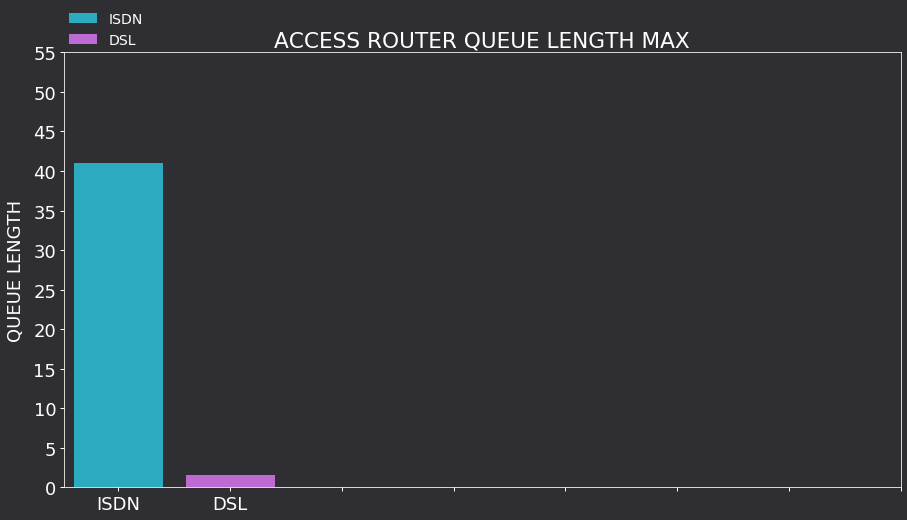

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from matplotlib import style
import math
import decimal
import statistics
from scipy import stats
import os


path = os.getcwd()
    
class Result_Analysis():
        
    def read_file(self, file_number):
        dict_ = {1: 'Queue_Length_ISDN_No_VoIP.csv',  #DISP,D,LISP,L QL Max
                 2: 'Queue_Length_DSL_No_VoIP.csv'
                }
        cols = ['run', 'timelimit', 'repetition', 'Module', 'QueueLength']
        data = pd.read_csv(dict_[file_number], delimiter=',', skiprows=[0], names=cols)

        data = data.dropna()
        data = data.reset_index(drop=True)
        df = pd.DataFrame(data)
        
        QL_1000s_arr = []

        for i in range(len(data)):
            if (df['timelimit'][i] == 1000):
                QL_1000s_arr.append(df['QueueLength'][i])
                           
        array = {'array_1000': QL_1000s_arr}
        return array
    
    def SampleStDev(self, arr):
        sample_stdev = []
        for key, value in arr.items():
            sample_stdev.append(statistics.stdev(value))
        return sample_stdev
    
    def sampleMean(self, arr):
        sample_mean = []
        for key, value in arr.items():
            sample_mean.append(statistics.mean(value))
        return sample_mean
    
    #  We assume we know the population standard deviation. For n <= 30, use T-Score. For n > 30, use Z-Score.
    #  we assume two sided t-value for normal distribution and degree freedom is one less than the length of the array.
    def tScore(self, conf, arr):
        t_scores = []
        for inner_array in arr.values():
            t_scores.append(stats.t.ppf((conf + 1) / 2, len(inner_array)-1)) 
        return t_scores


    def confInterval_t(self, arr, sample_mean, sample_stdev, t_scores):
        for inner_array in arr.values():
            length = len(inner_array)
        
        upper_t = list((x+y for x,y in zip(sample_mean, 
                                           (a*b/math.sqrt(length) for a,b in zip(t_scores, sample_stdev)))))
        lower_t = list((x-y for x,y in zip(sample_mean, 
                                           (a*b/math.sqrt(length) for a,b in zip(t_scores, sample_stdev)))))
        
        return lower_t, upper_t
    
    def confInterval_z(self, con_coef, arr, sample_mean, sample_stdev):
        z_interval_l, z_interval_r = stats.norm.interval(con_coef)
        for inner_array in arr.values():
            length = len(inner_array)
            
        lower_z = list(x + y for x, y in zip(sample_mean, 
                                              (z_interval_l*element/ math.sqrt(length) for element in sample_stdev)))
        upper_z = list(x + y for x, y in zip(sample_mean, 
                                              (z_interval_r*element/ math.sqrt(length) for element in sample_stdev)))
        
        return lower_z, upper_z


run = True
while run:
    try:
        confidence_interval = float(input("\nPlease enter the desired confidence interval: "))
        if confidence_interval >= 1 or 0 >= confidence_interval:
            raise Exception 
                   
    except:
        print("Please enter a valid number from [0, 1)!")
        
    else:
        mean_dict = {}
        t_dict = {}
        z_dict = {}
        for number in range(1,3):
            file_number = number
            
            obj = Result_Analysis()
            array = obj.read_file(file_number)
            mean = obj.sampleMean(obj.read_file(file_number))
            mean_dict[number] = mean
            
            stdev = obj.SampleStDev(array)
            tscore = obj.tScore(confidence_interval, array)

            t_score_l, t_score_r = obj.confInterval_t(array, mean, stdev, tscore)
            t_dict[number] = [(x,y) for x,y in zip(t_score_l, t_score_r)]
            
            z_score_l, z_score_r = obj.confInterval_z(confidence_interval, array, mean, stdev)
            z_dict[number] = [(x,y) for x,y in zip(z_score_l, z_score_r)]
        
        #Plot the data
            
        # width of the bars
        barWidth = 0.2
        
        # Choose the height of the bars
        #bars_count_rpt03 = [math.ceil(user_count_arr[index]/3) for index, value in enumerate(user_count_arr) if index <= 3]
        #bars_count_rpt10 = [math.ceil(user_count_arr[index]/10) for index, value in enumerate(user_count_arr) if index > 3]
        
        bars_1000s_rpt03 = [mean_dict[1][0]]
        bars_1000s_rpt10 = [mean_dict[2][0]]
        
        # Upper and lower limits for confidence interval (error bars) used for fill_between method
        #yer_1000s_l_rpt03 = [t_dict[1][0][0]]
                       
        #yer_1000s_u_rpt03 = [t_dict[1][0][1]]
        
        #yer_1000s_l_rpt10 = [t_dict[2][0][0]]
        
        #yer_1000s_u_rpt10 = [t_dict[2][0][1]]
                
        # Choose the height of the confidence interval (error bars) for errorbar method
        #yer_1000s_rpt03 = [(u - l)/2 for u, l in zip(yer_1000s_u_rpt03, yer_1000s_l_rpt03)]
        #yer_1000s_rpt10 = [(u - l)/2 for u, l in zip(yer_1000s_u_rpt10, yer_1000s_l_rpt10)]
        
        # The x position of bars
        r_1000s_rpt03 = np.arange(len(bars_1000s_rpt03))
        r_1000s_rpt10 = [x + barWidth + .05 for x in r_1000s_rpt03]

        #Parameter setting for plotting
        plt.rcParams['axes.edgecolor']='#333F4B'
        plt.rcParams['axes.linewidth']=0.8
        plt.rcParams['xtick.color']='#FFFFFF'
        plt.rcParams['ytick.color']='#333F4B'
        plt.rcParams.update({'font.size': 18})
        plt.rcParams["legend.edgecolor"] = 'inherit'
        plt.rcParams["axes.edgecolor"] = 'white'
        plt.rcParams["legend.facecolor"] = 'inherit'
        plt.rcParams["axes.facecolor"] = 'white'
        plt.rcParams["font.family"] = 'serif'
        plt.rcParams['font.serif'] = 'Helvetica Neue'
        
        fig, ax1 = plt.subplots(figsize=(15, 8), facecolor = (0.18, 0.18, 0.2))
        ax1.set_facecolor((0.18, 0.18, 0.2))
        #ax2 = ax1.twinx()
        
        # Create 1000s_rpt03 bars
        ax1.bar(r_1000s_rpt03, bars_1000s_rpt03, width = barWidth, color = '#2CAAC0', label='ISDN')
        ax1.errorbar(r_1000s_rpt03, bars_1000s_rpt03, color = 'white', capthick=1, capsize=5, fmt=' ')
        
        # Create 1000s_rpt10 bars
        ax1.bar(r_1000s_rpt10, bars_1000s_rpt10, width = barWidth, color = '#BD6BD2', label='DSL')
        ax1.errorbar(r_1000s_rpt10, bars_1000s_rpt10, color = 'white', capthick=1, capsize=5, fmt=' ')
        
        #r_pairs = [[x, y] for x,y in zip(r_1000s_rpt03, r_1000s_rpt10)]
        #yer_l = [[x,y] for x,y in zip(yer_1000s_l_rpt03, yer_1000s_l_rpt10)]
        #yer_u = [[x,y] for x,y in zip(yer_1000s_u_rpt03, yer_1000s_u_rpt10)]
        
        #for i in range(len(r_pairs)):
        #    ax1.fill_between(r_pairs[i], yer_l[i], yer_u[i], facecolor='yellow', alpha=0.7, zorder=2)
        
        #ax2.bar(r_1000s_rpt03, bars_count_rpt03, width = barWidth, color = '#BD6BD2', label='USER COUNT (3 RUNS)')
        #ax2.bar(r_1000s_rpt10, bars_count_rpt10, width = barWidth, color = '#D097DF', label='USER COUNT (10 RUNS)')
        
        
        labels = ['ISDN','DSL']
        x = np.arange(len(labels), step=0.25)  # the label locations
        print(x)
        ax1.set_xticks(x)
        ax1.set_xticklabels(labels ,color = '#FFFFFF')
        ax1.tick_params(direction='out', length=4, width=1, colors='w')
        
        ax1.set_yticks(np.arange(0.0, 60.0, 5.0))
        ax1.set_ylabel('QUEUE LENGTH', labelpad=8, color = '#FFFFFF')
        
        #ax2.set_yticks(np.arange(0, 650, 50))
        #ax2.tick_params(direction='out', length=4, width=1, colors='w')
        #ax2.set_ylabel('USERS WITH <1% LOSS', labelpad=16, color = '#FFFFFF')
        ax1.set_title('ACCESS ROUTER QUEUE LENGTH MAX', color = '#FFFFFF')
        
        leg1 = ax1.legend(fontsize = 14, loc='lower left', bbox_to_anchor= (0.0, 1.0), ncol=1, borderaxespad=0, frameon=False)
        #leg2 = ax2.legend(fontsize = 14, loc='lower right', bbox_to_anchor= (1.0, 1.0), ncol=1, borderaxespad=0, frameon=False)
        for text in leg1.get_texts():
            text.set_color("white")
        #for text in leg2.get_texts():
        #    text.set_color("white")
        
        plt.show()
        
        #print(f'\n\n\nCI based on T-score: \n{t_dict}')
        #print(f'\n\n\nCI based on Z-score: \n{z_dict}')
        #print(f'\n\n\nMean:{mean_dict}')
        
        run = False 

<center><h1>LOSS RATE </h1></center>


Please enter the desired confidence interval: .95


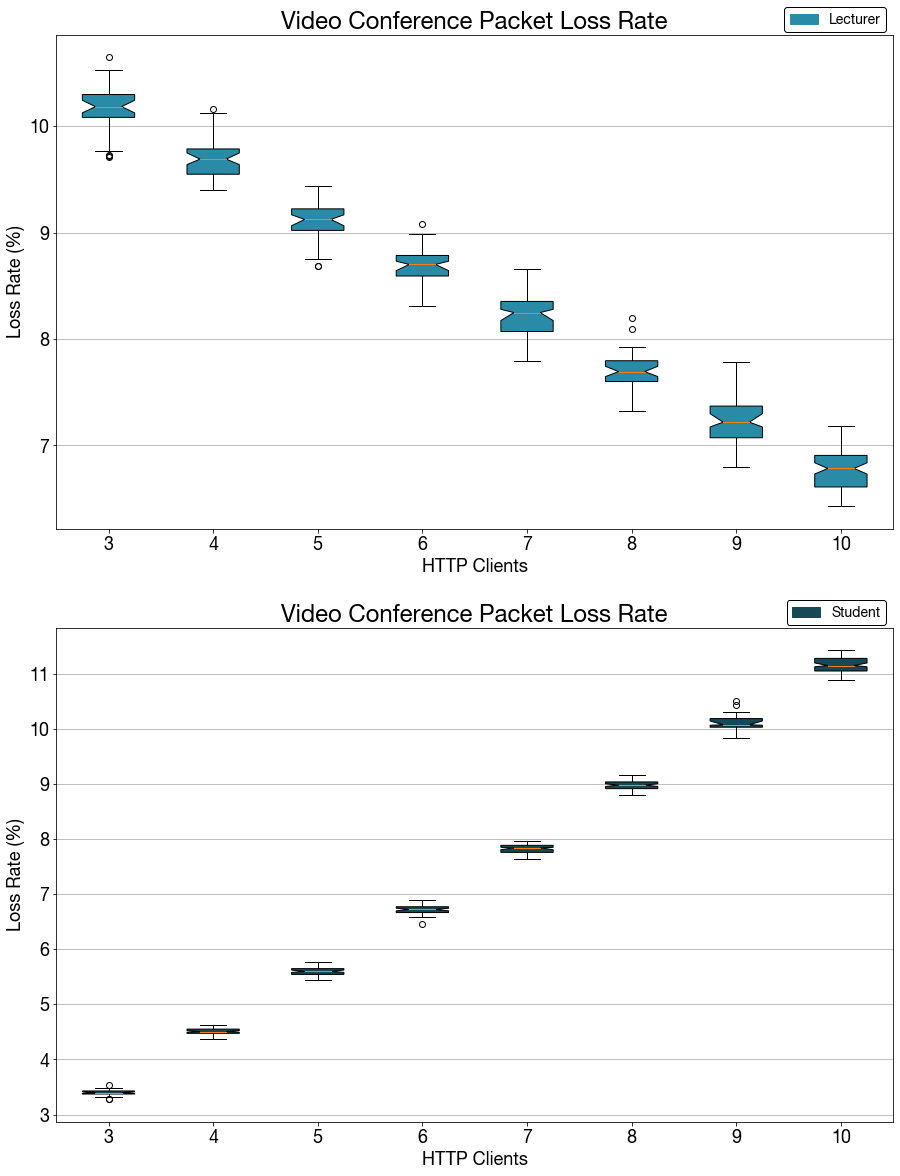

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from matplotlib import style
import matplotlib.patches as mpatches
import math
import decimal
import statistics
from scipy import stats
import os

path = os.getcwd()

class Result_Analysis():
        
    def read_file(self, file_number):# UPDATE file names to plot
        dict_ = {1: 'Sim_Results/2000sec_50runs/1_client/HTTP_Clients_1_AVG_PK_LOSS_Rate.csv',
                 2: 'Sim_Results/2000sec_50runs/2_client/HTTP_Clients_2_AVG_PK_LOSS_Rate.csv',
                 3: 'Sim_Results/2000sec_50runs/3_client/HTTP_Clients_3_AVG_PK_LOSS_Rate.csv',
                 4: 'Sim_Results/2000sec_50runs/4_client/VC_with_FTP_and_HTTP_AVG_PK_LOSS_Rate.csv',
                 5: 'Sim_Results/2000sec_50runs/5_client/HTTP_Clients_5_AVG_PK_LOSS_Rate.csv',
                 6: 'Sim_Results/2000sec_50runs/6_client/HTTP_Clients_6_AVG_PK_LOSS_Rate.csv',
                 7: 'Sim_Results/2000sec_50runs/7_client/HTTP_Clients_7_AVG_PK_LOSS_Rate.csv',
                 8: 'Sim_Results/2000sec_50runs/8_client/HTTP_Clients_8_AVG_PK_LOSS_Rate.csv',
                 9: 'Sim_Results/2000sec_50runs/9_client/HTTP_Clients_9_AVG_PK_LOSS_Rate.csv',
                 10: 'Sim_Results/2000sec_50runs/10_client/HTTP_Clients_10_AVG_PK_LOSS_Rate.csv',
                 11: 'Sim_Results/2000sec_50runs/11_client/HTTP_Clients_11_AVG_PK_LOSS_Rate.csv',
                 12: 'Sim_Results/2000sec_50runs/12_client/HTTP_Clients_12_AVG_PK_LOSS_Rate.csv',

                }
        cols = ['run', 'timelimit', 'repetition', 'Module', 'Name', 'Avg_Loss_Rate']
        data = pd.read_csv(dict_[file_number], delimiter=',', skiprows=[0], names=cols)

        data = data.dropna()
        data = data.reset_index(drop=True)
        df = pd.DataFrame(data)
        
        Professor_avgPKL_2000s_arr = []
        Student_avgPKL_2000s_arr = []
        
        for i in range(len(data)): # UPDATE number of seconds
            if (df['timelimit'][i] == 2000 and 'Professor' in df['Module'][i]):
                Professor_avgPKL_2000s_arr.append(df['Avg_Loss_Rate'][i]*100) # Convert to percent
            elif (df['timelimit'][i] == 2000 and 'Student' in df['Module'][i]):
                Student_avgPKL_2000s_arr.append(df['Avg_Loss_Rate'][i]*100) # Convert to percent
           
        dict_array = {'Professor': Professor_avgPKL_2000s_arr, 'Student': Student_avgPKL_2000s_arr}
        return dict_array
    
    def SampleStDev(self, arr):
        sample_stdev = [] # [P_stdev, S_stdev]
        for key, value in arr.items():
            sample_stdev.append(statistics.stdev(value))
        return sample_stdev
    
    def sampleMean(self, arr):
        sample_mean = [] # [P_mean, S_mean]
        for key, value in arr.items():
            sample_mean.append(statistics.mean(value))
        return sample_mean
    
    #  We assume we know the population standard deviation. For n <= 30, use T-Score. For n > 30, use Z-Score.
    #  we assume two sided t-value for normal distribution and degree freedom is one less than the length of the array.
    def tScore(self, conf, arr):
        t_scores = [] # [P_t-score, S_t-score]
        for inner_array in arr.values(): # {[P1, P2, ...],[S1, S2, ...]}
            t_scores.append(stats.t.ppf((conf + 1) / 2, len(inner_array)-1)) 
        return t_scores


    def confInterval_t(self, arr, sample_mean, sample_stdev, t_scores):
        for inner_array in arr.values():
            length = len(inner_array)
        
        upper_t = list((x+y for x,y in zip(sample_mean, 
                                           (a*b/math.sqrt(length) for a,b in zip(t_scores, sample_stdev)))))
        lower_t = list((x-y for x,y in zip(sample_mean, 
                                           (a*b/math.sqrt(length) for a,b in zip(t_scores, sample_stdev)))))
        
        return lower_t, upper_t
    
    def confInterval_z(self, con_coef, arr, sample_mean, sample_stdev):
        z_interval_l, z_interval_r = stats.norm.interval(con_coef)
        for inner_array in arr.values():
            length = len(inner_array)
            
        lower_z = list(x + y for x, y in zip(sample_mean, 
                                              (z_interval_l*element/ math.sqrt(length) for element in sample_stdev)))
        upper_z = list(x + y for x, y in zip(sample_mean, 
                                              (z_interval_r*element/ math.sqrt(length) for element in sample_stdev)))
        
        return lower_z, upper_z

run = True
while run:
    try:
        confidence_interval = float(input("\nPlease enter the desired confidence interval: "))
        if confidence_interval >= 1 or 0 >= confidence_interval:
            raise Exception 
                   
    except:
        print("Please enter a valid number from [0, 1)!")
        
    else:
        data_dict = {}
        mean_dict = {}
        t_dict = {}
        z_dict = {}
        
        for number in range(3,11): # UPDATE number based on number of files + 1
            file_number = number
            
            obj = Result_Analysis()
            dict_array = obj.read_file(file_number) # Returns array with 1st and 2nd value of Prof and Stud, respectively
            #print(dict_array)
            data_dict[number] = dict_array
            
            mean = obj.sampleMean(dict_array) # Returns array with 1st and 2nd value of Prof and Stud, respectively
            mean_dict[number] = mean #{1: [P_mean_1, S_mean_1], 2: [P2, S2], 3: [P3,S3]}
            
            stdev = obj.SampleStDev(dict_array) # Returns array with 1st and 2nd value of Prof and Stud, respectively
            tscore = obj.tScore(confidence_interval, dict_array)

            t_score_l, t_score_u = obj.confInterval_t(dict_array, mean, stdev, tscore)
            t_dict[number] = [(x,y) for x,y in zip(t_score_l, t_score_u)]
            
            z_score_l, z_score_u = obj.confInterval_z(confidence_interval, dict_array, mean, stdev)
            z_dict[number] = [(x,y) for x,y in zip(z_score_l, z_score_u)]
        
        #Plot the data
        #print(mean_dict)
        # width of the bars
        #barWidth = 0.2
        
        ## Choose the height of the bars
        ##bars_count_rpt03 = [math.ceil(user_count_arr[index]/3) for index, value in enumerate(user_count_arr) if index <= 3]
        ##bars_count_rpt10 = [math.ceil(user_count_arr[index]/10) for index, value in enumerate(user_count_arr) if index > 3]
        
        # UPDATE condition for i
        professor_data = [mean_dict[i][0] for i in mean_dict if i <= 12]
        student_data = [mean_dict[i][1] for i in mean_dict if i <= 12]
        
        # UPDATE condition for i
        professor_CI_l = [z_dict[i][0][0] for i in z_dict if i <= 12]
        professor_CI_u = [z_dict[i][0][1] for i in z_dict if i <= 12]

        professor_CI = [i for i in zip(professor_CI_l, professor_CI_u)]
        
        # UPDATE condition for i
        student_CI_l = [z_dict[i][1][0] for i in z_dict if i <= 12]
        student_CI_u = [z_dict[i][1][1] for i in z_dict if i <= 12]
        
        student_CI = [i for i in zip(student_CI_l, student_CI_u)]
        
        #print(student_CI)
        
        # Parameter setting for plotting
        plt.rcParams['axes.edgecolor']='#000000'
        plt.rcParams['axes.linewidth']=0.8
        plt.rcParams['xtick.color']='#000000'
        plt.rcParams['ytick.color']='#000000'
        plt.rcParams.update({'font.size': 18})
        plt.rcParams["legend.edgecolor"] = 'inherit'
        plt.rcParams["axes.edgecolor"] = 'black'
        plt.rcParams["legend.facecolor"] = 'inherit'
        plt.rcParams["axes.facecolor"] = 'black'
        plt.rcParams["font.family"] = 'serif'
        plt.rcParams['font.serif'] = 'Helvetica Neue'
        
        # And finally plot the cdf
        fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 20), facecolor = (1, 1, 1))
        
        # Create Notch Box Plots
        # Professor File Number 1
        #print(data_dict)
        #print(t_dict[1][0][0],t_dict[1][0][1])
        
        professor_arr = []
        student_arr = []
        for number, dict_ in data_dict.items():
            for key, arr in dict_.items():
                if(key is 'Professor'):
                    professor_arr.append(arr)
                if(key is 'Student'):
                    student_arr.append(arr)
        all_professor_data = np.array(professor_arr,order='C').T
        all_student_data = np.array(student_arr,order='C').T
        
        #print(all_professor_data)
        #print(all_student_data)
        
        labels = ['3', '4', '5', '6', '7', '8', '9', '10']
        
        # notch shape box plot
        bplot1 = axes[0].boxplot(all_professor_data,
                                 notch=True,  # notch shape
                                 vert=True,  # vertical box alignment
                                 patch_artist=True,  # fill with color
                                 conf_intervals=professor_CI, # calculated CIs
                                 labels=labels)  # will be used to label x-ticks
        axes[0].set_title('Video Conference Packet Loss Rate', fontsize=24, color = '#000000')
        axes[0].set_xlabel('HTTP Clients', fontsize=18)
        red_patch = mpatches.Patch(color='#2a8ba7', label='Lecturer')
        
        #axes[0].set_tick_params(direction='out', length=4, width=1, colors='#000000')

        axes[0].legend(handles=[red_patch], facecolor='white', framealpha=1,bbox_to_anchor=(1.0, 1.07), loc='upper right', prop={'size': 14})
        #axes[0].legend('Professor')
        
        # notch shape box plot
        bplot2 = axes[1].boxplot(all_student_data,
                                 notch=True,  # notch shape
                                 vert=True,  # vertical box alignment
                                 patch_artist=True,  # fill with color
                                 conf_intervals=student_CI, # calculated CIs
                                 labels=labels)  # will be used to label x-ticks
        axes[1].set_title('Video Conference Packet Loss Rate', fontsize=24, color = '#000000')
        axes[1].set_xlabel('HTTP Clients',fontsize=18)
        red_patch = mpatches.Patch(color='#144955', label='Student')
        axes[1].legend(handles=[red_patch], facecolor='white', framealpha=1,bbox_to_anchor=(1.0, 1.07), loc='upper right', prop={'size': 14})

        # fill with colors
        # Student color: #144955
        # Professor color: #2a8ba7
        # FTP Upload Student color: #f14c38
        # HTTP Clients color: #50c878
        
        prof_color = ['#2a8ba7', '#2a8ba7', '#2a8ba7', '#2a8ba7', 
                  '#2a8ba7', '#2a8ba7', '#2a8ba7', '#2a8ba7']
        stud_color = ['#144955', '#144955', '#144955', '#144955', 
                  '#144955', '#144955', '#144955', '#144955']

        for bplot in (bplot1, bplot2):
            if bplot == bplot1:
                for patch, color in zip(bplot['boxes'], prof_color):
                    patch.set_facecolor(color)
            else:
                for patch, color in zip(bplot['boxes'], stud_color):
                    patch.set_facecolor(color)
                
        # adding horizontal grid lines
        for ax in axes:
            ax.yaxis.grid(True)
            ax.set_facecolor((1, 1, 1))
            ax.set_ylabel('Loss Rate (%)', fontsize=18)
            ax.set_xticklabels(labels, fontsize=18, color = '#000000')
        
        run = False 

##### <center><h1>Queue Length Maximum</h1></center>


Please enter the desired confidence interval: .95
[(101.0, 101.0), (101.0, 101.0), (101.0, 101.0), (101.0, 101.0), (101.0, 101.0), (101.0, 101.0), (101.0, 101.0), (101.0, 101.0), (101.0, 101.0), (101.0, 101.0), (101.0, 101.0), (101.0, 101.0)]


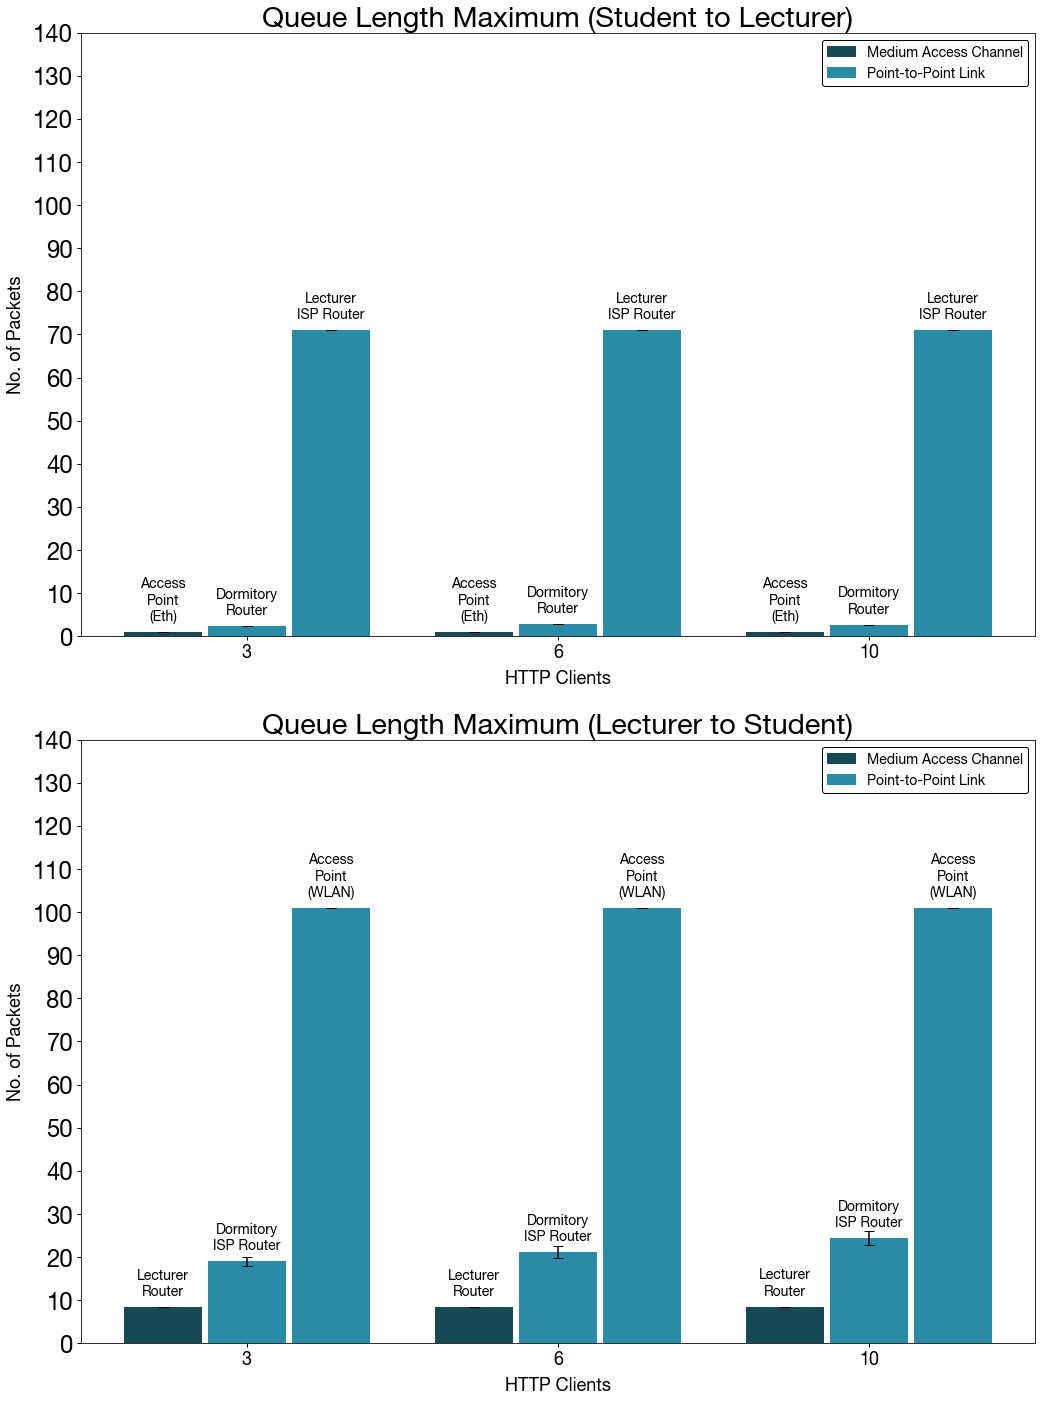

In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from matplotlib import style
import math
import decimal
import statistics
from scipy import stats
import os

path = os.getcwd()

class Result_Analysis():
        
    def read_file(self, file_number):
        dict_ = {1: 'Sim_Results/AP_Pending_Queue/HTTP_Clients_1_queueLength_max.csv',
                 2: 'Sim_Results/AP_Pending_Queue/HTTP_Clients_2_queueLength_max.csv',
                 3: 'Sim_Results/AP_Pending_Queue/HTTP_Clients_3_queueLength_max.csv',
                 4: 'Sim_Results/AP_Pending_Queue/HTTP_Clients_4_queueLength_max.csv',
                 5: 'Sim_Results/AP_Pending_Queue/HTTP_Clients_5_queueLength_max.csv',
                 6: 'Sim_Results/AP_Pending_Queue/HTTP_Clients_6_queueLength_max.csv',
                 7: 'Sim_Results/AP_Pending_Queue/HTTP_Clients_7_queueLength_max.csv',
                 8: 'Sim_Results/AP_Pending_Queue/HTTP_Clients_8_queueLength_max.csv',
                 9: 'Sim_Results/AP_Pending_Queue/HTTP_Clients_9_queueLength_max.csv',
                 10: 'Sim_Results/AP_Pending_Queue/HTTP_Clients_10_queueLength_max.csv',
                 11: 'Sim_Results/AP_Pending_Queue/HTTP_Clients_11_queueLength_max.csv',
                 12: 'Sim_Results/AP_Pending_Queue/HTTP_Clients_12_queueLength_max.csv'
                }
    
        cols = ['run', 'timelimit', 'repetition', 'Module', 'Name', 'queue_length']
        data = pd.read_csv(dict_[file_number], delimiter=',', skiprows=[0], names=cols)

        data = data.dropna()
        data = data.reset_index(drop=True)
        df = pd.DataFrame(data)
        
        AP_wlan_arr = []
        AP_eth_arr = []
        DISPRouter_arr = []
        DRouter_arr = []
        LISPRouter_arr = []
        LRouter_arr = []
        
        for i in range(len(data)): # UPDATE number of seconds
            if (df['timelimit'][i] == 2000 and 'DISPRouter.ppp' in df['Module'][i]):
                DISPRouter_arr.append(df['queue_length'][i]) # Append queue length
                
            elif (df['timelimit'][i] == 2000 and 'DRouter.ppp' in df['Module'][i]):
                DRouter_arr.append(df['queue_length'][i]) # Append queue length
                
            elif (df['timelimit'][i] == 2000 and 'LISPRouter.ppp' in df['Module'][i]):
                LISPRouter_arr.append(df['queue_length'][i]) # Append queue length 
          
            elif (df['timelimit'][i] == 2000 and 'LRouter.ppp' in df['Module'][i]):
                LRouter_arr.append(df['queue_length'][i]) # Append queue length 
            
            elif (df['timelimit'][i] == 2000 and 'AP.eth' in df['Module'][i]):
                AP_eth_arr.append(df['queue_length'][i]) # Append queue length 
            
            elif (df['timelimit'][i] == 2000 and 'AP.wlan' in df['Module'][i]):
                AP_wlan_arr.append(df['queue_length'][i]) # Append queue length 
           
        dict_array = {'DISPRouter': DISPRouter_arr, 
                      'DRouter': DRouter_arr,
                      'LISPRouter': LISPRouter_arr,
                      'LRouter': LRouter_arr,
                      'AP_eth': AP_eth_arr,
                      'AP_wlan': AP_wlan_arr
                     }
        #print(dict_array)
        return dict_array
    
    def SampleStDev(self, arr):
        sample_stdev = []
        for key, value in arr.items():
            sample_stdev.append(statistics.stdev(value))
        return sample_stdev
    
    def sampleMean(self, arr):
        sample_mean = []
        for key, value in arr.items():
            sample_mean.append(statistics.mean(value))
        return sample_mean
    
    #  We assume we know the population standard deviation. For n <= 30, use T-Score. For n > 30, use Z-Score.
    #  we assume two sided t-value for normal distribution and degree freedom is one less than the length of the array.
    def tScore(self, conf, arr):
        t_scores = []
        for inner_array in arr.values():
            t_scores.append(stats.t.ppf((conf + 1) / 2, len(inner_array)-1)) 
        return t_scores


    def confInterval_t(self, arr, sample_mean, sample_stdev, t_scores):
        for inner_array in arr.values():
            length = len(inner_array)
        
        upper_t = list((x+y for x,y in zip(sample_mean, 
                                           (a*b/math.sqrt(length) for a,b in zip(t_scores, sample_stdev)))))
        lower_t = list((x-y for x,y in zip(sample_mean, 
                                           (a*b/math.sqrt(length) for a,b in zip(t_scores, sample_stdev)))))
        
        return lower_t, upper_t
    
    def confInterval_z(self, con_coef, arr, sample_mean, sample_stdev):
        z_interval_l, z_interval_r = stats.norm.interval(con_coef)
        for inner_array in arr.values():
            length = len(inner_array)
            
        lower_z = list(x + y for x, y in zip(sample_mean, 
                                              (z_interval_l*element/ math.sqrt(length) for element in sample_stdev)))
        upper_z = list(x + y for x, y in zip(sample_mean, 
                                              (z_interval_r*element/ math.sqrt(length) for element in sample_stdev)))
        
        return lower_z, upper_z


run = True
while run:
    try:
        confidence_interval = float(input("\nPlease enter the desired confidence interval: "))
        if confidence_interval >= 1 or 0 >= confidence_interval:
            raise Exception 
                   
    except:
        print("Please enter a valid number from [0, 1)!")
        
    else:
        data_dict = {}
        mean_dict = {}
        t_dict = {}
        z_dict = {}
        
        for number in range(1,13):
            file_number = number
            
            obj = Result_Analysis()
            dict_array = obj.read_file(file_number)
            #print(dict_array)
            data_dict[number] = dict_array
            
            mean = obj.sampleMean(dict_array)
            mean_dict[number] = mean
            
            stdev = obj.SampleStDev(dict_array)
            tscore = obj.tScore(confidence_interval, dict_array)

            t_score_l, t_score_r = obj.confInterval_t(dict_array, mean, stdev, tscore)
            t_dict[number] = [(x,y) for x,y in zip(t_score_l, t_score_r)]
            
            z_score_l, z_score_r = obj.confInterval_z(confidence_interval, dict_array, mean, stdev)
            z_dict[number] = [(x,y) for x,y in zip(z_score_l, z_score_r)]

        
        # UPDATE condition for i
        #print(mean_dict)
        DISPRouter_data = [mean_dict[i][0] for i in mean_dict if i <= 12]
        DRouter_data = [mean_dict[i][1] for i in mean_dict if i <= 12]
        LISPRouter_data = [mean_dict[i][2] for i in mean_dict if i <= 12]
        LRouter_data = [mean_dict[i][3] for i in mean_dict if i <= 12]
        AP_eth_data = [mean_dict[i][4] for i in mean_dict if i <= 12]
        AP_wlan_data = [mean_dict[i][5] for i in mean_dict if i <= 12]
        
        # UPDATE condition for i
        DISPRouter_CI_l = [z_dict[i][0][0] for i in z_dict if i <= 12]
        DISPRouter_CI_u = [z_dict[i][0][1] for i in z_dict if i <= 12]
        DISPRouter_CI = [i for i in zip(DISPRouter_CI_l, DISPRouter_CI_u)]
        
        DRouter_CI_l = [z_dict[i][1][0] for i in z_dict if i <= 12]
        DRouter_CI_u = [z_dict[i][1][1] for i in z_dict if i <= 12]
        DRouter_CI = [i for i in zip(DRouter_CI_l, DRouter_CI_u)]
        
        LISPRouter_CI_l = [z_dict[i][2][0] for i in z_dict if i <= 12]
        LISPRouter_CI_u = [z_dict[i][2][1] for i in z_dict if i <= 12]
        LISPRouter_CI = [i for i in zip(LISPRouter_CI_l, LISPRouter_CI_u)]
        
        LRouter_CI_l = [z_dict[i][3][0] for i in z_dict if i <= 12]
        LRouter_CI_u = [z_dict[i][3][1] for i in z_dict if i <= 12]
        LRouter_CI = [i for i in zip(LRouter_CI_l, LRouter_CI_u)]
        
        AP_eth_CI_l = [z_dict[i][4][0] for i in z_dict if i <= 12]
        AP_eth_CI_u = [z_dict[i][4][1] for i in z_dict if i <= 12]
        AP_eth_CI = [i for i in zip(AP_eth_CI_l, AP_eth_CI_u)]
        
        AP_wlan_CI_l = [z_dict[i][5][0] for i in z_dict if i <= 12]
        AP_wlan_CI_u = [z_dict[i][5][1] for i in z_dict if i <= 12]
        AP_wlan_CI = [i for i in zip(AP_wlan_CI_l, AP_wlan_CI_u)]
        
        print(AP_wlan_CI)
        
        DISPRouter_arr = []
        DRouter_arr = []
        LISPRouter_arr = []
        LRouter_arr = []
        AP_eth_arr = []
        AP_wlan_arr = []
        
        for number, dict_ in data_dict.items():
            for key, arr in dict_.items():
                if(key is 'DISPRouter'):
                    DISPRouter_arr.append(arr)
                if(key is 'DRouter'):
                    DRouter_arr.append(arr)
                if(key is 'LISPRouter'):
                    LISPRouter_arr.append(arr)
                if(key is 'LRouter'):
                    LRouter_arr.append(arr)
                if(key is 'AP_eth'):
                    AP_eth_arr.append(arr)
                if(key is 'AP_wlan'):
                    AP_wlan_arr.append(arr)
        
        avg_DISPRouter_data = np.array(DISPRouter_arr,order='C').T.mean(axis=0)
        avg_DRouter_data = np.array(DRouter_arr,order='C').T.mean(axis=0)
        avg_LISPRouter_data = np.array(LISPRouter_arr,order='C').T.mean(axis=0)
        avg_LRouter_data = np.array(LRouter_arr,order='C').T.mean(axis=0)
        avg_AP_eth_data = np.array(AP_eth_arr,order='C').T.mean(axis=0)
        avg_AP_wlan_data = np.array(AP_wlan_arr,order='C').T.mean(axis=0)
        
        # avg values in following order: DRouter, DISPRouter, LISPRouter, LRouter for HTTP Clients 3, 6, and 10
        stud_to_prof_qL_max_bars = np.concatenate(
            (avg_AP_eth_data[2], avg_DRouter_data[2], avg_LISPRouter_data[2],
             avg_AP_eth_data[5], avg_DRouter_data[5], avg_LISPRouter_data[5],
             avg_AP_eth_data[9], avg_DRouter_data[9], avg_LISPRouter_data[9]), axis=None)
        prof_to_stud_qL_max_bars = np.concatenate(
            (avg_AP_wlan_data[2], avg_DISPRouter_data[2], avg_LRouter_data[2],
             avg_AP_wlan_data[5], avg_DISPRouter_data[5], avg_LRouter_data[5],
             avg_AP_wlan_data[9], avg_DISPRouter_data[9], avg_LRouter_data[9]), axis=None)
        
        # width of the bars
        barWidth = 0.25
        
        # Choose the height of the bars
        AP_eth_qL_max_bars = [stud_to_prof_qL_max_bars[0], stud_to_prof_qL_max_bars[3], stud_to_prof_qL_max_bars[6]]
        DRouter_qL_max_bars = [stud_to_prof_qL_max_bars[1], stud_to_prof_qL_max_bars[4], stud_to_prof_qL_max_bars[7]]
        LISPRouter_qL_max_bars = [stud_to_prof_qL_max_bars[2], stud_to_prof_qL_max_bars[5], stud_to_prof_qL_max_bars[8]]
        
        LRouter_qL_max_bars = [prof_to_stud_qL_max_bars[0], prof_to_stud_qL_max_bars[3], prof_to_stud_qL_max_bars[6]]
        DISPRouter_qL_max_bars = [prof_to_stud_qL_max_bars[1], prof_to_stud_qL_max_bars[4], prof_to_stud_qL_max_bars[7]]
        AP_wlan_qL_max_bars = [prof_to_stud_qL_max_bars[2], prof_to_stud_qL_max_bars[5], prof_to_stud_qL_max_bars[8]]
        
        # Choose the height of the confidence interval (error bars) for errorbar method
        DRouter_CI_yerr = [(u - l)/2 for l, u in DRouter_CI]
        DRouter_CI_yerr_bars = [DRouter_CI_yerr[2], DRouter_CI_yerr[5], DRouter_CI_yerr[9]]
        
        DISPRouter_CI_yerr = [(u - l)/2 for l, u in DISPRouter_CI]
        DISPRouter_CI_yerr_bars = [DISPRouter_CI_yerr[2], DISPRouter_CI_yerr[5], DISPRouter_CI_yerr[9]]
        
        LISPRouter_CI_yerr = [(u - l)/2 for l, u in LISPRouter_CI]
        LISPRouter_CI_yerr_bars = [LISPRouter_CI_yerr[2], LISPRouter_CI_yerr[5], LISPRouter_CI_yerr[9]]
        
        LRouter_CI_yerr = [(u - l)/2 for l, u in LRouter_CI]
        LRouter_CI_yerr_bars = [LRouter_CI_yerr[2], LRouter_CI_yerr[5], LRouter_CI_yerr[9]]
        
        AP_eth_CI_yerr = [(u - l)/2 for l, u in AP_eth_CI]
        AP_eth_CI_yerr_bars = [AP_eth_CI_yerr[2], AP_eth_CI_yerr[5], AP_eth_CI_yerr[9]]

        AP_wlan_CI_yerr = [(u - l)/2 for l, u in AP_wlan_CI]
        AP_wlan_CI_yerr_bars = [AP_wlan_CI_yerr[2], AP_wlan_CI_yerr[5], AP_wlan_CI_yerr[9]]
        
        ## The x position of bars
        stud_to_prof_x_pos_AP_eth = np.arange(len(AP_eth_qL_max_bars))
        stud_to_prof_x_pos_DRouter = [x + barWidth + 0.02 for x in stud_to_prof_x_pos_AP_eth]
        stud_to_prof_x_pos_LISPRouter = [x + barWidth + 0.02 for x in stud_to_prof_x_pos_DRouter]
        
        prof_stud_x_pos_AP_wlan = np.arange(len(AP_wlan_qL_max_bars))
        prof_stud_x_pos_DISPRouter = [x + barWidth + 0.02 for x in prof_stud_x_pos_AP_wlan]
        prof_stud_x_pos_LRouter = [x + barWidth + 0.02 for x in prof_stud_x_pos_DISPRouter]
        
        # Parameter setting for plotting
        plt.rcParams['axes.edgecolor']='#000000'
        plt.rcParams['axes.linewidth']=0.8
        plt.rcParams['xtick.color']='#000000'
        plt.rcParams['ytick.color']='#000000'
        plt.rcParams.update({'font.size': 24})
        plt.rcParams["legend.edgecolor"] = 'inherit'
        plt.rcParams["axes.edgecolor"] = 'black'
        plt.rcParams["legend.facecolor"] = 'inherit'
        plt.rcParams["axes.facecolor"] = 'black'
        plt.rcParams["font.family"] = 'serif'
        plt.rcParams['font.serif'] = 'Helvetica Neue'
        
        fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(15, 20), facecolor = (1, 1, 1))
        ax1.set_facecolor((1, 1, 1))
        ax2.set_facecolor((1, 1, 1))

        # fill with colors
        # Student color: #144955
        # Professor color: #2a8ba7
        # FTP Upload Student color: #f14c38
        # HTTP Clients color: #50c878
        
        # Create queueLength max bars
        ax1.bar(stud_to_prof_x_pos_AP_eth, AP_eth_qL_max_bars, width = barWidth, color = '#144955', label='Medium Access Channel')
        ax1.bar(stud_to_prof_x_pos_DRouter, DRouter_qL_max_bars, width = barWidth, color = '#2a8ba7', label='Point-to-Point Link')
        ax1.bar(stud_to_prof_x_pos_LISPRouter, LISPRouter_qL_max_bars, width = barWidth, color = '#2a8ba7')
        
        # Create error bars (CIs)
        ax1.errorbar(stud_to_prof_x_pos_AP_eth, AP_eth_qL_max_bars, yerr=AP_eth_CI_yerr_bars, color = 'black', capthick=1, capsize=5, fmt=' ')
        ax1.errorbar(stud_to_prof_x_pos_DRouter, DRouter_qL_max_bars, yerr=DRouter_CI_yerr_bars, color = 'black', capthick=1, capsize=5, fmt=' ')
        ax1.errorbar(stud_to_prof_x_pos_LISPRouter, LISPRouter_qL_max_bars, yerr=LISPRouter_CI_yerr_bars, color = 'black', capthick=1, capsize=5, fmt=' ')
        
        ax2.bar(prof_stud_x_pos_LRouter, LRouter_qL_max_bars, width = barWidth, color = '#2a8ba7')
        ax2.bar(prof_stud_x_pos_DISPRouter, DISPRouter_qL_max_bars, width = barWidth, color = '#2a8ba7', label='Point-to-Point Link')
        ax2.bar(prof_stud_x_pos_AP_wlan, AP_wlan_qL_max_bars, width = barWidth, color = '#144955', label='Medium Access Channel')
        
        ax2.errorbar(prof_stud_x_pos_LRouter, LRouter_qL_max_bars, yerr=LRouter_CI_yerr_bars, color = 'black', capthick=1, capsize=5, fmt=' ')        
        ax2.errorbar(prof_stud_x_pos_DISPRouter, DISPRouter_qL_max_bars, yerr=DISPRouter_CI_yerr_bars, color = 'black', capthick=1, capsize=5, fmt=' ')
        ax2.errorbar(prof_stud_x_pos_AP_wlan, AP_wlan_qL_max_bars, yerr=AP_wlan_CI_yerr_bars, color = 'black', capthick=1, capsize=5, fmt=' ')
        
        stud_to_prof_bars = ax1.patches
        prof_to_stud_bars = ax2.patches

        # Make some labels.
        stud_to_prof_bar_labels = ["Access\nPoint\n(Eth)", "Access\nPoint\n(Eth)", "Access\nPoint\n(Eth)",
                                   "Dormitory\nRouter", "Dormitory\nRouter", "Dormitory\nRouter",
                                   "Lecturer\nISP Router", "Lecturer\nISP Router", "Lecturer\nISP Router"]
        
        prof_to_stud_bar_labels = ["Access\nPoint\n(WLAN)", "Access\nPoint\n(WLAN)", "Access\nPoint\n(WLAN)",
                                   "Dormitory\nISP Router", "Dormitory\nISP Router", "Dormitory\nISP Router",
                                   "Lecturer\nRouter", "Lecturer\nRouter", "Lecturer\nRouter"]

        for rect, label in zip(stud_to_prof_bars, stud_to_prof_bar_labels):
            height = rect.get_height()
            ax1.text(rect.get_x() + rect.get_width() / 2, height + 2, label, ha='center', va='bottom', fontsize = 14)
        
        for rect, label in zip(prof_to_stud_bars, prof_to_stud_bar_labels):
            height = rect.get_height()
            ax2.text(rect.get_x() + rect.get_width() / 2, height + 2, label, ha='center', va='bottom', fontsize = 14)
    
        labels = ['3','6','10']
        x = np.arange(len(labels))  # the label locations
        ax1.set_xticks(x+0.27)
        ax1.set_xticklabels(labels, fontsize=18, color = '#000000')
        ax1.tick_params(direction='out', length=4, width=1, colors='#000000')
        ax2.set_xticks(x+0.27)
        ax2.set_xticklabels(labels, fontsize=18, color = '#000000')
        ax2.tick_params(direction='out', length=4, width=1, colors='#000000')
        
        
        ax1.set_yticks(np.arange(0, 150, 10))
        ax1.set_ylabel('No. of Packets', fontsize=18 , labelpad=8, color = '#000000')
        ax1.set_xlabel('HTTP Clients', fontsize=18 , labelpad=8, color = '#000000')
        ax1.set_title('Queue Length Maximum (Student to Lecturer)', color = '#000000')
        
        ax2.set_yticks(np.arange(0, 150, 10))
        ax2.set_ylabel('No. of Packets', fontsize=18, labelpad=8, color = '#000000')
        ax2.set_xlabel('HTTP Clients', fontsize=18, labelpad=8, color = '#000000')
        ax2.set_title('Queue Length Maximum (Lecturer to Student)', color = '#000000')

        label_1_patch = mpatches.Patch(color='#144955', label='Medium Access Channel')
        label_2_patch = mpatches.Patch(color='#2a8ba7', label='Point-to-Point Link')
        
        leg1 = ax1.legend(handles=[label_1_patch,label_2_patch], facecolor='white', framealpha=1, 
                          bbox_to_anchor=(1.0, 1.0), loc='upper right', prop={'size': 14})
        leg2 = ax2.legend(handles=[label_1_patch,label_2_patch], facecolor='white', framealpha=1, 
                          bbox_to_anchor=(1.0, 1.0), loc='upper right', prop={'size': 14})

        #leg1 = ax1.legend(fontsize = 14, loc='lower right', bbox_to_anchor= (0.95, 0.90), ncol=1, borderaxespad=0, frameon=False)
        #leg2 = ax2.legend(fontsize = 14, loc='lower right', bbox_to_anchor= (0.95, 0.90), ncol=1, borderaxespad=0, framealpha=1)
        
        #leg1 = ax1.legend(fontsize = 14, loc='lower right', bbox_to_anchor= (0.95, 0.90), ncol=1, borderaxespad=0, frameon=False)
        #leg2 = ax2.legend(fontsize = 14, loc='lower right', bbox_to_anchor= (0.95, 0.90), ncol=1, borderaxespad=0, framealpha=1)
        
        for text in leg1.get_texts():
            text.set_color("black")
        for text in leg2.get_texts():
            text.set_color("black")
        
        fig.tight_layout()
        plt.show()
        
        #print(f'\n\n\nCI based on T-score: \n{t_dict}')
        #print(f'\n\n\nCI based on Z-score: \n{z_dict}')
        #print(f'\n\n\nMean:{mean_dict}')
        
        run = False 

##### <center><h1>Late vs. Lost vs. Drop</h1></center>


Please enter the desired confidence interval: .95
[5687.54 5366.2  5092.48 4847.06 4558.1  4343.56 4113.22 3847.8  3618.12
 3392.12 3220.08 2950.86]


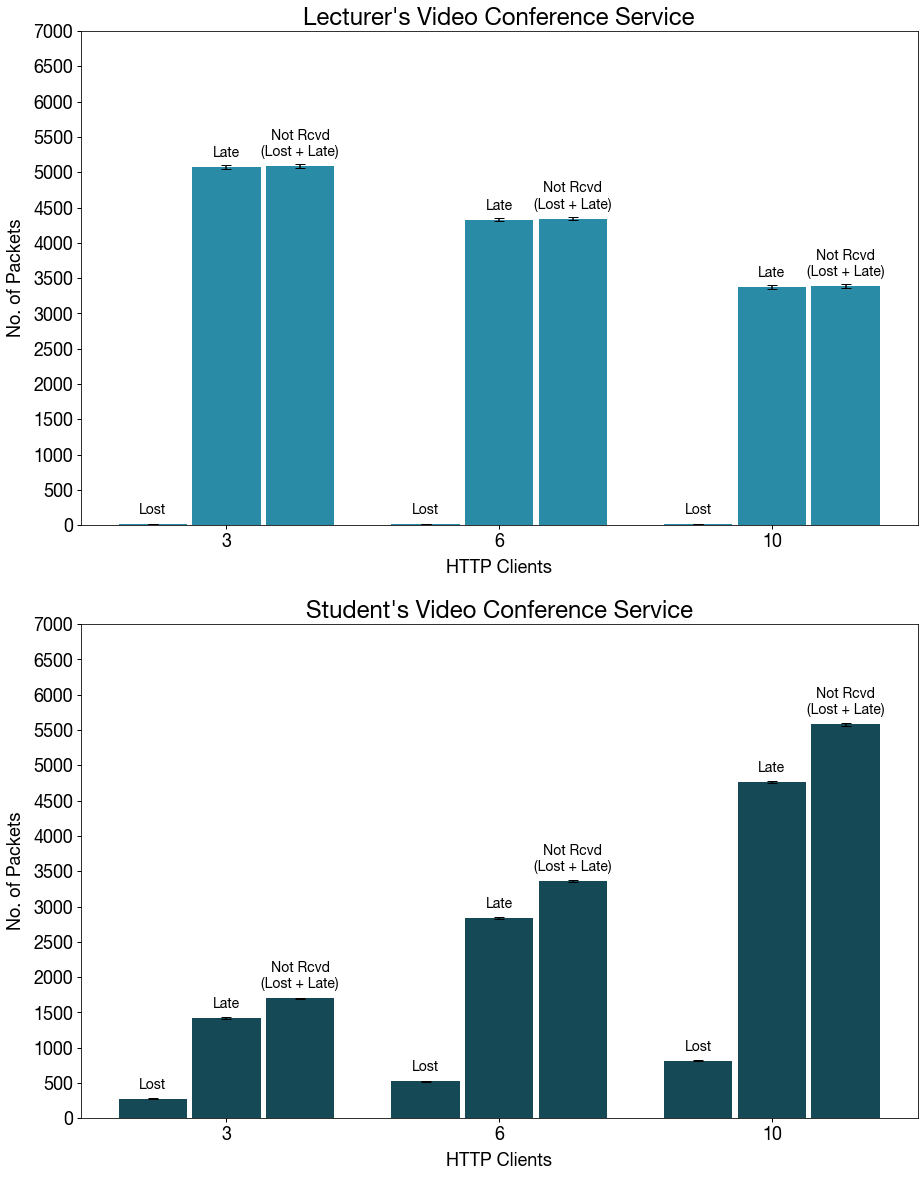

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from matplotlib import style
import math
import decimal
import statistics
from scipy import stats
import os

path = os.getcwd()

class Result_Analysis():
    
    def read_file(self, file_number):
        dict_ = {1: 'Sim_Results/Late_Lost_Packets/HTTP_Clients_1_LATE_LOST_SENT_RCVD_Packets.csv',
                 2: 'Sim_Results/Late_Lost_Packets/HTTP_Clients_2_LATE_LOST_SENT_RCVD_Packets.csv',
                 3: 'Sim_Results/Late_Lost_Packets/HTTP_Clients_3_LATE_LOST_SENT_RCVD_Packets.csv',
                 4: 'Sim_Results/Late_Lost_Packets/HTTP_Clients_4_LATE_LOST_SENT_RCVD_Packets.csv',
                 5: 'Sim_Results/Late_Lost_Packets/HTTP_Clients_5_LATE_LOST_SENT_RCVD_Packets.csv',
                 6: 'Sim_Results/Late_Lost_Packets/HTTP_Clients_6_LATE_LOST_SENT_RCVD_Packets.csv',
                 7: 'Sim_Results/Late_Lost_Packets/HTTP_Clients_7_LATE_LOST_SENT_RCVD_Packets.csv',
                 8: 'Sim_Results/Late_Lost_Packets/HTTP_Clients_8_LATE_LOST_SENT_RCVD_Packets.csv',
                 9: 'Sim_Results/Late_Lost_Packets/HTTP_Clients_9_LATE_LOST_SENT_RCVD_Packets.csv',
                 10: 'Sim_Results/Late_Lost_Packets/HTTP_Clients_10_LATE_LOST_SENT_RCVD_Packets.csv',
                 11: 'Sim_Results/Late_Lost_Packets/HTTP_Clients_11_LATE_LOST_SENT_RCVD_Packets.csv',
                 12: 'Sim_Results/Late_Lost_Packets/HTTP_Clients_12_LATE_LOST_SENT_RCVD_Packets.csv'
                }
    
        cols = ['run', 'timelimit', 'repetition', 'Module', 'Name', 'packet_count']
        data = pd.read_csv(dict_[file_number], delimiter=',', skiprows=[0], names=cols)

        data = data.dropna()
        data = data.sort_values(by =['Name','Module','repetition'], ascending=True)
        data = data.reset_index(drop=True)
        df = pd.DataFrame(data)
        
        #print(df,"\n\n\n")
        
        
        professor_LATE_packets_arr = []
        professor_LOST_packets_arr = [] # Packets lost in link, dropped due to buffer overflow
        professor_SENT_packets_arr = []
        professor_RCVD_packets_arr = []
        professor_NOTRCVD_packets_arr = [] # Packets not received
        student_LATE_packets_arr = []
        student_LOST_packets_arr = [] # Packets lost in link, dropped due to buffer overflow
        student_SENT_packets_arr = []
        student_RCVD_packets_arr = []
        student_NOTRCVD_packets_arr = [] # Packets not received
        
        for i in range(len(data)): # UPDATE number of seconds
            if (df['timelimit'][i] == 2000 and 'Professor' in df['Module'][i] and 'LATE' in df['Name'][i]):
                professor_LATE_packets_arr.append(df['packet_count'][i]) # Append packet count
                
            elif (df['timelimit'][i] == 2000 and 'Professor' in df['Module'][i] and 'LOST' in df['Name'][i]):
                professor_LOST_packets_arr.append(df['packet_count'][i]) # Append packet count
                
            elif (df['timelimit'][i] == 2000 and 'Professor' in df['Module'][i] and 'SENT' in df['Name'][i]):
                professor_SENT_packets_arr.append(df['packet_count'][i]) # Append packet count
          
            elif (df['timelimit'][i] == 2000 and 'Professor' in df['Module'][i] and 'RCVD' in df['Name'][i]):
                professor_RCVD_packets_arr.append(df['packet_count'][i]) # Append packet count
            
            elif (df['timelimit'][i] == 2000 and 'Student' in df['Module'][i] and 'LATE' in df['Name'][i]):
                student_LATE_packets_arr.append(df['packet_count'][i]) # Append packet count
                
            elif (df['timelimit'][i] == 2000 and 'Student' in df['Module'][i] and 'LOST' in df['Name'][i]):
                student_LOST_packets_arr.append(df['packet_count'][i]) # Append packet count
                
            elif (df['timelimit'][i] == 2000 and 'Student' in df['Module'][i] and 'SENT' in df['Name'][i]):
                student_SENT_packets_arr.append(df['packet_count'][i]) # Append packet count
          
            elif (df['timelimit'][i] == 2000 and 'Student' in df['Module'][i] and 'RCVD' in df['Name'][i]):
                student_RCVD_packets_arr.append(df['packet_count'][i]) # Append packet count
           
        professor_NOTRCVD_packets_arr = [(s-r) for s, r in zip(professor_SENT_packets_arr, professor_RCVD_packets_arr)]
        student_NOTRCVD_packets_arr = [(s-r) for s, r in zip(student_SENT_packets_arr, student_RCVD_packets_arr)]
            
        dict_array = {
            'professor_LATE': professor_LATE_packets_arr, 
            'professor_LOST': professor_LOST_packets_arr,
            'professor_SENT': professor_SENT_packets_arr,
            'professor_RCVD': professor_RCVD_packets_arr,
            'professor_NOTRCVD': professor_NOTRCVD_packets_arr,
            'student_LATE': student_LATE_packets_arr,
            'student_LOST': student_LOST_packets_arr,
            'student_SENT': student_SENT_packets_arr,
            'student_RCVD': student_RCVD_packets_arr,
            'student_NOTRCVD': student_NOTRCVD_packets_arr
        }
        #print(dict_array)
        return dict_array
    
    def SampleStDev(self, arr):
        sample_stdev = []
        for key, value in arr.items():
            sample_stdev.append(statistics.stdev(value))
        return sample_stdev
    
    def sampleMean(self, arr):
        sample_mean = []
        for key, value in arr.items():
            sample_mean.append(statistics.mean(value))
        return sample_mean
    
    #  We assume we know the population standard deviation. For n <= 30, use T-Score. For n > 30, use Z-Score.
    #  we assume two sided t-value for normal distribution and degree freedom is one less than the length of the array.
    def tScore(self, conf, arr):
        t_scores = []
        for inner_array in arr.values():
            t_scores.append(stats.t.ppf((conf + 1) / 2, len(inner_array)-1)) 
        return t_scores


    def confInterval_t(self, arr, sample_mean, sample_stdev, t_scores):
        for inner_array in arr.values():
            length = len(inner_array)
        
        upper_t = list((x+y for x,y in zip(sample_mean, 
                                           (a*b/math.sqrt(length) for a,b in zip(t_scores, sample_stdev)))))
        lower_t = list((x-y for x,y in zip(sample_mean, 
                                           (a*b/math.sqrt(length) for a,b in zip(t_scores, sample_stdev)))))
        
        return lower_t, upper_t
    
    def confInterval_z(self, con_coef, arr, sample_mean, sample_stdev):
        z_interval_l, z_interval_r = stats.norm.interval(con_coef)
        for inner_array in arr.values():
            length = len(inner_array)
            
        lower_z = list(x + y for x, y in zip(sample_mean, 
                                              (z_interval_l*element/ math.sqrt(length) for element in sample_stdev)))
        upper_z = list(x + y for x, y in zip(sample_mean, 
                                              (z_interval_r*element/ math.sqrt(length) for element in sample_stdev)))
        
        return lower_z, upper_z


run = True
while run:
    try:
        confidence_interval = float(input("\nPlease enter the desired confidence interval: "))
        if confidence_interval >= 1 or 0 >= confidence_interval:
            raise Exception 
                   
    except:
        print("Please enter a valid number from [0, 1)!")
        
    else:
        data_dict = {}
        mean_dict = {}
        t_dict = {}
        z_dict = {}
        
        for number in range(1,13):
            file_number = number
            
            obj = Result_Analysis()
            dict_array = obj.read_file(file_number)
            #print(dict_array)
            data_dict[number] = dict_array
            
            mean = obj.sampleMean(dict_array)
            mean_dict[number] = mean
            
            stdev = obj.SampleStDev(dict_array)
            tscore = obj.tScore(confidence_interval, dict_array)

            t_score_l, t_score_r = obj.confInterval_t(dict_array, mean, stdev, tscore)
            t_dict[number] = [(x,y) for x,y in zip(t_score_l, t_score_r)]
            
            z_score_l, z_score_r = obj.confInterval_z(confidence_interval, dict_array, mean, stdev)
            z_dict[number] = [(x,y) for x,y in zip(z_score_l, z_score_r)]

        
        professor_LATE_arr = []
        professor_LOST_arr = []
        professor_SENT_arr = []
        professor_RCVD_arr = []
        professor_NOTRCVD_arr = []
        student_LATE_arr = []
        student_LOST_arr = []
        student_SENT_arr = []
        student_RCVD_arr = []
        student_NOTRCVD_arr = []
        
        for number, dict_ in data_dict.items():
            for key, arr in dict_.items():
                if(key is 'professor_LATE'):
                    professor_LATE_arr.append(arr)
                if(key is 'professor_LOST'):
                    professor_LOST_arr.append(arr)
                if(key is 'professor_SENT'):
                    professor_SENT_arr.append(arr)
                if(key is 'professor_RCVD'):
                    professor_RCVD_arr.append(arr)
                if(key is 'professor_NOTRCVD'):
                    professor_NOTRCVD_arr.append(arr)
                if(key is 'student_LATE'):
                    student_LATE_arr.append(arr)
                if(key is 'student_LOST'):
                    student_LOST_arr.append(arr)
                if(key is 'student_SENT'):
                    student_SENT_arr.append(arr)
                if(key is 'student_RCVD'):
                    student_RCVD_arr.append(arr)
                if(key is 'student_NOTRCVD'):
                    student_NOTRCVD_arr.append(arr)
        
        avg_professor_LATE_data = np.array(professor_LATE_arr,order='C').T.mean(axis=0)
        avg_professor_LOST_data = np.array(professor_LOST_arr,order='C').T.mean(axis=0)
        avg_professor_SENT_data = np.array(professor_SENT_arr,order='C').T.mean(axis=0)
        avg_professor_RCVD_data = np.array(professor_RCVD_arr,order='C').T.mean(axis=0)
        avg_professor_NOTRCVD_data = np.array(professor_NOTRCVD_arr,order='C').T.mean(axis=0)
        avg_student_LATE_data = np.array(student_LATE_arr,order='C').T.mean(axis=0)
        avg_student_LOST_data = np.array(student_LOST_arr,order='C').T.mean(axis=0)
        avg_student_SENT_data = np.array(student_SENT_arr,order='C').T.mean(axis=0)
        avg_student_RCVD_data = np.array(student_RCVD_arr,order='C').T.mean(axis=0)
        avg_student_NOTRCVD_data = np.array(student_NOTRCVD_arr,order='C').T.mean(axis=0)
                
        print(avg_professor_NOTRCVD_data)
        
        # UPDATE condition for i
        #print(mean_dict)
        professor_LATE_data = [mean_dict[i][0] for i in mean_dict if i <= 12]
        professor_LOST_data = [mean_dict[i][1] for i in mean_dict if i <= 12]
        professor_SENT_data = [mean_dict[i][2] for i in mean_dict if i <= 12]
        professor_RCVD_data = [mean_dict[i][3] for i in mean_dict if i <= 12]
        professor_NOTRCVD_data = [mean_dict[i][4] for i in mean_dict if i <= 12]
        student_LATE_data = [mean_dict[i][5] for i in mean_dict if i <= 12]
        student_LOST_data = [mean_dict[i][6] for i in mean_dict if i <= 12]
        student_SENT_data = [mean_dict[i][7] for i in mean_dict if i <= 12]
        student_RCVD_data = [mean_dict[i][8] for i in mean_dict if i <= 12]
        student_NOTRCVD_data = [mean_dict[i][9] for i in mean_dict if i <= 12]
        
        
        # UPDATE condition for i
        professor_LATE_CI_l = [z_dict[i][0][0] for i in z_dict if i <= 12]
        professor_LATE_CI_u = [z_dict[i][0][1] for i in z_dict if i <= 12]
        professor_LATE_CI = [i for i in zip(professor_LATE_CI_l, professor_LATE_CI_u)]
        
        professor_LOST_CI_l = [z_dict[i][1][0] for i in z_dict if i <= 12]
        professor_LOST_CI_u = [z_dict[i][1][1] for i in z_dict if i <= 12]
        professor_LOST_CI = [i for i in zip(professor_LOST_CI_l, professor_LOST_CI_u)]
        
        professor_SENT_CI_l = [z_dict[i][2][0] for i in z_dict if i <= 12]
        professor_SENT_CI_u = [z_dict[i][2][1] for i in z_dict if i <= 12]
        professor_SENT_CI = [i for i in zip(professor_SENT_CI_l, professor_SENT_CI_u)]
        
        professor_RCVD_CI_l = [z_dict[i][3][0] for i in z_dict if i <= 12]
        professor_RCVD_CI_u = [z_dict[i][3][1] for i in z_dict if i <= 12]
        professor_RCVD_CI = [i for i in zip(professor_RCVD_CI_l, professor_RCVD_CI_u)]
                
        professor_NOTRCVD_CI_l = [z_dict[i][4][0] for i in z_dict if i <= 12]
        professor_NOTRCVD_CI_u = [z_dict[i][4][1] for i in z_dict if i <= 12]
        professor_NOTRCVD_CI = [i for i in zip(professor_NOTRCVD_CI_l, professor_NOTRCVD_CI_u)]
        
        student_LATE_CI_l = [z_dict[i][5][0] for i in z_dict if i <= 12]
        student_LATE_CI_u = [z_dict[i][5][1] for i in z_dict if i <= 12]
        student_LATE_CI = [i for i in zip(student_LATE_CI_l, student_LATE_CI_u)]
        
        student_LOST_CI_l = [z_dict[i][6][0] for i in z_dict if i <= 12]
        student_LOST_CI_u = [z_dict[i][6][1] for i in z_dict if i <= 12]
        student_LOST_CI = [i for i in zip(student_LOST_CI_l, student_LOST_CI_u)]
        
        student_SENT_CI_l = [z_dict[i][7][0] for i in z_dict if i <= 12]
        student_SENT_CI_u = [z_dict[i][7][1] for i in z_dict if i <= 12]
        student_SENT_CI = [i for i in zip(student_SENT_CI_l, student_SENT_CI_u)]
        
        student_RCVD_CI_l = [z_dict[i][8][0] for i in z_dict if i <= 12]
        student_RCVD_CI_u = [z_dict[i][8][1] for i in z_dict if i <= 12]
        student_RCVD_CI = [i for i in zip(student_RCVD_CI_l, student_RCVD_CI_u)]
        
        student_NOTRCVD_CI_l = [z_dict[i][9][0] for i in z_dict if i <= 12]
        student_NOTRCVD_CI_u = [z_dict[i][9][1] for i in z_dict if i <= 12]
        student_NOTRCVD_CI = [i for i in zip(student_NOTRCVD_CI_l, student_NOTRCVD_CI_u)]
        
        #print(professor_NOTRCVD_CI)
        
        # avg values in following order: DRouter, DISPRouter, LISPRouter, LRouter for HTTP Clients 3, 6, and 10
        professor_bars = np.concatenate(
            (avg_professor_LOST_data[2], avg_professor_LATE_data[2], avg_professor_NOTRCVD_data[2],
             avg_professor_LOST_data[5], avg_professor_LATE_data[5], avg_professor_NOTRCVD_data[5],
             avg_professor_LOST_data[9], avg_professor_LATE_data[9], avg_professor_NOTRCVD_data[9]), axis=None)
        student_bars = np.concatenate(
            (avg_student_LOST_data[2], avg_student_LATE_data[2], avg_student_NOTRCVD_data[2],
             avg_student_LOST_data[5], avg_student_LATE_data[5], avg_student_NOTRCVD_data[5],
             avg_student_LOST_data[9], avg_student_LATE_data[9], avg_student_NOTRCVD_data[9]), axis=None)
        
        # width of the bars
        barWidth = 0.25
        
        # Choose the height of the bars
        prof_LOST_bars = [professor_bars[0], professor_bars[3], professor_bars[6]]
        prof_LATE_bars = [professor_bars[1], professor_bars[4], professor_bars[7]]
        prof_NOTRCVD_bars = [professor_bars[2], professor_bars[5], professor_bars[8]]
        
        stud_LOST_bars = [student_bars[0], student_bars[3], student_bars[6]]
        stud_LATE_bars = [student_bars[1], student_bars[4], student_bars[7]]
        stud_NOTRCVD_bars = [student_bars[2], student_bars[5], student_bars[8]]
        
        # Choose the height of the confidence interval (error bars) for errorbar method
        prof_LATE_CI_yerr = [(u - l)/2 for l, u in professor_LATE_CI]
        prof_LATE_CI_yerr_bars = [prof_LATE_CI_yerr[2], prof_LATE_CI_yerr[5], prof_LATE_CI_yerr[9]]
        
        prof_LOST_CI_yerr = [(u - l)/2 for l, u in professor_LOST_CI]
        prof_LOST_CI_yerr_bars = [prof_LOST_CI_yerr[2], prof_LOST_CI_yerr[5], prof_LOST_CI_yerr[9]]
        
        prof_SENT_CI_yerr = [(u - l)/2 for l, u in professor_SENT_CI]
        prof_SENT_CI_yerr_bars = [prof_SENT_CI_yerr[2], prof_SENT_CI_yerr[5], prof_SENT_CI_yerr[9]]
        
        prof_RCVD_CI_yerr = [(u - l)/2 for l, u in professor_RCVD_CI]
        prof_RCVD_CI_yerr_bars = [prof_RCVD_CI_yerr[2], prof_RCVD_CI_yerr[5], prof_RCVD_CI_yerr[9]]
        
        prof_NOTRCVD_CI_yerr = [(u - l)/2 for l, u in professor_NOTRCVD_CI]
        prof_NOTRCVD_CI_yerr_bars = [prof_NOTRCVD_CI_yerr[2], prof_NOTRCVD_CI_yerr[5], prof_NOTRCVD_CI_yerr[9]]
        
        stud_LATE_CI_yerr = [(u - l)/2 for l, u in student_LATE_CI]
        stud_LATE_CI_yerr_bars = [stud_LATE_CI_yerr[2], stud_LATE_CI_yerr[5], stud_LATE_CI_yerr[9]]
        
        stud_LOST_CI_yerr = [(u - l)/2 for l, u in student_LOST_CI]
        stud_LOST_CI_yerr_bars = [stud_LOST_CI_yerr[2], stud_LOST_CI_yerr[5], stud_LOST_CI_yerr[9]]
        
        stud_SENT_CI_yerr = [(u - l)/2 for l, u in student_SENT_CI]
        stud_SENT_CI_yerr_bars = [stud_SENT_CI_yerr[2], stud_SENT_CI_yerr[5], stud_SENT_CI_yerr[9]]
        
        stud_RCVD_CI_yerr = [(u - l)/2 for l, u in student_RCVD_CI]
        stud_RCVD_CI_yerr_bars = [prof_RCVD_CI_yerr[2], prof_RCVD_CI_yerr[5], prof_RCVD_CI_yerr[9]]
        
        stud_NOTRCVD_CI_yerr = [(u - l)/2 for l, u in student_NOTRCVD_CI]
        stud_NOTRCVD_CI_yerr_bars = [stud_NOTRCVD_CI_yerr[2], stud_NOTRCVD_CI_yerr[5], stud_NOTRCVD_CI_yerr[9]]
        
        ## The x position of bars
        professor_x_pos_LOST = np.arange(len(prof_LOST_bars))
        professor_x_pos_LATE = [x + barWidth + 0.02 for x in professor_x_pos_LOST]
        professor_x_pos_NOTRCVD = [x + barWidth + 0.02 for x in professor_x_pos_LATE]
        
        student_x_pos_LOST = np.arange(len(stud_LOST_bars))
        student_x_pos_LATE = [x + barWidth + 0.02 for x in student_x_pos_LOST]
        student_x_pos_NOTRCVD = [x + barWidth + 0.02 for x in student_x_pos_LATE]
        
        # Parameter setting for plotting
        plt.rcParams['axes.edgecolor']='#000000'
        plt.rcParams['axes.linewidth']=0.8
        plt.rcParams['xtick.color']='#000000'
        plt.rcParams['ytick.color']='#000000'
        plt.rcParams.update({'font.size': 18})
        plt.rcParams["legend.edgecolor"] = 'inherit'
        plt.rcParams["axes.edgecolor"] = 'black'
        plt.rcParams["legend.facecolor"] = 'inherit'
        plt.rcParams["axes.facecolor"] = 'black'
        plt.rcParams["font.family"] = 'serif'
        plt.rcParams['font.serif'] = 'Helvetica Neue'
        
        fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(15, 20), facecolor = (1, 1, 1))
        ax1.set_facecolor((1, 1, 1))
        ax2.set_facecolor((1, 1, 1))

        # fill with colors
        # Student color: #144955
        # Professor color: #2a8ba7
        # FTP Upload Student color: #f14c38
        # HTTP Clients color: #50c878
        
        # Create queueLength max bars
        ax1.bar(professor_x_pos_LOST, prof_LOST_bars, width = barWidth, color = '#2a8ba7')
        ax1.bar(professor_x_pos_LATE, prof_LATE_bars, width = barWidth, color = '#2a8ba7')
        ax1.bar(professor_x_pos_NOTRCVD, prof_NOTRCVD_bars, width = barWidth, color = '#2a8ba7')
        
        # Create error bars (CIs)
        ax1.errorbar(professor_x_pos_LOST, prof_LOST_bars, yerr=prof_LOST_CI_yerr_bars, color = '#000000', capthick=1, capsize=5, fmt=' ')
        ax1.errorbar(professor_x_pos_LATE, prof_LATE_bars, yerr=prof_LATE_CI_yerr_bars, color = '#000000', capthick=1, capsize=5, fmt=' ')
        ax1.errorbar(professor_x_pos_NOTRCVD, prof_NOTRCVD_bars, yerr=prof_NOTRCVD_CI_yerr_bars, color = '#000000', capthick=1, capsize=5, fmt=' ')
        
        ax2.bar(student_x_pos_LOST, stud_LOST_bars, width = barWidth, color = '#144955')
        ax2.bar(student_x_pos_LATE, stud_LATE_bars, width = barWidth, color = '#144955')
        ax2.bar(student_x_pos_NOTRCVD, stud_NOTRCVD_bars, width = barWidth, color = '#144955')
        
        ax2.errorbar(student_x_pos_LOST, stud_LOST_bars, yerr=stud_LOST_CI_yerr_bars, color = '#000000', capthick=1, capsize=5, fmt=' ')        
        ax2.errorbar(student_x_pos_LATE, stud_LATE_bars, yerr=stud_LATE_CI_yerr_bars, color = '#000000', capthick=1, capsize=5, fmt=' ')
        ax2.errorbar(student_x_pos_NOTRCVD, stud_NOTRCVD_bars, yerr=stud_NOTRCVD_CI_yerr_bars, color = '#000000', capthick=1, capsize=5, fmt=' ')
        
        prof_bars = ax1.patches
        stud_bars = ax2.patches

        # Make some labels.
        professor_bar_labels = ["Lost", "Lost", "Lost",
                                   "Late", "Late", "Late",
                                   "Not Rcvd\n(Lost + Late)", "Not Rcvd\n(Lost + Late)", "Not Rcvd\n(Lost + Late)"]
        
        student_bar_labels = ["Lost", "Lost", "Lost",
                                   "Late", "Late", "Late",
                                   "Not Rcvd\n(Lost + Late)", "Not Rcvd\n(Lost + Late)", "Not Rcvd\n(Lost + Late)"]

        for rect, label in zip(prof_bars, professor_bar_labels):
            height = rect.get_height()
            ax1.text(rect.get_x() + rect.get_width() / 2, height + 100, label, ha='center', va='bottom', fontsize = 14)
        
        for rect, label in zip(stud_bars, student_bar_labels):
            height = rect.get_height()
            ax2.text(rect.get_x() + rect.get_width() / 2, height + 100, label, ha='center', va='bottom', fontsize = 14)
    
        labels = ['3','6','10']
        x = np.arange(len(labels))  # the label locations
        ax1.set_xticks(x+0.27)
        ax1.set_xticklabels(labels, fontsize=18, color = '#000000')
        ax1.tick_params(direction='out', length=4, width=1, colors='#000000')
        ax2.set_xticks(x+0.27)
        ax2.set_xticklabels(labels, fontsize=18, color = '#000000')
        ax2.tick_params(direction='out', length=4, width=1, colors='#000000')
        
        
        ax1.set_yticks(np.arange(0, 7500, 500))
        ax1.set_ylabel('No. of Packets', fontsize=18 , labelpad=8, color = '#000000')
        ax1.set_xlabel('HTTP Clients', fontsize=18 , labelpad=8, color = '#000000')
        ax1.set_title('Lecturer\'s Video Conference Service', fontsize=24, color = '#000000')
        
        ax2.set_yticks(np.arange(0, 7500, 500))
        ax2.set_ylabel('No. of Packets', fontsize=18, labelpad=8, color = '#000000')
        ax2.set_xlabel('HTTP Clients', fontsize=18, labelpad=8, color = '#000000')
        ax2.set_title('Student\'s Video Conference Service', fontsize=24, color = '#000000')

        #label_1_patch = mpatches.Patch(color='#144955', label='Medium Access Channel')
        #label_2_patch = mpatches.Patch(color='#2a8ba7', label='Point-to-Point Link')
        
        #leg1 = ax1.legend(handles=[label_1_patch,label_2_patch], facecolor='white', framealpha=1, 
        #                  bbox_to_anchor=(1.0, 1.0), loc='upper right', prop={'size': 14})
        #leg2 = ax2.legend(handles=[label_1_patch,label_2_patch], facecolor='white', framealpha=1, 
        #                  bbox_to_anchor=(1.0, 1.0), loc='upper right', prop={'size': 14})

        #leg1 = ax1.legend(fontsize = 14, loc='lower right', bbox_to_anchor= (0.95, 0.90), ncol=1, borderaxespad=0, frameon=False)
        #leg2 = ax2.legend(fontsize = 14, loc='lower right', bbox_to_anchor= (0.95, 0.90), ncol=1, borderaxespad=0, framealpha=1)
        
        #leg1 = ax1.legend(fontsize = 14, loc='lower right', bbox_to_anchor= (0.95, 0.90), ncol=1, borderaxespad=0, frameon=False)
        #leg2 = ax2.legend(fontsize = 14, loc='lower right', bbox_to_anchor= (0.95, 0.90), ncol=1, borderaxespad=0, framealpha=1)
        
        #for text in leg1.get_texts():
        #    text.set_color("black")
        #for text in leg2.get_texts():
        #    text.set_color("black")
        
        #fig.tight_layout()
        plt.show()
        
        #print(f'\n\n\nCI based on T-score: \n{t_dict}')
        #print(f'\n\n\nCI based on Z-score: \n{z_dict}')
        #print(f'\n\n\nMean:{mean_dict}')
        
        run = False 

##### <center><h1>Removal of FTP or HTTP clients</h1></center>


Please enter the desired confidence interval: .95
[12.1558   0.06452]
[0.08072 1.9496 ]
[(0.07890107618402684, 0.08253892381597316), (1.9361821978193852, 1.9630178021806148)]
[(12.128143027199423, 12.183456972800576), (0.06313099973557726, 0.06590900026442273)]
[12.155800000000001, 0.08072000000000001]
[0.06452, 1.9495999999999998]


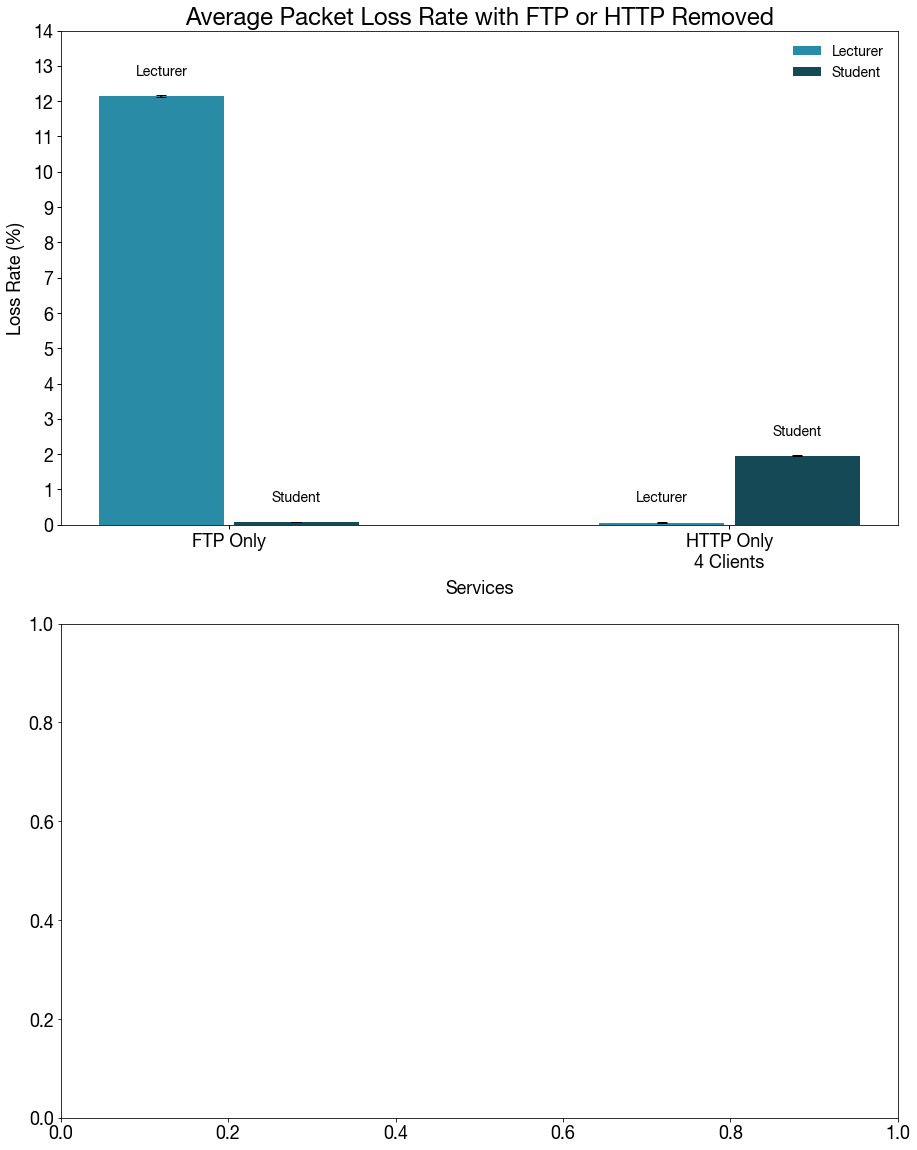

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from matplotlib import style
import math
import decimal
import statistics
from scipy import stats
import os

path = os.getcwd()

class Result_Analysis():
    
    def read_file(self, file_number):
        dict_ = {1: 'Sim_Results/CSV_Files/FTP_Only/VC_with_FTP_Only_AVG_PK_LOSS_Rate.csv',
                 2: 'Sim_Results/CSV_Files/HTTP_Only/VC_with_HTTP_Only_AVG_PK_LOSS_Rate.csv'
                }
    
        cols = ['run', 'timelimit', 'repetition', 'Module', 'Name', 'Avg_Loss_Rate']
        data = pd.read_csv(dict_[file_number], delimiter=',', skiprows=[0], names=cols)

        data = data.dropna()
        data = data.sort_values(by =['Name','Module','repetition'], ascending=True)
        data = data.reset_index(drop=True)
        df = pd.DataFrame(data)
        
        #print(df,"\n\n\n")
        
        Professor_avgPKL_2000s_arr = []
        Student_avgPKL_2000s_arr = []
        
        for i in range(len(data)): # UPDATE number of seconds
            if (df['timelimit'][i] == 2000 and 'Professor' in df['Module'][i]):
                Professor_avgPKL_2000s_arr.append(df['Avg_Loss_Rate'][i]*100) # Convert to percent
            elif (df['timelimit'][i] == 2000 and 'Student' in df['Module'][i]):
                Student_avgPKL_2000s_arr.append(df['Avg_Loss_Rate'][i]*100) # Convert to percent
           
        dict_array = {'Professor': Professor_avgPKL_2000s_arr, 'Student': Student_avgPKL_2000s_arr}
        #print(dict_array)
        return dict_array
    
    def SampleStDev(self, arr):
        sample_stdev = []
        for key, value in arr.items():
            sample_stdev.append(statistics.stdev(value))
        return sample_stdev
    
    def sampleMean(self, arr):
        sample_mean = []
        for key, value in arr.items():
            sample_mean.append(statistics.mean(value))
        return sample_mean
    
    #  We assume we know the population standard deviation. For n <= 30, use T-Score. For n > 30, use Z-Score.
    #  we assume two sided t-value for normal distribution and degree freedom is one less than the length of the array.
    def tScore(self, conf, arr):
        t_scores = []
        for inner_array in arr.values():
            t_scores.append(stats.t.ppf((conf + 1) / 2, len(inner_array)-1)) 
        return t_scores


    def confInterval_t(self, arr, sample_mean, sample_stdev, t_scores):
        for inner_array in arr.values():
            length = len(inner_array)
        
        upper_t = list((x+y for x,y in zip(sample_mean, 
                                           (a*b/math.sqrt(length) for a,b in zip(t_scores, sample_stdev)))))
        lower_t = list((x-y for x,y in zip(sample_mean, 
                                           (a*b/math.sqrt(length) for a,b in zip(t_scores, sample_stdev)))))
        
        return lower_t, upper_t
    
    def confInterval_z(self, con_coef, arr, sample_mean, sample_stdev):
        z_interval_l, z_interval_r = stats.norm.interval(con_coef)
        for inner_array in arr.values():
            length = len(inner_array)
            
        lower_z = list(x + y for x, y in zip(sample_mean, 
                                              (z_interval_l*element/ math.sqrt(length) for element in sample_stdev)))
        upper_z = list(x + y for x, y in zip(sample_mean, 
                                              (z_interval_r*element/ math.sqrt(length) for element in sample_stdev)))
        
        return lower_z, upper_z


run = True
while run:
    try:
        confidence_interval = float(input("\nPlease enter the desired confidence interval: "))
        if confidence_interval >= 1 or 0 >= confidence_interval:
            raise Exception 
                   
    except:
        print("Please enter a valid number from [0, 1)!")
        
    else:
        data_dict = {}
        mean_dict = {}
        t_dict = {}
        z_dict = {}
        
        for number in range(1,3):
            file_number = number
            
            obj = Result_Analysis()
            dict_array = obj.read_file(file_number)
            #print(dict_array)
            data_dict[number] = dict_array
            
            mean = obj.sampleMean(dict_array)
            mean_dict[number] = mean
            
            stdev = obj.SampleStDev(dict_array)
            tscore = obj.tScore(confidence_interval, dict_array)

            t_score_l, t_score_r = obj.confInterval_t(dict_array, mean, stdev, tscore)
            t_dict[number] = [(x,y) for x,y in zip(t_score_l, t_score_r)]
            
            z_score_l, z_score_r = obj.confInterval_z(confidence_interval, dict_array, mean, stdev)
            z_dict[number] = [(x,y) for x,y in zip(z_score_l, z_score_r)]

       
        professor_arr = []
        student_arr = []
        for number, dict_ in data_dict.items():
            for key, arr in dict_.items():
                if(key is 'Professor'):
                    professor_arr.append(arr)
                if(key is 'Student'):
                    student_arr.append(arr)
        all_professor_data = np.array(professor_arr,order='C').T.mean(axis=0)
        all_student_data = np.array(student_arr,order='C').T.mean(axis=0)
        
        print(all_professor_data)
        print(all_student_data)
        
        # UPDATE condition for i
        professor_data = [mean_dict[i][0] for i in mean_dict if i <= 2]
        student_data = [mean_dict[i][1] for i in mean_dict if i <= 2]
        
        # UPDATE condition for i
        professor_CI_l = [z_dict[i][0][0] for i in z_dict if i <= 2]
        professor_CI_u = [z_dict[i][0][1] for i in z_dict if i <= 2]

        professor_CI = [i for i in zip(professor_CI_l, professor_CI_u)]
        
        # UPDATE condition for i
        student_CI_l = [z_dict[i][1][0] for i in z_dict if i <= 2]
        student_CI_u = [z_dict[i][1][1] for i in z_dict if i <= 2]
        
        student_CI = [i for i in zip(student_CI_l, student_CI_u)]
        
        print(student_CI)
        print(professor_CI)
        
        # avg values in following order: FTP_Only, HTTP_Only (where HTTP Clients = 4)
        professor_bars = np.concatenate(
            (all_professor_data[0], all_professor_data[1]), axis=None)
        student_bars = np.concatenate(
            (all_student_data[0], all_student_data[1]), axis=None)
        
        # width of the bars
        barWidth = 0.25
        
        # Choose the height of the bars
        prof_bars = [professor_bars[0], professor_bars[1]]
        stud_bars = [student_bars[0], student_bars[1]]
        
        print(FTP_Only_bars)
        print(HTTP_Only_bars)
        
        # Choose the height of the confidence interval (error bars) for errorbar method
        prof_CI_yerr = [(u - l)/2 for l, u in professor_CI]
        stud_CI_yerr = [(u - l)/2 for l, u in student_CI]
        
        prof_CI_yerr_bars = [prof_CI_yerr[0], prof_CI_yerr[1]]
        stud_CI_yerr_bars = [stud_CI_yerr[0], stud_CI_yerr[1]]
        
        
        ## The x position of bars
        prof_x_pos = np.arange(len(prof_bars))
        stud_x_pos = [x + barWidth + 0.02 for x in prof_x_pos]
        
        # Parameter setting for plotting
        plt.rcParams['axes.edgecolor']='#000000'
        plt.rcParams['axes.linewidth']=0.8
        plt.rcParams['xtick.color']='#000000'
        plt.rcParams['ytick.color']='#000000'
        plt.rcParams.update({'font.size': 18})
        plt.rcParams["legend.edgecolor"] = 'inherit'
        plt.rcParams["axes.edgecolor"] = 'black'
        plt.rcParams["legend.facecolor"] = 'inherit'
        plt.rcParams["axes.facecolor"] = 'black'
        plt.rcParams["font.family"] = 'serif'
        plt.rcParams['font.serif'] = 'Helvetica Neue'
        
        fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(15, 20), facecolor = (1, 1, 1), edgecolor = (1, 1, 1))
        ax1.set_facecolor((1, 1, 1))
        ax2.set_facecolor((1, 1, 1))

        # fill with colors
        # Student color: #144955
        # Professor color: #2a8ba7
        # FTP Upload Student color: #f14c38
        # HTTP Clients color: #50c878
        
        # Create queueLength max bars
        ax1.bar(prof_x_pos, prof_bars, width = barWidth, color = '#2a8ba7',label='Lecturer')
        ax1.bar(stud_x_pos, stud_bars, width = barWidth, color = '#144955',label='Student')
        
        # Create error bars (CIs)
        ax1.errorbar(prof_x_pos, prof_bars, yerr=prof_CI_yerr_bars, color = '#000000', capthick=1, capsize=5, fmt=' ')
        ax1.errorbar(stud_x_pos, stud_bars, yerr=stud_CI_yerr_bars, color = '#000000', capthick=1, capsize=5, fmt=' ')
        
        all_bars = ax1.patches

        # Make some labels.
        bar_labels = ["Lecturer", "Lecturer", "Student", "Student"]
        
        #student_bar_labels = ["Lost", "Lost", "Lost",
        #                           "Late", "Late", "Late",
        #                           "Not Rcvd\n(Lost + Late)", "Not Rcvd\n(Lost + Late)", "Not Rcvd\n(Lost + Late)"]

        for rect, label in zip(all_bars, bar_labels):
            height = rect.get_height()
            ax1.text(rect.get_x() + rect.get_width() / 2, height + 0.5, label, ha='center', va='bottom', fontsize = 14)
        
        #for rect, label in zip(stud_bars, student_bar_labels):
        #    height = rect.get_height()
        #    ax2.text(rect.get_x() + rect.get_width() / 2, height + 100, label, ha='center', va='bottom', fontsize = 14)
    
        labels = ['FTP Only','HTTP Only\n4 Clients']
        x = np.arange(len(labels))  # the label locations
        ax1.set_xticks(x+0.135)
        ax1.set_xticklabels(labels, fontsize=18, color = '#000000')
        ax1.tick_params(direction='out', length=4, width=1, colors='#000000')
        
        
        ax1.set_yticks(np.arange(0, 15, 1))
        ax1.set_ylabel('Loss Rate (%)', fontsize=18 , labelpad=8, color = '#000000')
        ax1.set_xlabel('Services', fontsize=18 , labelpad=8, color = '#000000')
        ax1.set_title('Average Packet Loss Rate with FTP or HTTP Removed', fontsize=24, color = '#000000')
        
        #label_1_patch = mpatches.Patch(color='#144955', label='Student')
        #label_2_patch = mpatches.Patch(color='#2a8ba7', label='Lecturer')
        
        #leg1 = ax1.legend(handles=[label_1_patch,label_2_patch], facecolor='white', framealpha=1, 
        #                  bbox_to_anchor=(1.0, 1.0), loc='upper right', prop={'size': 14})
        #leg2 = ax2.legend(handles=[label_1_patch,label_2_patch], facecolor='white', framealpha=1, 
        #                  bbox_to_anchor=(1.0, 1.0), loc='upper right', prop={'size': 14})

        leg1 = ax1.legend(fontsize = 14, loc='lower right', bbox_to_anchor= (0.99, 0.89), ncol=1, framealpha=0,frameon=True,borderaxespad=0, edgecolor = 'black')
        #leg2 = ax2.legend(fontsize = 14, loc='lower right', bbox_to_anchor= (0.95, 0.90), ncol=1, borderaxespad=0, framealpha=1)
        
        #leg1 = ax1.legend(fontsize = 14, loc='lower right', bbox_to_anchor= (0.95, 0.90), ncol=1, borderaxespad=0, frameon=False)
        #leg2 = ax2.legend(fontsize = 14, loc='lower right', bbox_to_anchor= (0.95, 0.90), ncol=1, borderaxespad=0, framealpha=1)
        
        for text in leg1.get_texts():
            text.set_color("black")
        #for text in leg2.get_texts():
        #    text.set_color("black")
        
        #fig.tight_layout()
        plt.show()
        
        #print(f'\n\n\nCI based on T-score: \n{t_dict}')
        #print(f'\n\n\nCI based on Z-score: \n{z_dict}')
        #print(f'\n\n\nMean:{mean_dict}')
        
        run = False 